In [1]:
import sys; sys.path.insert(0, '../../')

from definitions import *

import numpy as np
import torch
import joblib

#Data
from src.data.dataset import TimeSeriesDataset
from src.data import dicts

#Features
from src.features.signatures.compute import RollingSignature
from src.features.rolling import RollingStatistic
from src.data.functions import torch_ffill
from src.features.derived_features import shock_index, partial_sofa, bun_cr

#Model
import lightgbm as lgb

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.gridspec as gridspec

#Drift Detection
from scipy.stats import ks_2samp
from skmultiflow.drift_detection import ADWIN, PageHinkley, KSWIN
from skmultiflow.data import TemporalDataStream
from skmultiflow.data.sea_generator import SEAGenerator

#Test/Evaluation metrics
from src.model.optimizer import CVThresholdOptimizer
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, accuracy_score
from src.model.optimizer import optimize_utility_threshold, compute_utility_from_indexes



## Load Time series Dataset

In [2]:
# Load the dataset
dataset = TimeSeriesDataset().load(DATA_DIR + '/raw/data.tsd')

In [3]:
dataset.data = torch_ffill(dataset.data)

##  Expert Features
The next step is to derive features held in 'expert knowledge'. That is, anything that is already known clinically thought to be important in detecting sepsis that can be derived from out dataset. 

For example:

- `ShockIndex = Heart Rate / Systolic Blood Pressure`: Was found in a sepsis detection paper (https://stm.sciencemag.org/content/7/299/299ra122) to be a more useful indicator than heart rate or SBP alone.

In [4]:
# Add on some additional features
dataset['ShockIndex'] = shock_index(dataset)
dataset['PartialSOFA'] = partial_sofa(dataset)
dataset['BUN/CR'] = bun_cr(dataset)

In [5]:
# First get counts of the laboratory values
count_variables = dicts.feature_types['laboratory'] + ['Temp']
counts = RollingStatistic(statistic='count', window_length=8).transform(dataset[count_variables])
dataset.add_features(counts)

<function RollingStatistic.transform at 0x000002C19D6106A8> 
  1391.01 ms


## Rolling Statistics and Signatures

In [6]:
# Now generate some rolling window features
changing_vars = dicts.feature_types['vitals']

moment_vals = RollingStatistic(statistic='moments', window_length=7).transform(dataset[changing_vars])
max_vals = RollingStatistic(statistic='max', window_length=6).transform(dataset[dicts.feature_types['vitals']])
min_vals = RollingStatistic(statistic='min', window_length=6).transform(dataset[dicts.feature_types['vitals']])

dataset.add_features(moment_vals)
dataset.add_features(torch.cat((max_vals, min_vals), 2))

<function RollingStatistic.transform at 0x000002C19D6106A8> 
  3704.03 ms
<function RollingStatistic.transform at 0x000002C19D6106A8> 
  427.01 ms
<function RollingStatistic.transform at 0x000002C19D6106A8> 
  434.00 ms


In [7]:
# Now some rolling signatures
roller = RollingSignature(window=7, depth=3, aug_list=['leadlag'], logsig=True)
for vbl in ['BUN/CR', 'PartialSOFA', 'MAP', 'HR', 'SBP']:
    signatures = roller.transform(dataset[vbl])
    dataset.add_features(signatures)

<function RollingSignature.transform at 0x000002C19D610048> 
  1434.01 ms
<function RollingSignature.transform at 0x000002C19D610048> 
  1528.01 ms
<function RollingSignature.transform at 0x000002C19D610048> 
  1394.01 ms
<function RollingSignature.transform at 0x000002C19D610048> 
  1401.01 ms
<function RollingSignature.transform at 0x000002C19D610048> 
  1451.01 ms


## Convert Time Series Data to ML Data

In [49]:
# Extract machine learning data
data = dataset.to_ml()
labels = load_pickle(DATA_DIR + '/processed/labels/utility_scores.pickle')

In [50]:
labels_binary = load_pickle(DATA_DIR + '/processed/labels/binary.pickle')

In [51]:
scores = load_pickle(DATA_DIR + '/processed/labels/full_scores.pickle').values

In [52]:
data[torch.isnan(data)] = 0

In [12]:
labels_binary

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [13]:
torch.unique(labels_binary, return_counts= True)

(tensor([0., 1.]), tensor([237930,   4231]))

In [14]:
torch.unique(labels, return_counts= True)

(tensor([-0.0500,  0.0000,  0.1667,  0.3333,  0.5000,  0.6667,  0.8333,  1.0000,
          1.1111,  1.2222,  1.3333,  1.4444,  1.5556,  1.6667,  1.7778,  1.8889,
          2.0000]),
 tensor([235758,    342,    351,    358,    366,    371,    384,    444,    443,
            442,    442,    442,    442,    440,    440,    402,    294]))

In [15]:
#Use only data from Hospital B for training
X_b = data[120492:]
y_b = labels[120492:]
 

In [16]:
torch.unique(y_b, return_counts= True)

(tensor([-0.0500,  0.0000,  0.1667,  0.3333,  0.5000,  0.6667,  0.8333,  1.0000,
          1.1111,  1.2222,  1.3333,  1.4444,  1.5556,  1.6667,  1.7778,  1.8889,
          2.0000]),
 tensor([118956,    137,    143,    147,    151,    153,    159,    193,    192,
            191,    191,    191,    191,    189,    189,    168,    128]))

In [17]:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.1, random_state=0)

In [18]:
lgb_train_b = lgb.Dataset(X_b_train, y_b_train.numpy())
lgb_eval_b = lgb.Dataset(X_b_test, y_b_test.numpy(), reference=lgb_train_b)

## LightGBM Train

In [19]:

params = {
    'task': 'train',
    'application': 'regression',  # objective function
    'boosting_type': 'gbdt',  # Setting Upgrade Types
    'learning_rate': 0.01,  # Learning rate
    'num_leaves': 70,  # Number of leaf nodes
    'min_data_in_leaf': 100,
    'metric': ['rmse'],  # Evaluation function
    'max_bin': 255,
    'min_split_gain': 0.001,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.9,
    'max_depth': 23,
    'min_child_weight': 10,
}


In [20]:

model1 = lgb.train(params, 
                 lgb_train_b,
                 valid_sets=lgb_eval_b,
                 early_stopping_rounds=300)

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18261
[LightGBM] [Info] Number of data points in the train set: 109502, number of used features: 124
[LightGBM] [Info] Start training from score -0.023441
[1]	valid_0's rmse: 0.187851
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 0.187567
[3]	valid_0's rmse: 0.187282
[4]	valid_0's rmse: 0.187022
[5]	valid_0's rmse: 0.186728
[6]	valid_0's rmse: 0.186459
[7]	valid_0's rmse: 0.186201
[8]	valid_0's rmse: 0.185975
[9]	valid_0's rmse: 0.185709
[10]	valid_0's rmse: 0.185474
[11]	valid_0's rmse: 0.185263
[12]	valid_0's rmse: 0.185028
[13]	valid_0's rmse: 0.184809
[14]	valid_0's rmse: 0.184547
[15]	valid_0's rmse: 0.18432
[16]	valid_0's rmse: 0.184115
[17]	valid_0's rmse: 0.183904
[18]	valid_0's rmse: 0.18

In [21]:
test_preds = model1.predict(data[:120492])
train_preds = model1.predict(data[120492:])

#MAE
MAE_train = mean_absolute_error(labels[120492:], train_preds)
MAE_test = mean_absolute_error(labels[:120492], test_preds) 
print('Train Mean Abolute Error: {:.3f}'.format(MAE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(MAE_test))

#RMSE
RMSE_train = mean_squared_error(labels[120492:], train_preds, squared=False) #squared to False will calculate RMSE
RMSE_test = mean_squared_error(labels[:120492], test_preds, squared=False) #squared to False will calculate RMSE
print('\nTrain Root Mean Squared Error: {:.3f}'.format(RMSE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(RMSE_test))


#MSE
MSE_train = mean_squared_error(labels[120492:], train_preds) 
MSE_test = mean_squared_error(labels[:120492], test_preds) 
print('\nTrain Root Mean Squared Error: {:.3f}'.format(MSE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(MSE_test))


#RMSLE

RMSLE_train = np.log(mean_squared_error(labels[120492:], train_preds, squared=False))
RMSLE_test = np.log(mean_squared_error(labels[:120492], test_preds, squared=False))
print('\nTrain Root Mean Squared Log Error: {:.3f}'.format(RMSLE_train))
print('Test Root Mean Squared Log Error: {:.3f}'.format(RMSLE_test))

#R2 Score
print("\nTest  R2 Score : %.2f"%r2_score(labels[:120492], test_preds))
print("Train R2 Score : %.2f"%r2_score(labels[120492:], train_preds))

#Utility function
predictions = torch.from_numpy(train_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
thresh = optimize_utility_threshold(predictions, scores= scores[120492:])
train_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[120492:])
print('\nTrain utility score: {:.3f}'.format(train_utility))

predictions = torch.from_numpy(test_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
test_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[:120492])
print('Test utility score: {:.3f}'.format(test_utility))




c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Train Mean Abolute Error: 0.045
Test Root Mean Squared Error: 0.085

Train Root Mean Squared Error: 0.172
Test Root Mean Squared Error: 0.227

Train Root Mean Squared Error: 0.030
Test Root Mean Squared Error: 0.052

Train Root Mean Squared Log Error: -1.760
Test Root Mean Squared Log Error: -1.481

Test  R2 Score : -0.02
Train R2 Score : 0.22

Train utility score: 0.745
Test utility score: 0.228


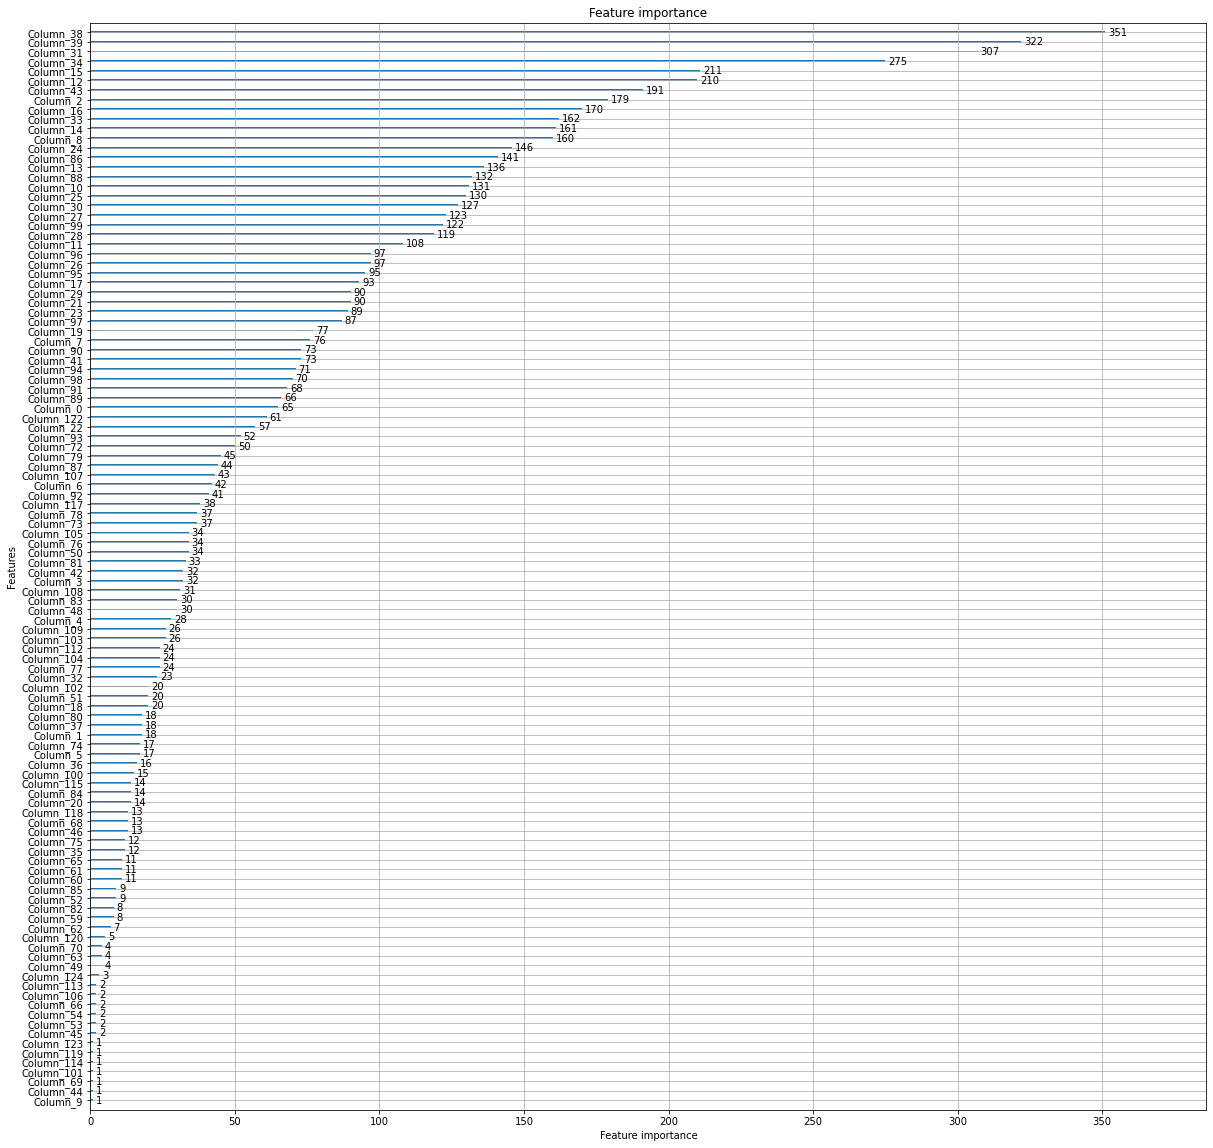

In [22]:
lgb.plot_importance(model1, figsize=(20,20))

##  Incremental LightGBM 


In [23]:
gbm = None

model2 = lgb.train(params,
    lgb_train_b,
    valid_sets=lgb_eval_b,
    init_model=gbm,  # If gbm is not None, then it is on the basis of the last training.
    early_stopping_rounds=300,
    num_boost_round =500,
    keep_training_booster=True)  # Incremental training

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18261
[LightGBM] [Info] Number of data points in the train set: 109502, number of used features: 124
[LightGBM] [Info] Start training from score -0.023441
[1]	valid_0's rmse: 0.187851
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 0.187567
[3]	valid_0's rmse: 0.187282
[4]	valid_0's rmse: 0.187022
[5]	valid_0's rmse: 0.186728
[6]	valid_0's rmse: 0.186459
[7]	valid_0's rmse: 0.186201
[8]	valid_0's rmse: 0.185975
[9]	valid_0's rmse: 0.185709
[10]	valid_0's rmse: 0.185474
[11]	valid_0's rmse: 0.185263
[12]	valid_0's rmse: 0.185028
[13]	valid_0's rmse: 0.184809
[14]	valid_0's rmse: 0.184547
[15]	valid_0's rmse: 0.18432
[16]	valid_0's rmse: 0.184115
[17]	valid_0's rmse: 0.183904
[18]	valid_0's rmse: 0.18

[257]	valid_0's rmse: 0.154133
[258]	valid_0's rmse: 0.15401
[259]	valid_0's rmse: 0.15395
[260]	valid_0's rmse: 0.153869
[261]	valid_0's rmse: 0.153772
[262]	valid_0's rmse: 0.153682
[263]	valid_0's rmse: 0.15361
[264]	valid_0's rmse: 0.153534
[265]	valid_0's rmse: 0.153455
[266]	valid_0's rmse: 0.153371
[267]	valid_0's rmse: 0.153302
[268]	valid_0's rmse: 0.153221
[269]	valid_0's rmse: 0.153125
[270]	valid_0's rmse: 0.153062
[271]	valid_0's rmse: 0.152951
[272]	valid_0's rmse: 0.15287
[273]	valid_0's rmse: 0.152818
[274]	valid_0's rmse: 0.152737
[275]	valid_0's rmse: 0.152669
[276]	valid_0's rmse: 0.152603
[277]	valid_0's rmse: 0.152548
[278]	valid_0's rmse: 0.15248
[279]	valid_0's rmse: 0.152415
[280]	valid_0's rmse: 0.152344
[281]	valid_0's rmse: 0.152264
[282]	valid_0's rmse: 0.152178
[283]	valid_0's rmse: 0.152103
[284]	valid_0's rmse: 0.152043
[285]	valid_0's rmse: 0.15196
[286]	valid_0's rmse: 0.151875
[287]	valid_0's rmse: 0.151803
[288]	valid_0's rmse: 0.151716
[289]	valid_0'

In [24]:
joblib.dump(model2, 'Incremental_lightGBM.pkl')

['Incremental_lightGBM.pkl']

In [25]:
# Model Loading
gbm = joblib.load('Incremental_lightGBM.pkl')

In [26]:
X_a = data[2000:120492]
y_a = labels[2000:120492]

In [27]:
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, test_size=0.1, random_state=0)
lgb_train_a = lgb.Dataset(X_a_train, y_a_train.numpy())
lgb_eval_a = lgb.Dataset(X_a_test, y_a_test.numpy(), reference=lgb_train_a)

In [28]:

model2 = lgb.train(params,
    lgb_train_a,
    valid_sets=lgb_eval_a,
    init_model=gbm,  # If gbm is not None, then it is on the basis of the last training.
    early_stopping_rounds=300,
    num_boost_round =500,
    keep_training_booster=True)  # Incremental training

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17843
[LightGBM] [Info] Number of data points in the train set: 106642, number of used features: 122
[501]	valid_0's rmse: 0.254237
Training until validation scores don't improve for 300 rounds
[502]	valid_0's rmse: 0.253552
[503]	valid_0's rmse: 0.252835
[504]	valid_0's rmse: 0.252116
[505]	valid_0's rmse: 0.251537
[506]	valid_0's rmse: 0.250869
[507]	valid_0's rmse: 0.250222
[508]	valid_0's rmse: 0.249567
[509]	valid_0's rmse: 0.248891
[510]	valid_0's rmse: 0.248275
[511]	valid_0's rmse: 0.247667
[512]	valid_0's rmse: 0.247046
[513]	valid_0's rmse: 0.246444
[514]	valid_0's rmse: 0.245855
[515]	valid_0's rmse: 0.245279
[516]	valid_0's rmse: 0.244722
[517]	valid_0's rmse: 0.244144
[518]	valid_0's rmse: 0.243651
[519]	valid_0's rmse:

[754]	valid_0's rmse: 0.193582
[755]	valid_0's rmse: 0.193468
[756]	valid_0's rmse: 0.193381
[757]	valid_0's rmse: 0.193294
[758]	valid_0's rmse: 0.19318
[759]	valid_0's rmse: 0.19309
[760]	valid_0's rmse: 0.192981
[761]	valid_0's rmse: 0.192903
[762]	valid_0's rmse: 0.192824
[763]	valid_0's rmse: 0.192757
[764]	valid_0's rmse: 0.19266
[765]	valid_0's rmse: 0.192552
[766]	valid_0's rmse: 0.192471
[767]	valid_0's rmse: 0.192389
[768]	valid_0's rmse: 0.192285
[769]	valid_0's rmse: 0.192155
[770]	valid_0's rmse: 0.192073
[771]	valid_0's rmse: 0.191981
[772]	valid_0's rmse: 0.191885
[773]	valid_0's rmse: 0.191778
[774]	valid_0's rmse: 0.191698
[775]	valid_0's rmse: 0.191622
[776]	valid_0's rmse: 0.191532
[777]	valid_0's rmse: 0.191413
[778]	valid_0's rmse: 0.191327
[779]	valid_0's rmse: 0.191206
[780]	valid_0's rmse: 0.191124
[781]	valid_0's rmse: 0.191047
[782]	valid_0's rmse: 0.190935
[783]	valid_0's rmse: 0.190855
[784]	valid_0's rmse: 0.190723
[785]	valid_0's rmse: 0.190648
[786]	valid

In [29]:
test_preds = model2.predict(data[:2000])
train_preds = model2.predict(data[2000:120492])

#MAE
MAE_train = mean_absolute_error(labels[2000:120492], train_preds)
MAE_test = mean_absolute_error(labels[:2000], test_preds) 
print('Train Mean Abolute Error: {:.3f}'.format(MAE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(MAE_test))

#RMSE
RMSE_train = mean_squared_error(labels[2000:120492], train_preds, squared=False) #squared to False will calculate RMSE
RMSE_test = mean_squared_error(labels[:2000], test_preds, squared=False) #squared to False will calculate RMSE
print('\nTrain Root Mean Squared Error: {:.3f}'.format(RMSE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(RMSE_test))

#MSE
MSE_train = mean_squared_error(labels[2000:120492], train_preds) #squared to False will calculate RMSE
MSE_test = mean_squared_error(labels[:2000], test_preds) #squared to False will calculate RMSE
print('\nTrain Root Mean Squared Error: {:.3f}'.format(MSE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(MSE_test))

#RMSLE

RMSLE_train = np.log(mean_squared_error(labels[2000:120492], train_preds, squared=False))
RMSLE_test = np.log(mean_squared_error(labels[:2000], test_preds, squared=False))
print('\nTrain Root Mean Squared Log Error: {:.3f}'.format(RMSLE_train))
print('Test Root Mean Squared Log Error: {:.3f}'.format(RMSLE_test))

#R2 Score
print("\nTest  R2 Score : %.2f"%r2_score(labels[:2000], test_preds))
print("Train R2 Score : %.2f"%r2_score(labels[2000:120492], train_preds))

#Utility function
predictions = torch.from_numpy(train_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
thresh = optimize_utility_threshold(predictions, scores= scores[2000:120492])
train_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[2000:120492])
print('\nTrain utility score: {:.3f}'.format(train_utility))

predictions = torch.from_numpy(test_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
test_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[:2000])
print('Test utility score: {:.3f}'.format(test_utility))



Train Mean Abolute Error: 0.057
Test Root Mean Squared Error: 0.079

Train Root Mean Squared Error: 0.164
Test Root Mean Squared Error: 0.218

Train Root Mean Squared Error: 0.027
Test Root Mean Squared Error: 0.048

Train Root Mean Squared Log Error: -1.809
Test Root Mean Squared Log Error: -1.523

Test  R2 Score : 0.09
Train R2 Score : 0.47

Train utility score: 0.856
Test utility score: 0.357


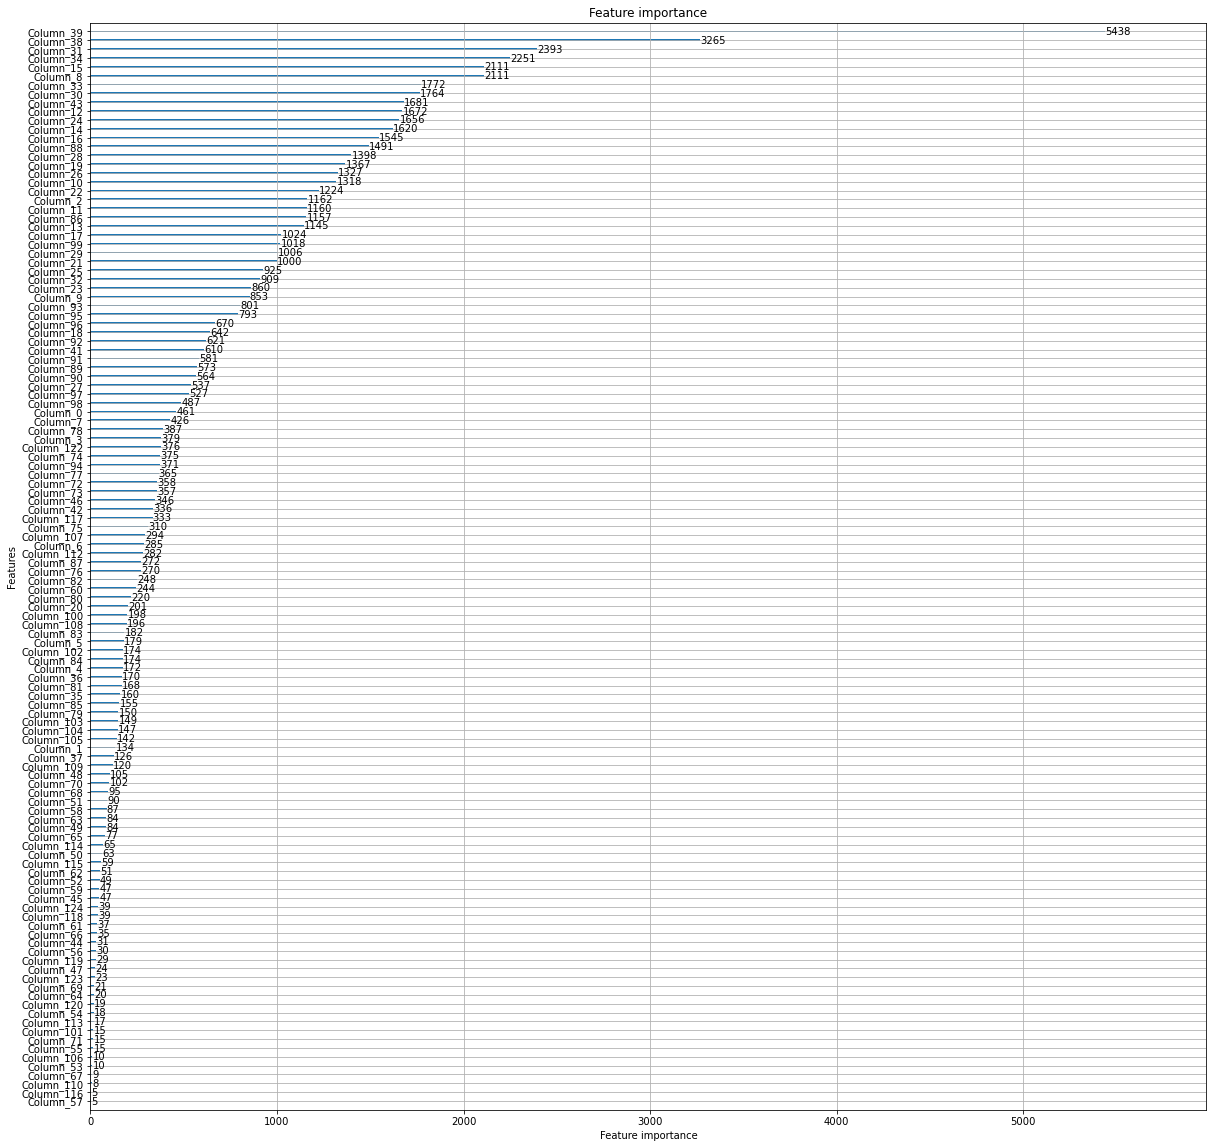

In [30]:
lgb.plot_importance(model2, figsize=(20,20))

## Big LightGBM


In [31]:
#Use data from Hospital A and B for training and evaluation and keep the first 2000 points for testing
X = data[2000:]
y = labels[2000:]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [33]:
lgb_train = lgb.Dataset(X_train, y_train.numpy())
lgb_eval = lgb.Dataset(X_test, y_test.numpy(), reference=lgb_train)

In [34]:
params = {
    'task': 'train',
    'application': 'regression',  # objective function
    'boosting_type': 'gbdt',  # Setting Upgrade Types
    'learning_rate': 0.01,  # Learning rate
    'num_leaves': 70,  # Number of leaf nodes
    'min_data_in_leaf': 100,
    'metric': ['rmse'],  # Evaluation function
    'max_bin': 255,
    'min_split_gain': 0.001,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.9,
    'max_depth': 23,
    'min_child_weight': 10,
}

In [35]:
model3 = lgb.train(params, 
                 lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round =500,
                 early_stopping_rounds=300)

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19392
[LightGBM] [Info] Number of data points in the train set: 216144, number of used features: 125
[LightGBM] [Info] Start training from score -0.018949
[1]	valid_0's rmse: 0.20735
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 0.207111
[3]	valid_0's rmse: 0.206866
[4]	valid_0's rmse: 0.206601
[5]	valid_0's rmse: 0.206361
[6]	valid_0's rmse: 0.206131
[7]	valid_0's rmse: 0.20588
[8]	valid_0's rmse: 0.205662
[9]	valid_0's rmse: 0.205442
[10]	valid_0's rmse: 0.205217
[11]	valid_0's rmse: 0.204964
[12]	valid_0's rmse: 0.204744
[13]	valid_0's rmse: 0.204519
[14]	valid_0's rmse: 0.204323
[15]	valid_0's rmse: 0.204117
[16]	valid_0's rmse: 0.203873
[17]	valid_0's rmse: 0.203673
[18]	valid_0's rmse: 0.203

[265]	valid_0's rmse: 0.177889
[266]	valid_0's rmse: 0.177837
[267]	valid_0's rmse: 0.177785
[268]	valid_0's rmse: 0.177722
[269]	valid_0's rmse: 0.177677
[270]	valid_0's rmse: 0.177614
[271]	valid_0's rmse: 0.177539
[272]	valid_0's rmse: 0.177473
[273]	valid_0's rmse: 0.177412
[274]	valid_0's rmse: 0.17734
[275]	valid_0's rmse: 0.177295
[276]	valid_0's rmse: 0.17723
[277]	valid_0's rmse: 0.177184
[278]	valid_0's rmse: 0.177119
[279]	valid_0's rmse: 0.177055
[280]	valid_0's rmse: 0.176999
[281]	valid_0's rmse: 0.176934
[282]	valid_0's rmse: 0.176869
[283]	valid_0's rmse: 0.176808
[284]	valid_0's rmse: 0.176749
[285]	valid_0's rmse: 0.176683
[286]	valid_0's rmse: 0.176639
[287]	valid_0's rmse: 0.176592
[288]	valid_0's rmse: 0.176514
[289]	valid_0's rmse: 0.176432
[290]	valid_0's rmse: 0.17637
[291]	valid_0's rmse: 0.176302
[292]	valid_0's rmse: 0.176249
[293]	valid_0's rmse: 0.176195
[294]	valid_0's rmse: 0.176117
[295]	valid_0's rmse: 0.17604
[296]	valid_0's rmse: 0.175965
[297]	valid_

In [36]:
test_preds = model3.predict(data[:2000])
train_preds = model3.predict(data[2000:])

#MAE
MAE_train = mean_absolute_error(labels[2000:], train_preds)
MAE_test = mean_absolute_error(labels[:2000], test_preds) 
print('Train Mean Abolute Error: {:.3f}'.format(MAE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(MAE_test))

#RMSE
RMSE_train = mean_squared_error(labels[2000:], train_preds, squared=False) #squared to False will calculate RMSE
RMSE_test = mean_squared_error(labels[:2000], test_preds, squared=False) #squared to False will calculate RMSE
print('\nTrain Root Mean Squared Error: {:.3f}'.format(RMSE_train))
print('Test Root Mean Squared Error: {:.3f}'.format(RMSE_test))

#MSE
MSE_train = mean_squared_error(labels[2000:], train_preds) 
MSE_test = mean_squared_error(labels[:2000], test_preds)
print('\nTrain  Mean Squared Error: {:.3f}'.format(MSE_train))
print('Test  Mean Squared Error: {:.3f}'.format(MSE_test))

#RMSLE

RMSLE_train = np.log(mean_squared_error(labels[2000:], train_preds, squared=False))
RMSLE_test = np.log(mean_squared_error(labels[:2000], test_preds, squared=False))
print('\nTrain Root Mean Squared Log Error: {:.3f}'.format(RMSLE_train))
print('Test Root Mean Squared Log Error: {:.3f}'.format(RMSLE_test))

#R2 Score
print("\nTest  R2 Score : %.2f"%r2_score(labels[:2000], test_preds))
print("Train R2 Score : %.2f"%r2_score(labels[2000:], train_preds))


#Utility function
predictions = torch.from_numpy(train_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
thresh = optimize_utility_threshold(predictions, scores= scores[2000:])
train_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[2000:])
print('\nTrain utility score: {:.3f}'.format(train_utility))

predictions = torch.from_numpy(test_preds)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
test_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[:2000])
print('Test utility score: {:.3f}'.format(test_utility))



c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Train Mean Abolute Error: 0.043
Test Root Mean Squared Error: 0.062

Train Root Mean Squared Error: 0.161
Test Root Mean Squared Error: 0.205

Train  Mean Squared Error: 0.026
Test  Mean Squared Error: 0.042

Train Root Mean Squared Log Error: -1.826
Test Root Mean Squared Log Error: -1.584

Test  R2 Score : 0.20
Train R2 Score : 0.41

Train utility score: 0.797
Test utility score: 0.549


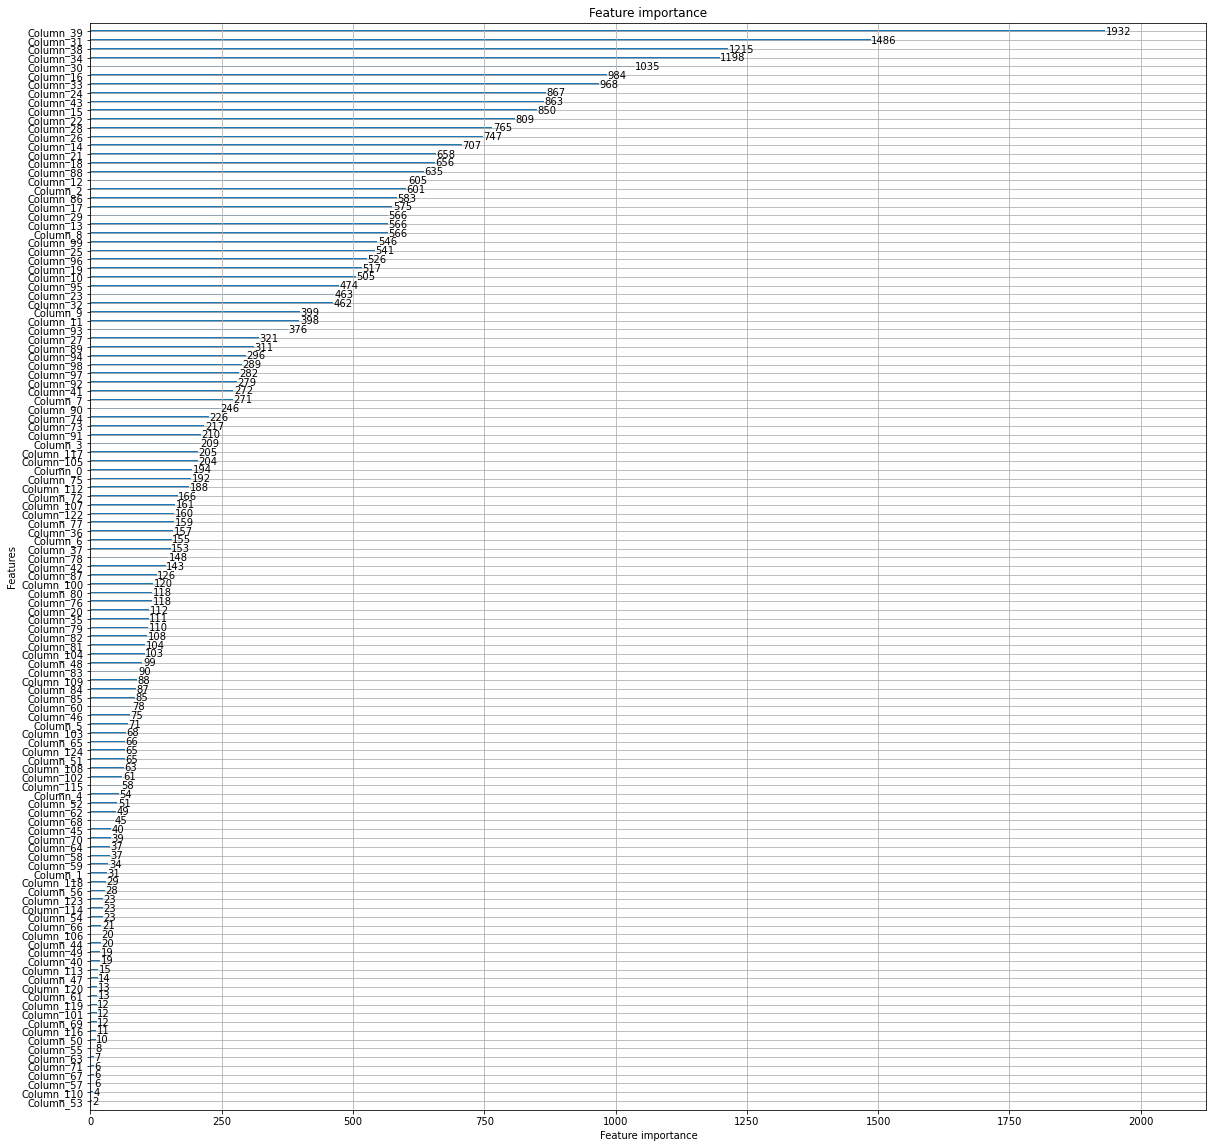

In [37]:
lgb.plot_importance(model3, figsize=(20,20))

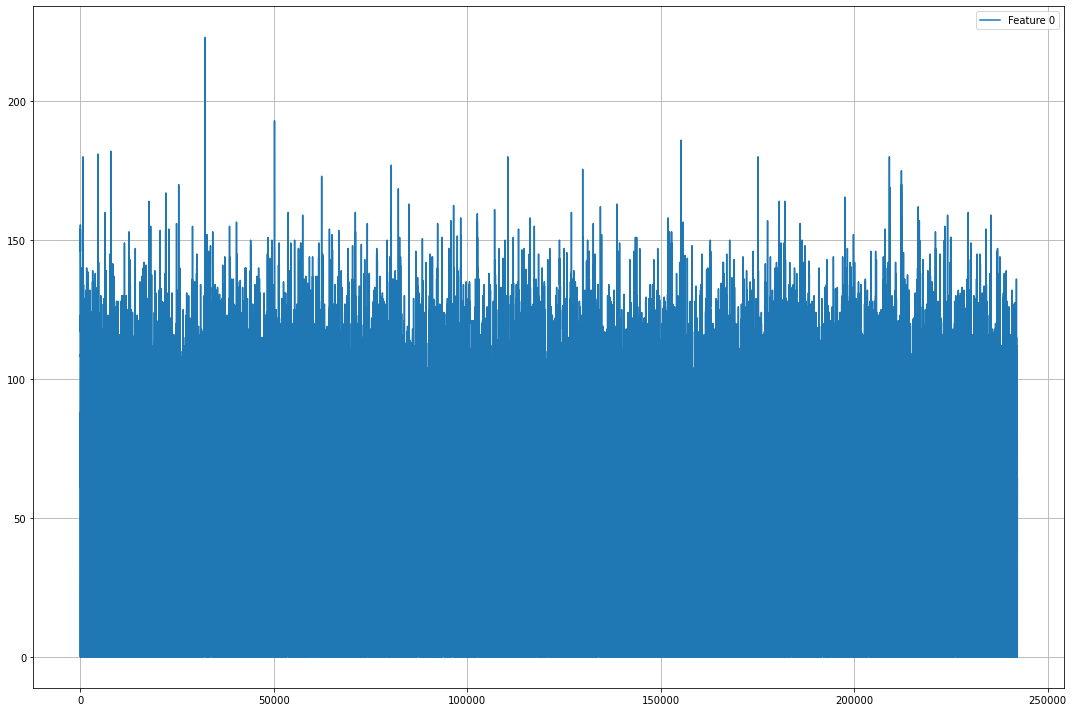

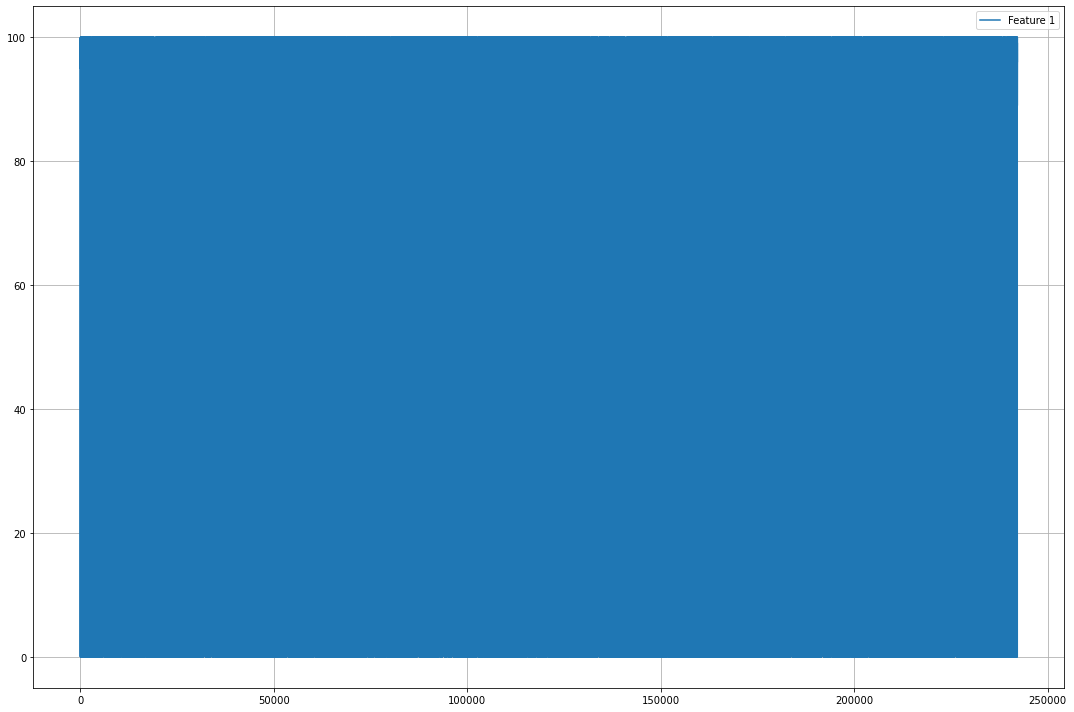

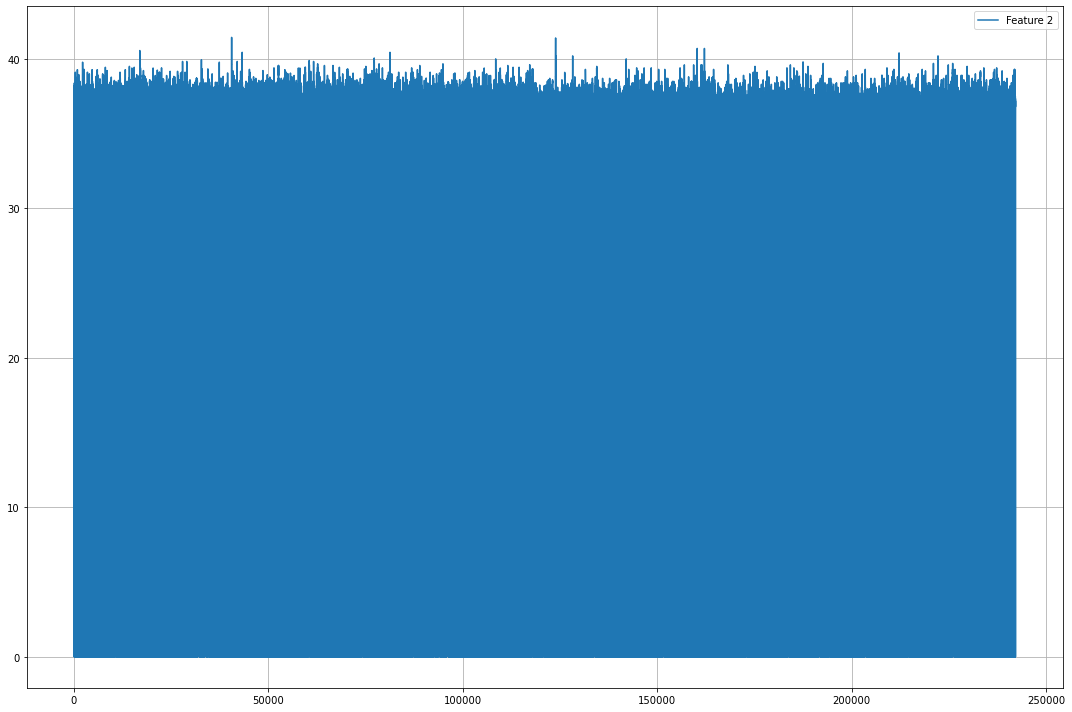

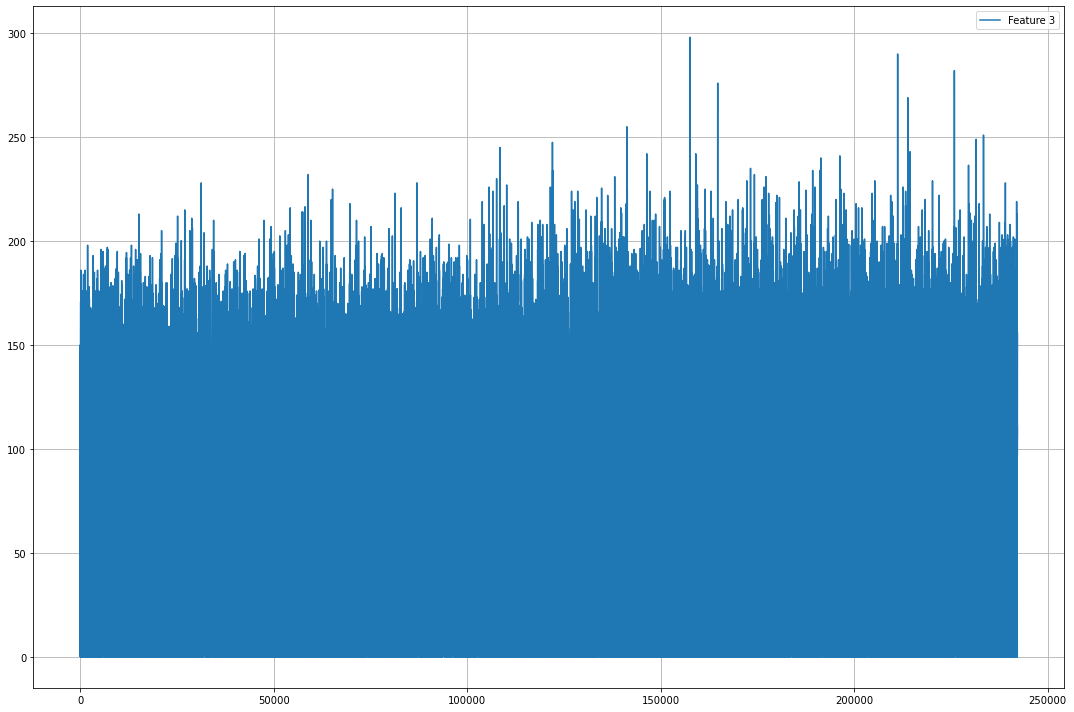

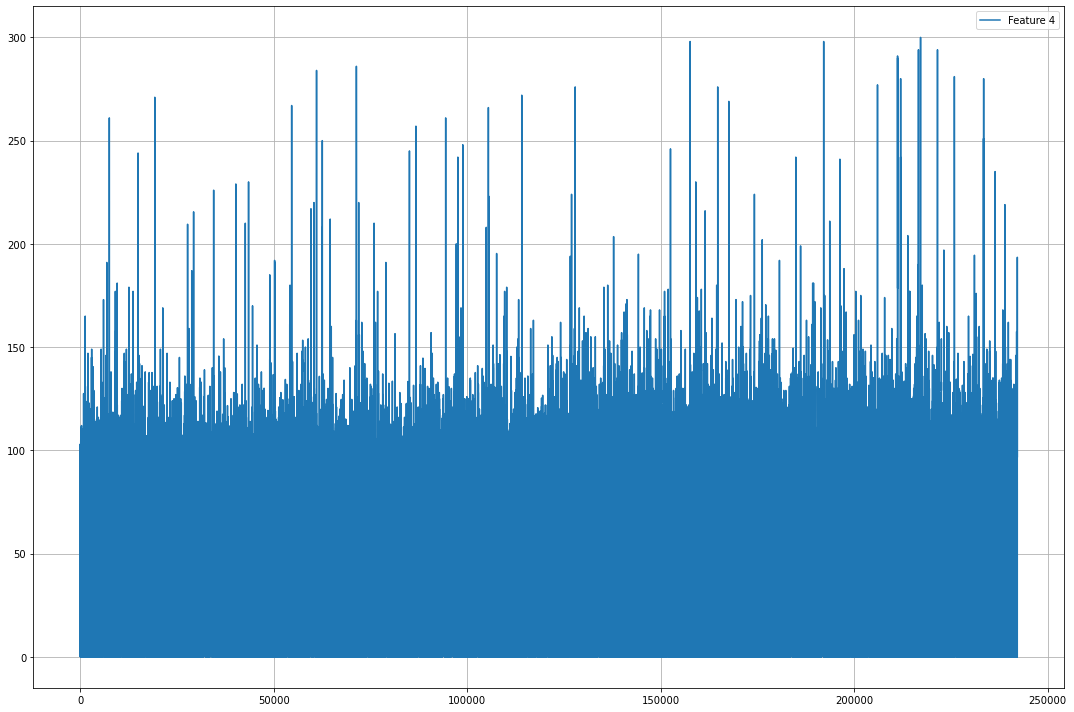

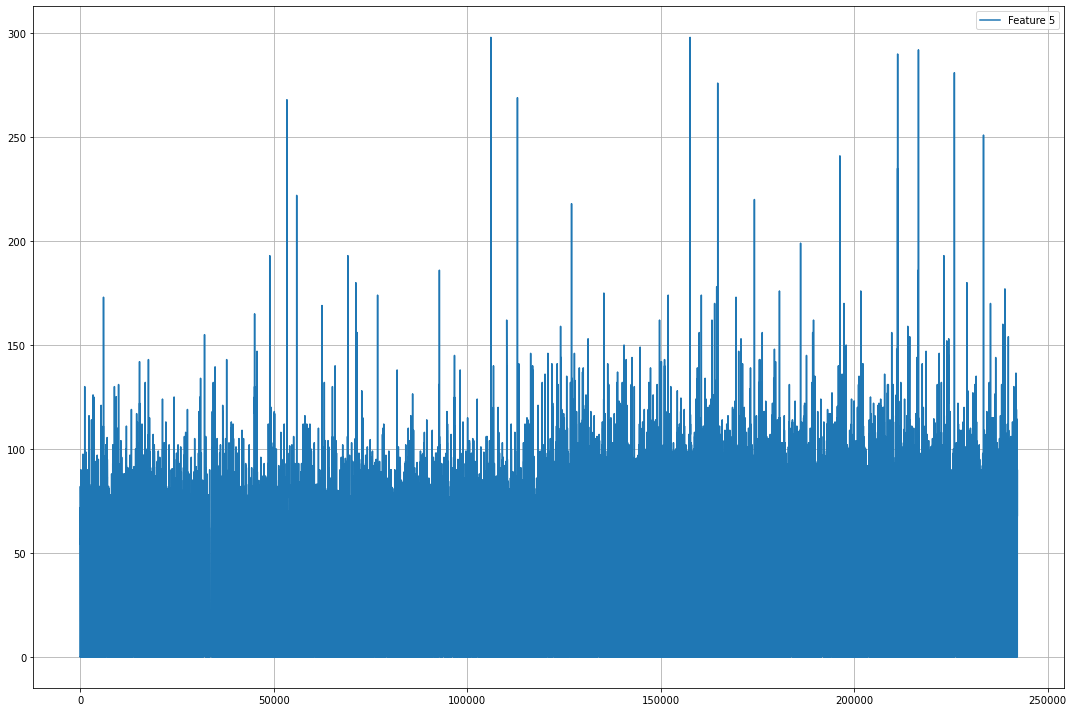

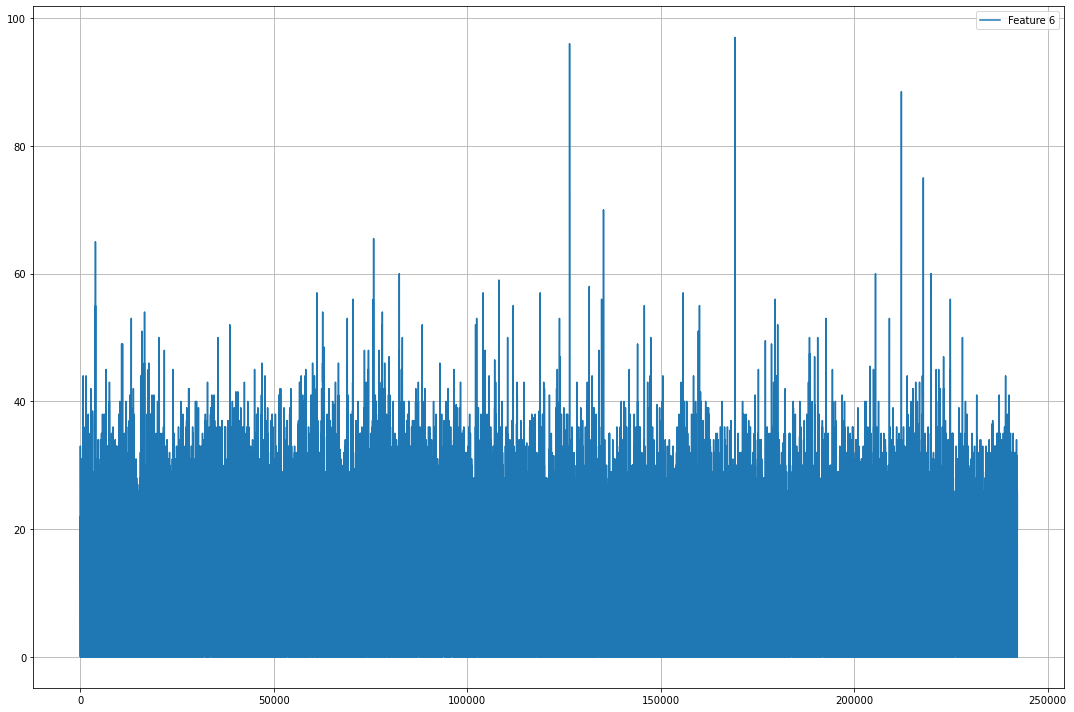

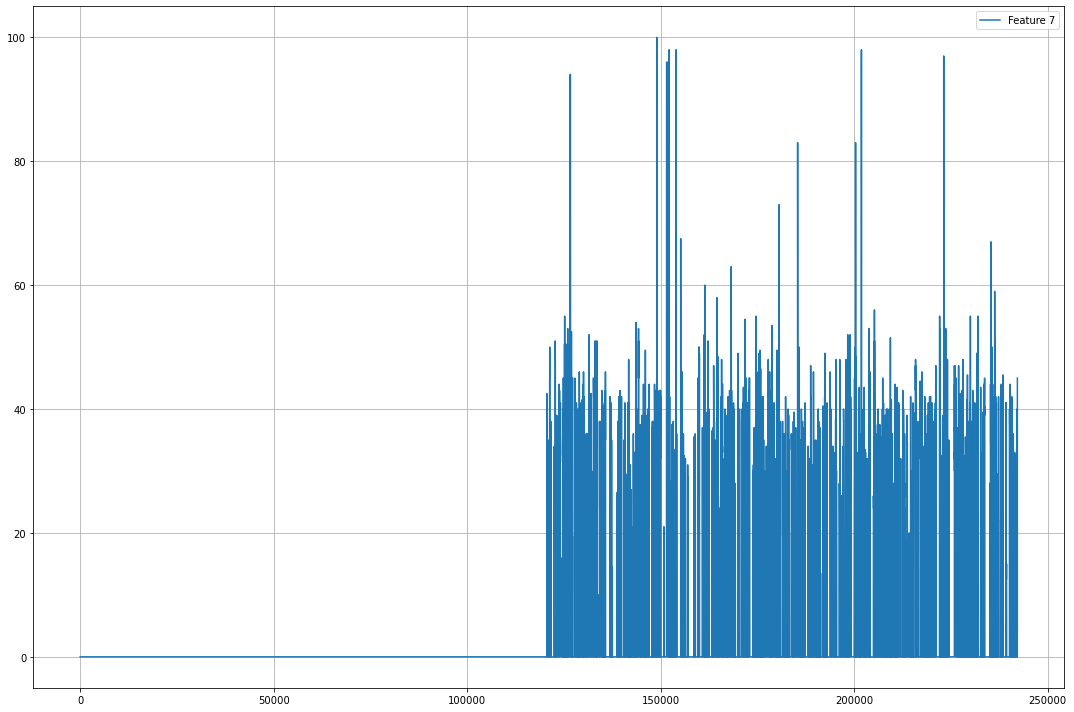

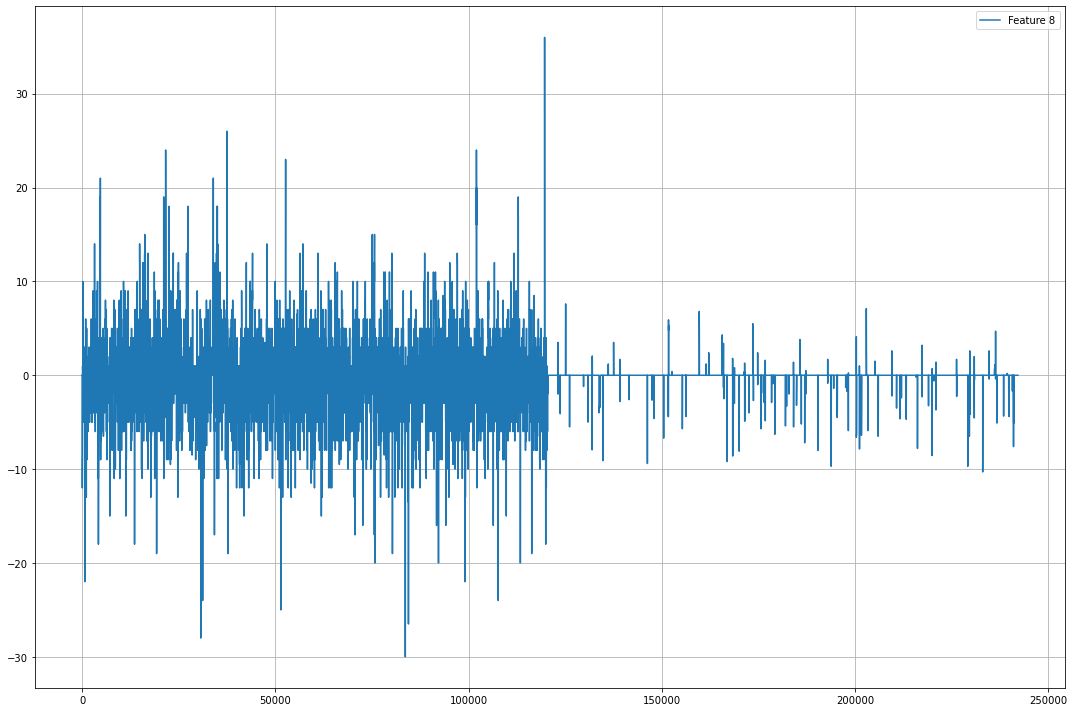

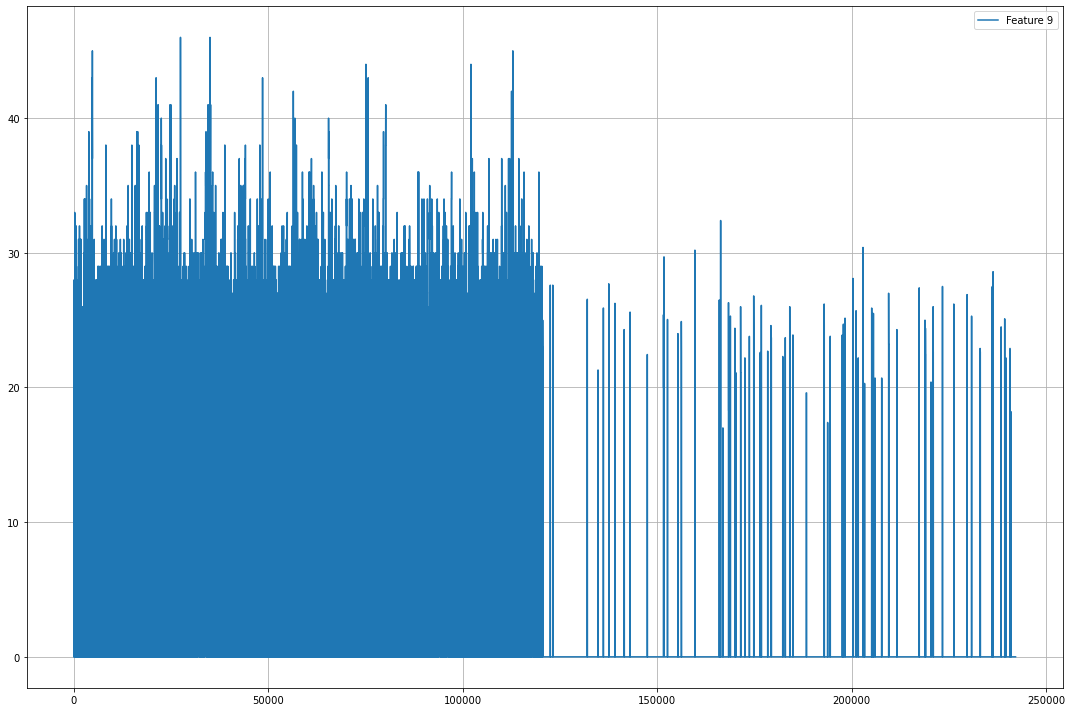

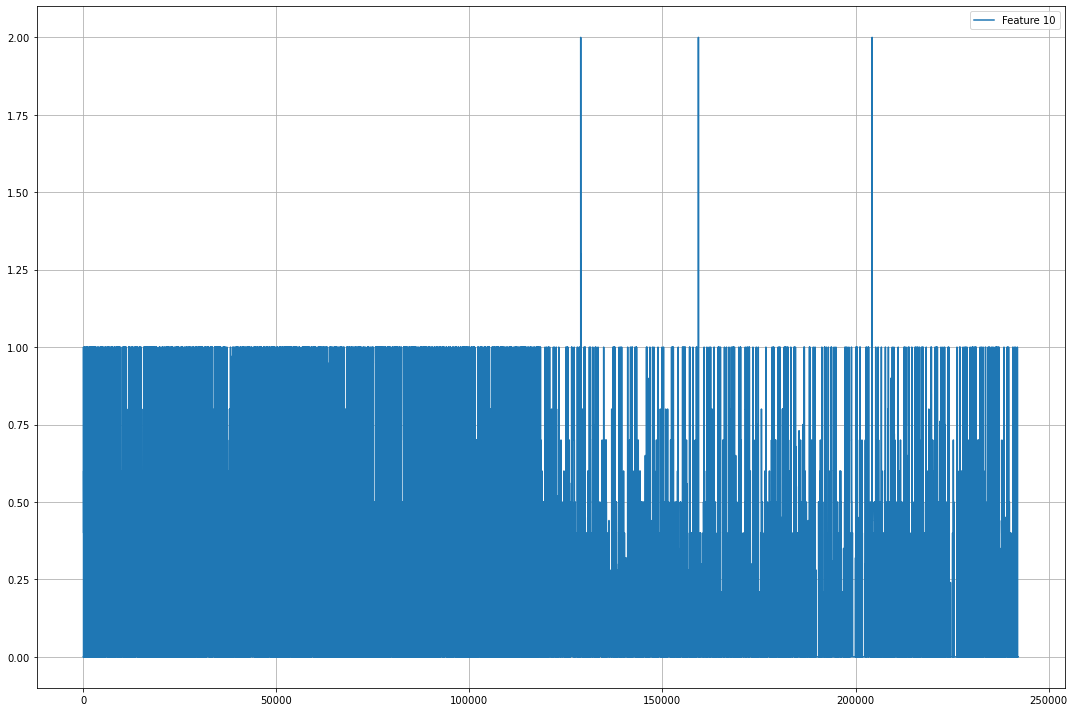

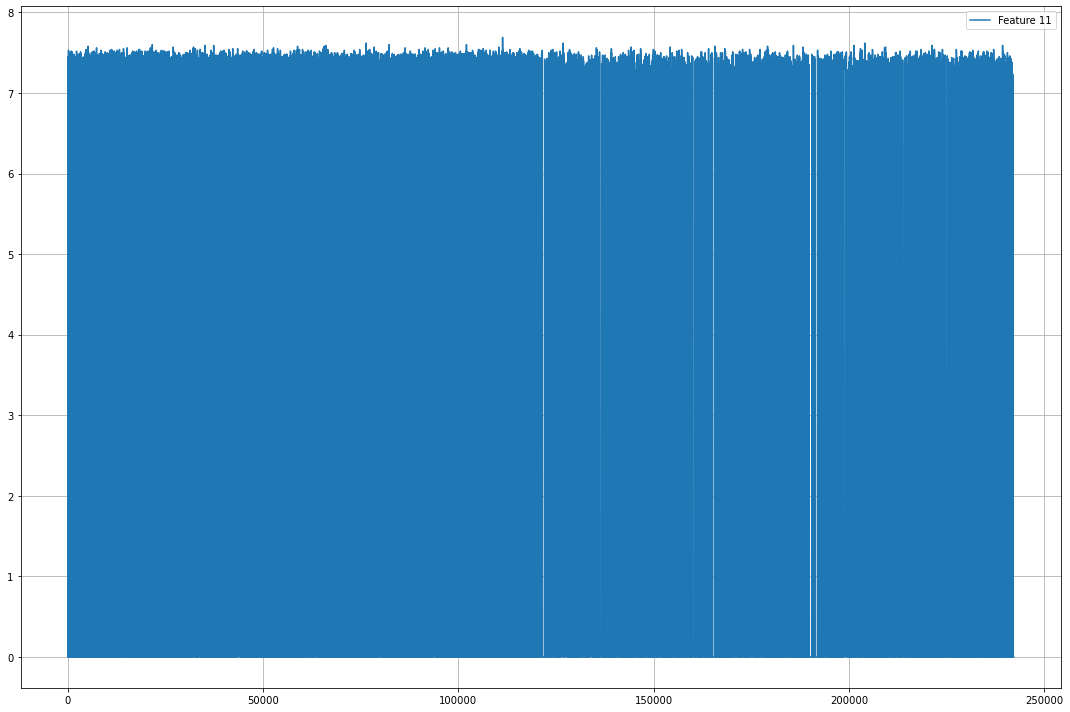

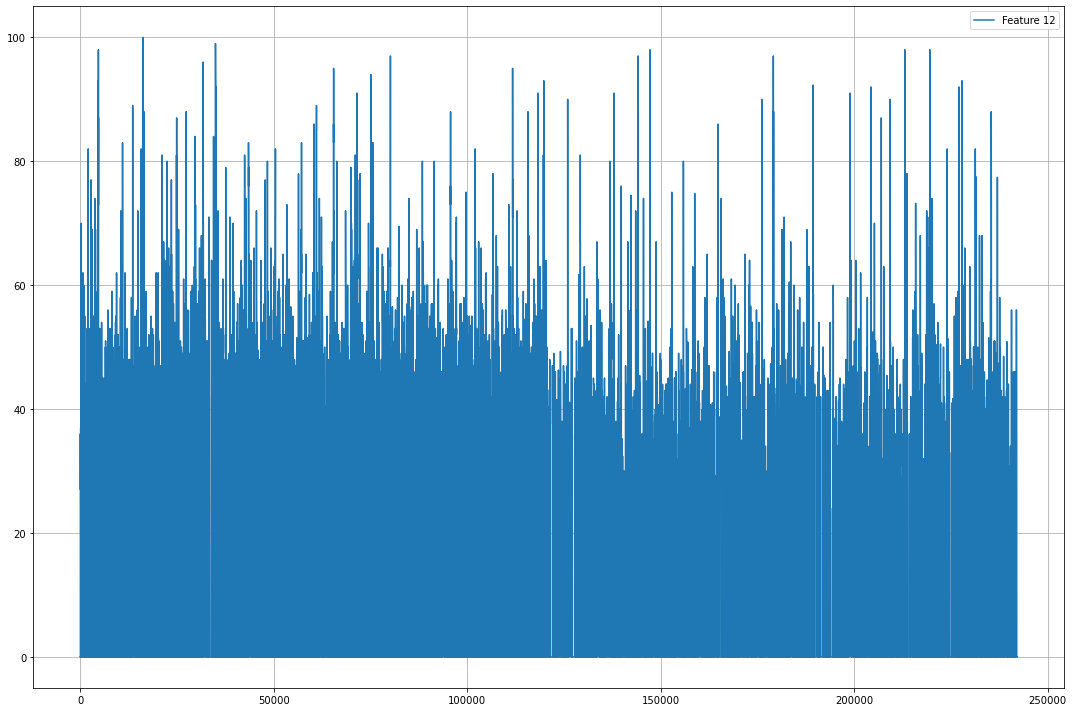

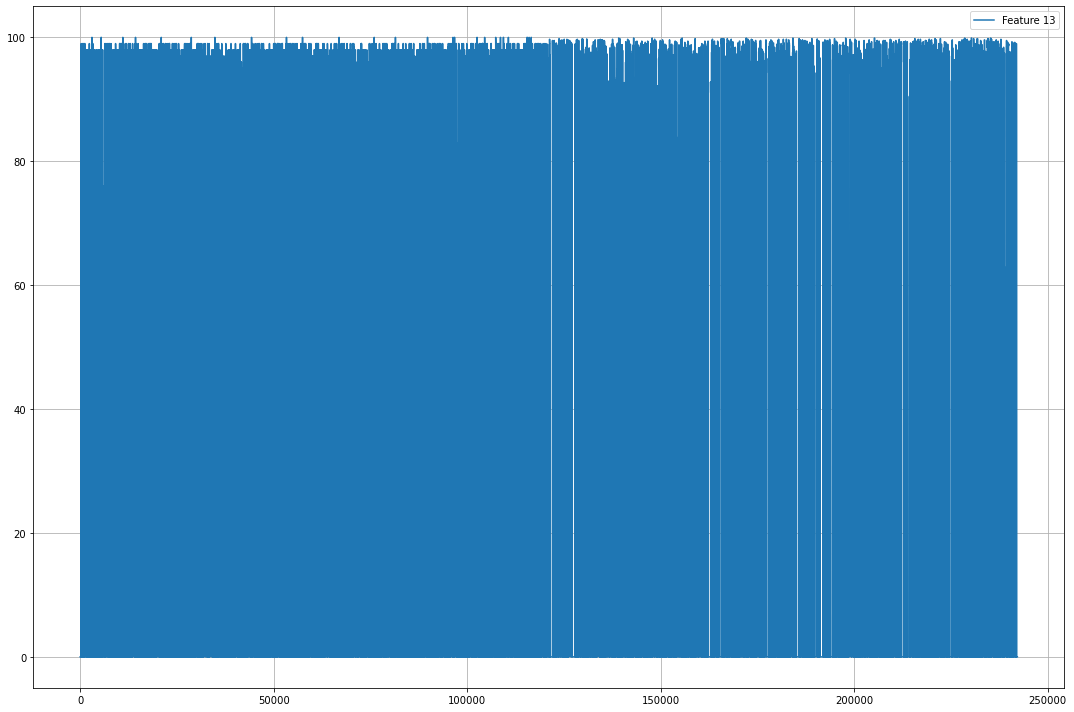

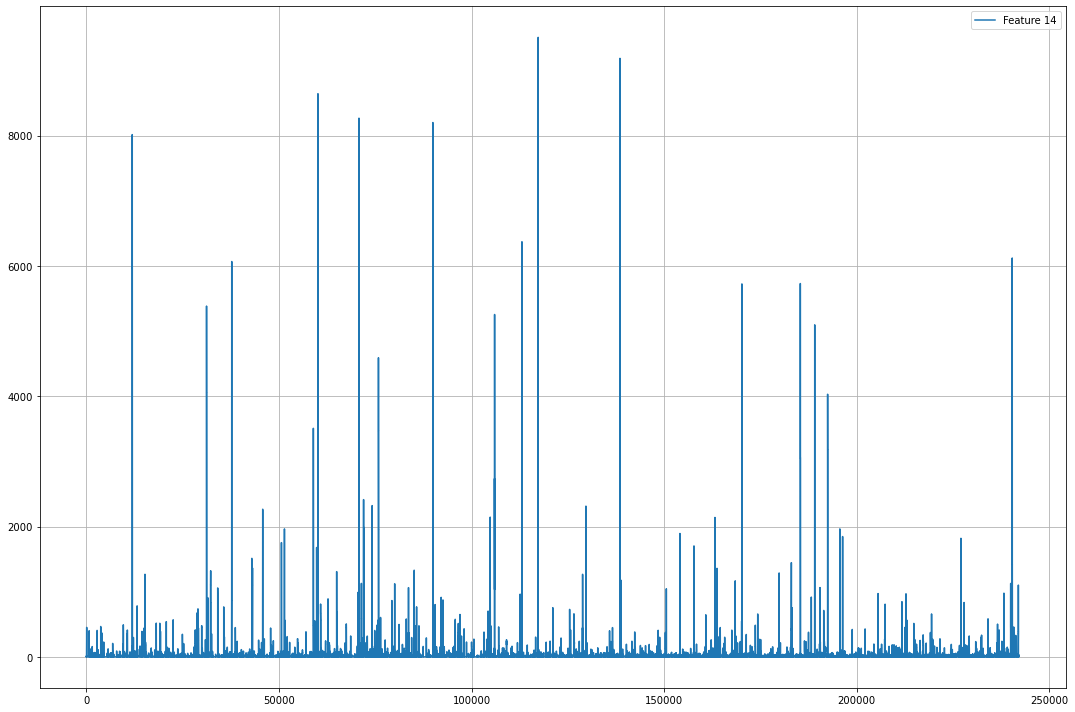

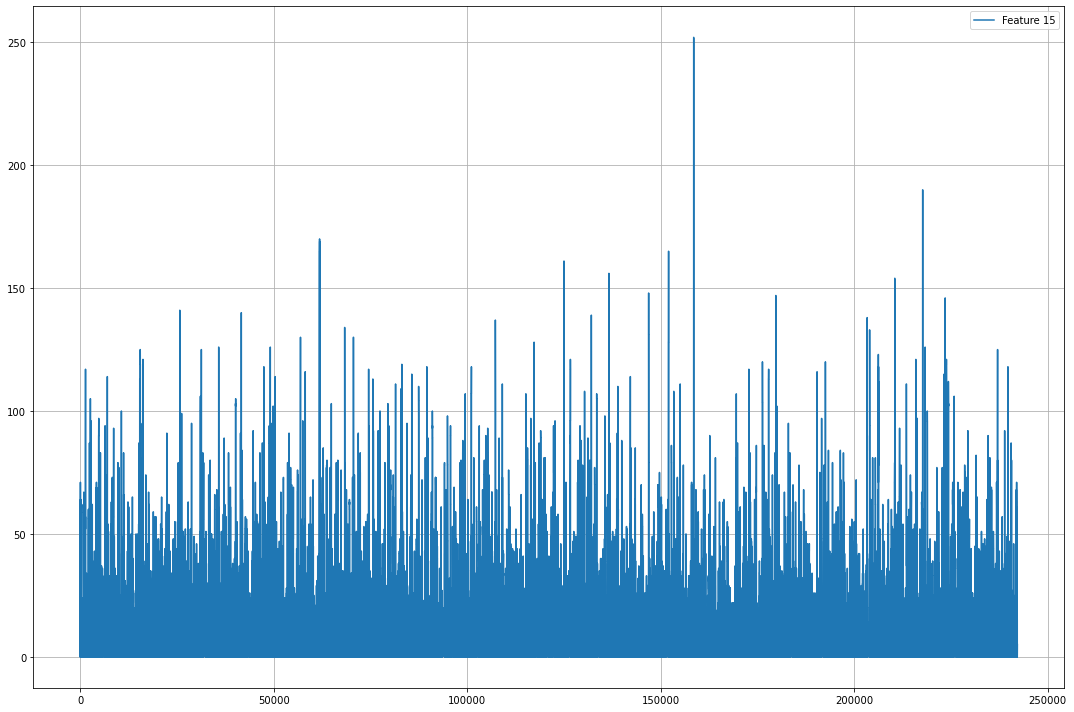

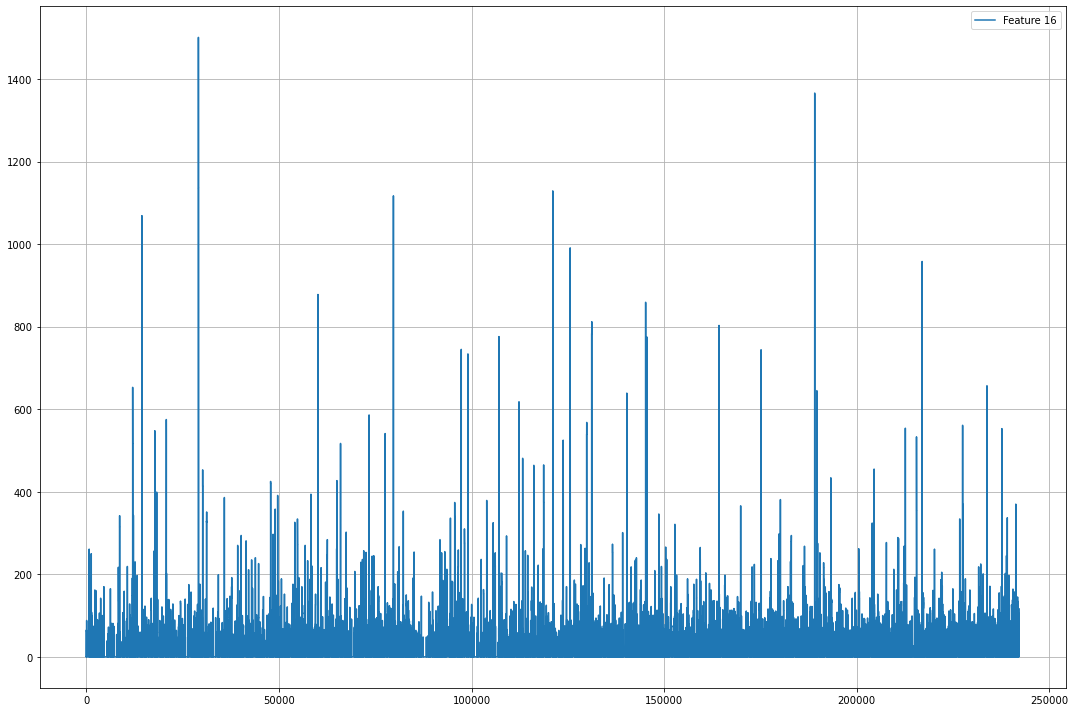

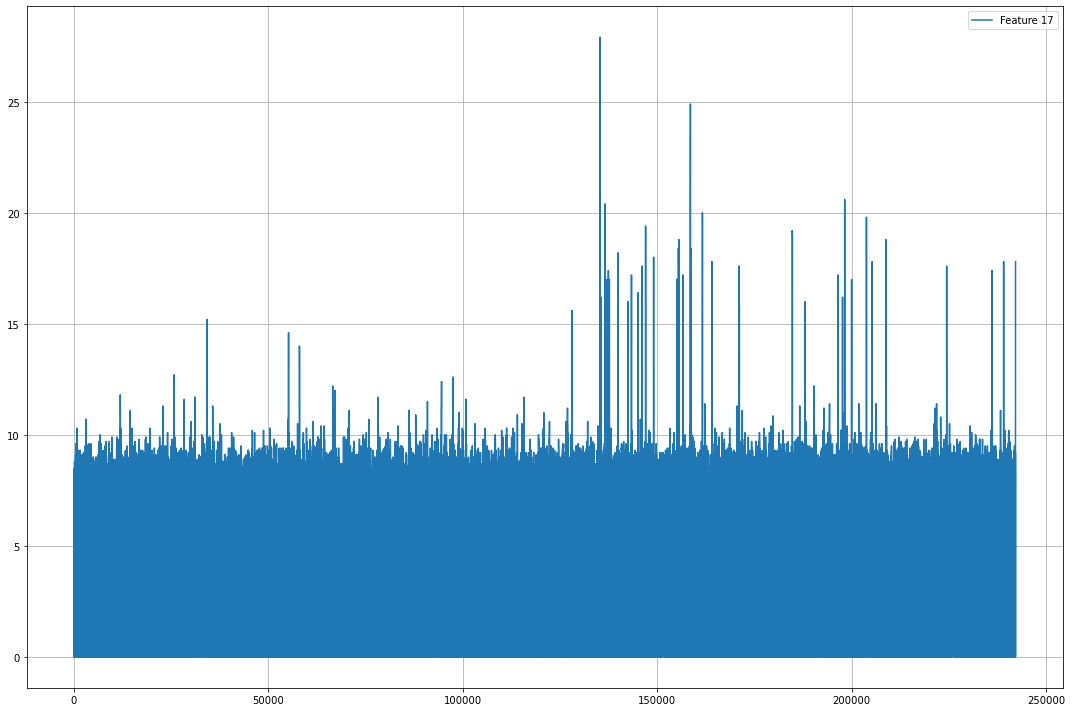

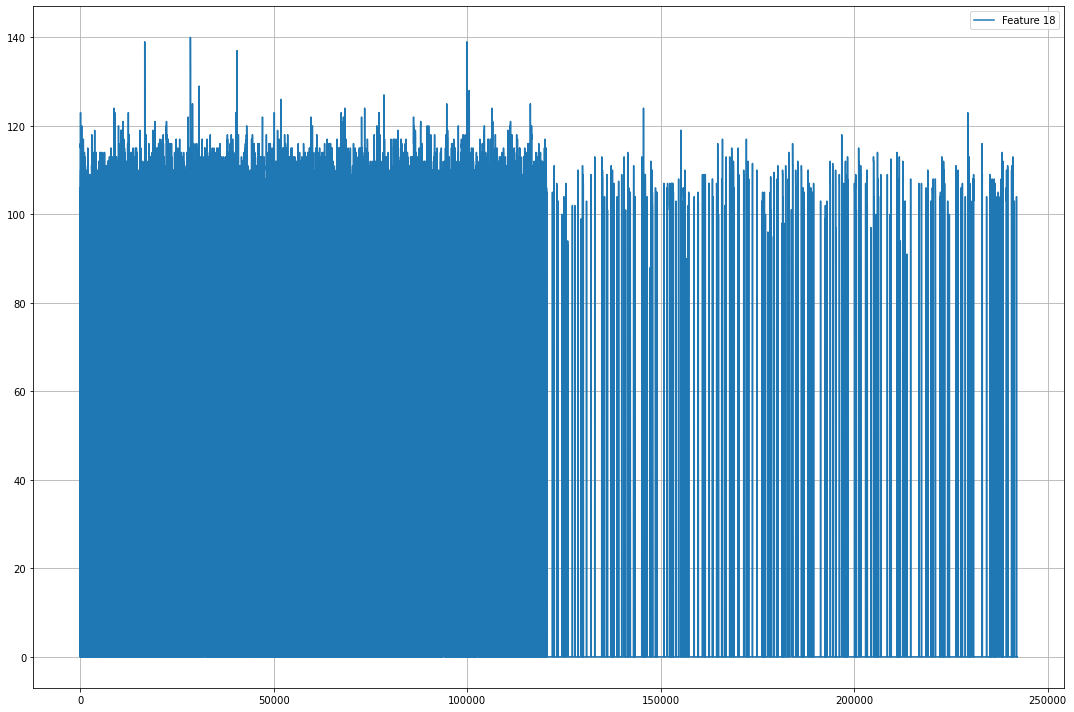

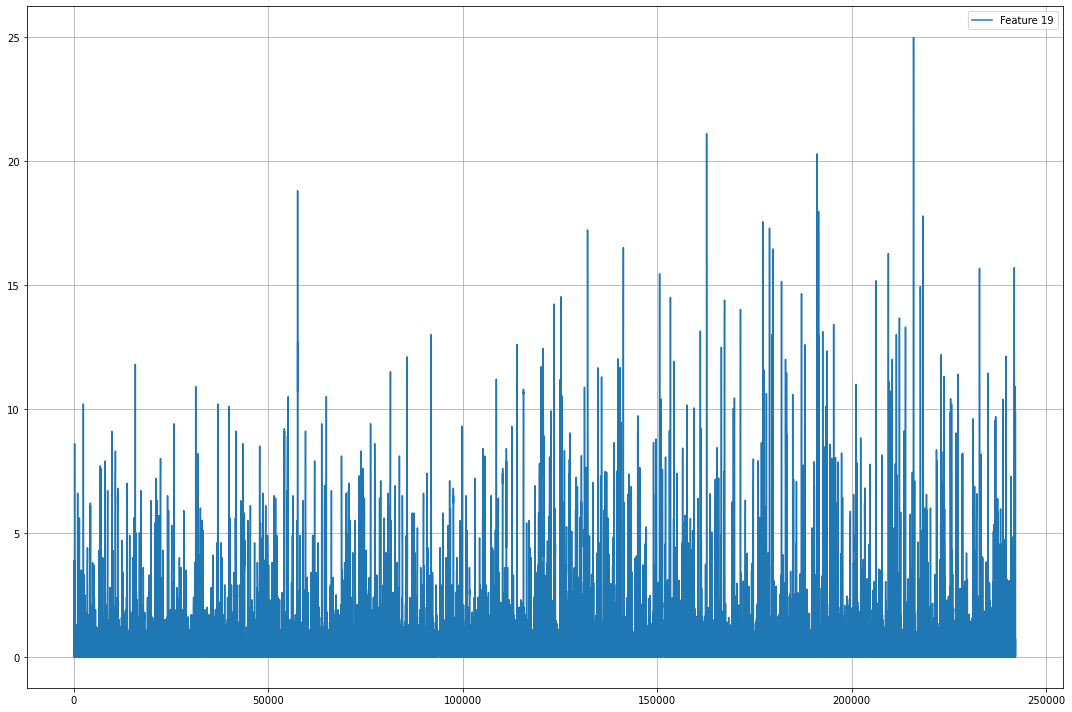

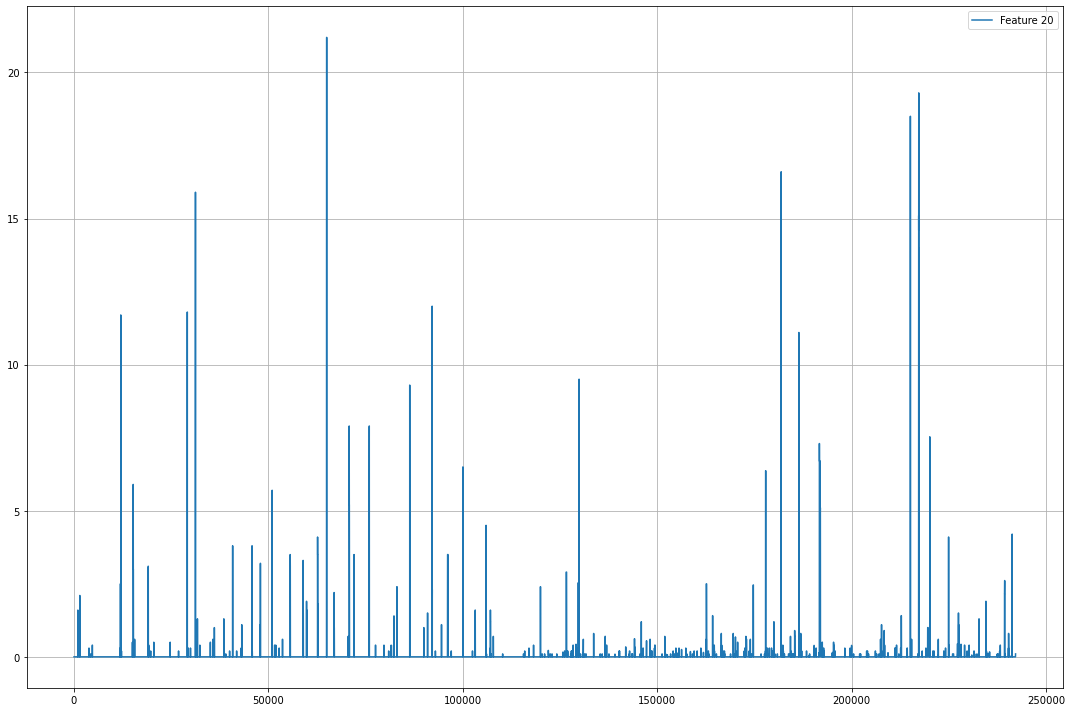

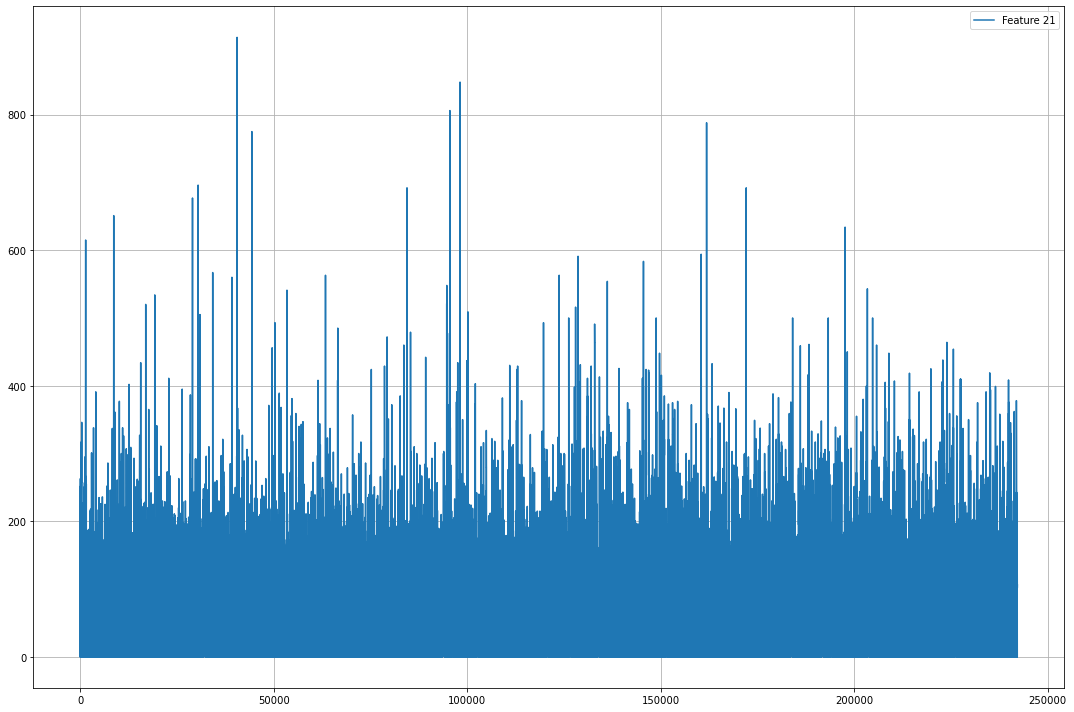

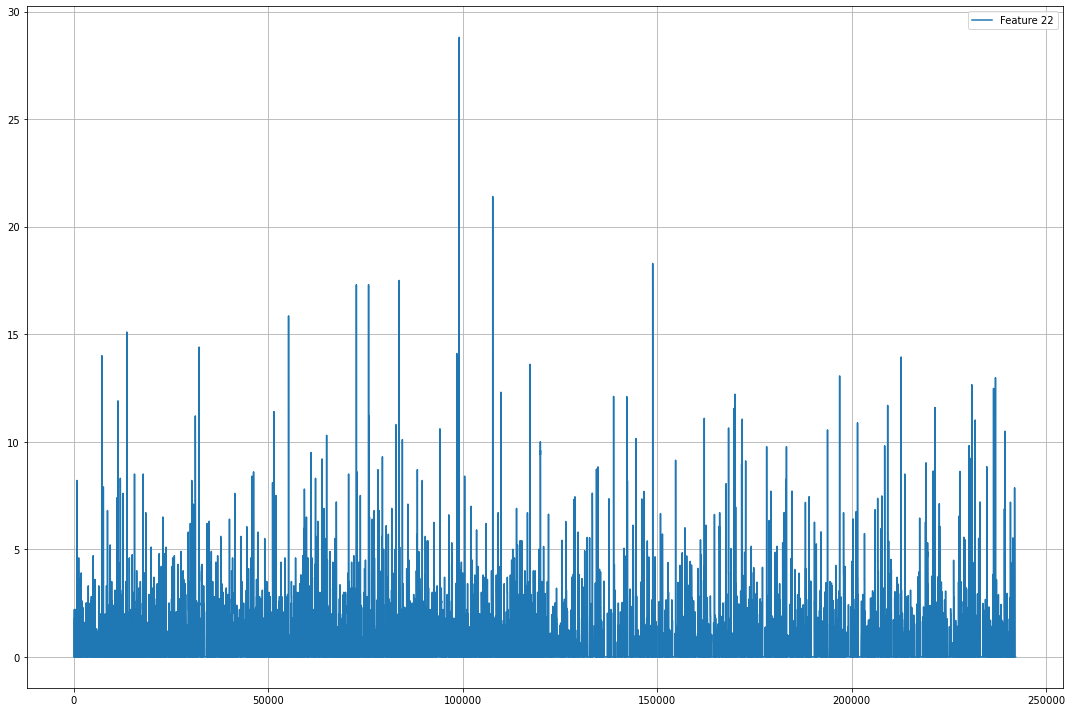

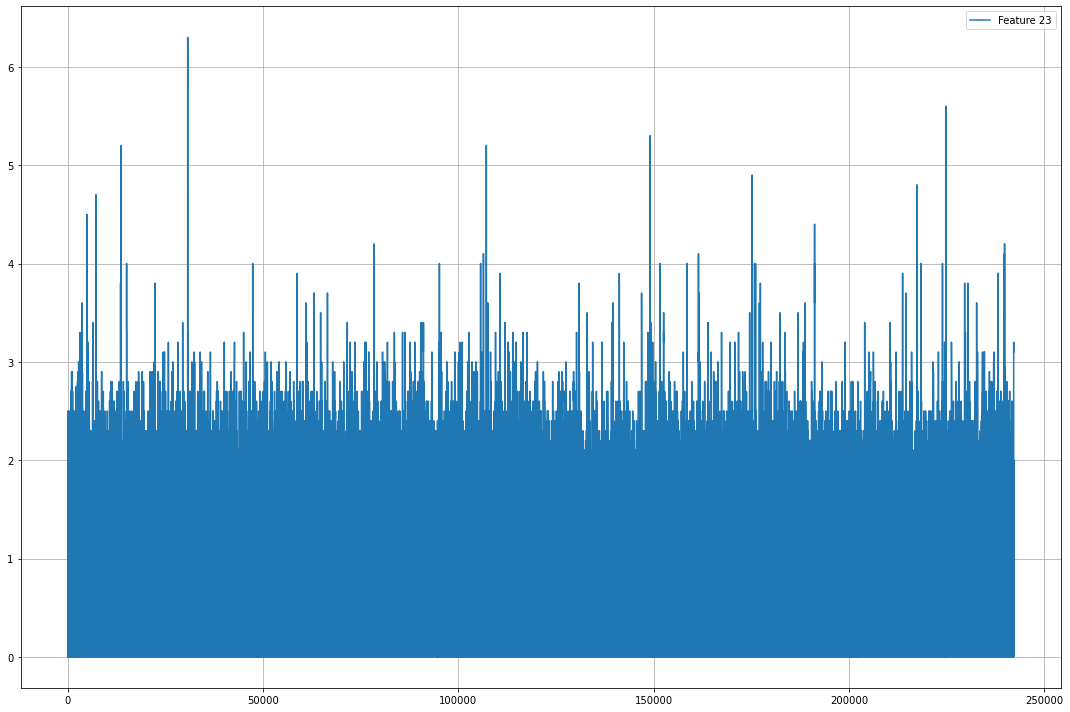

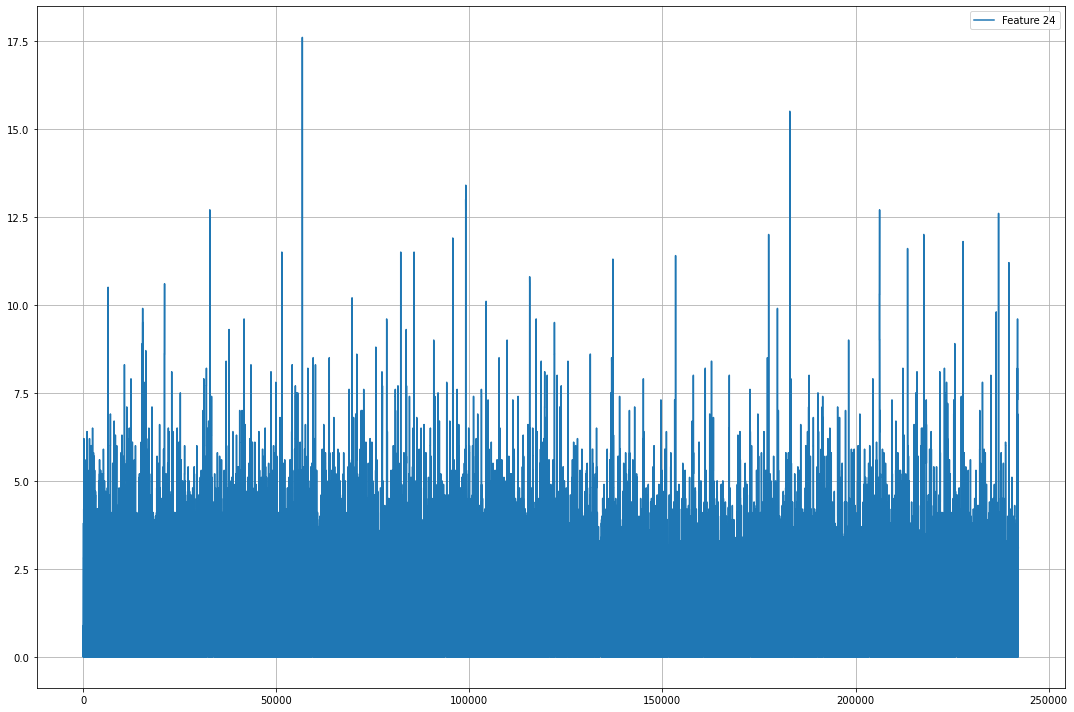

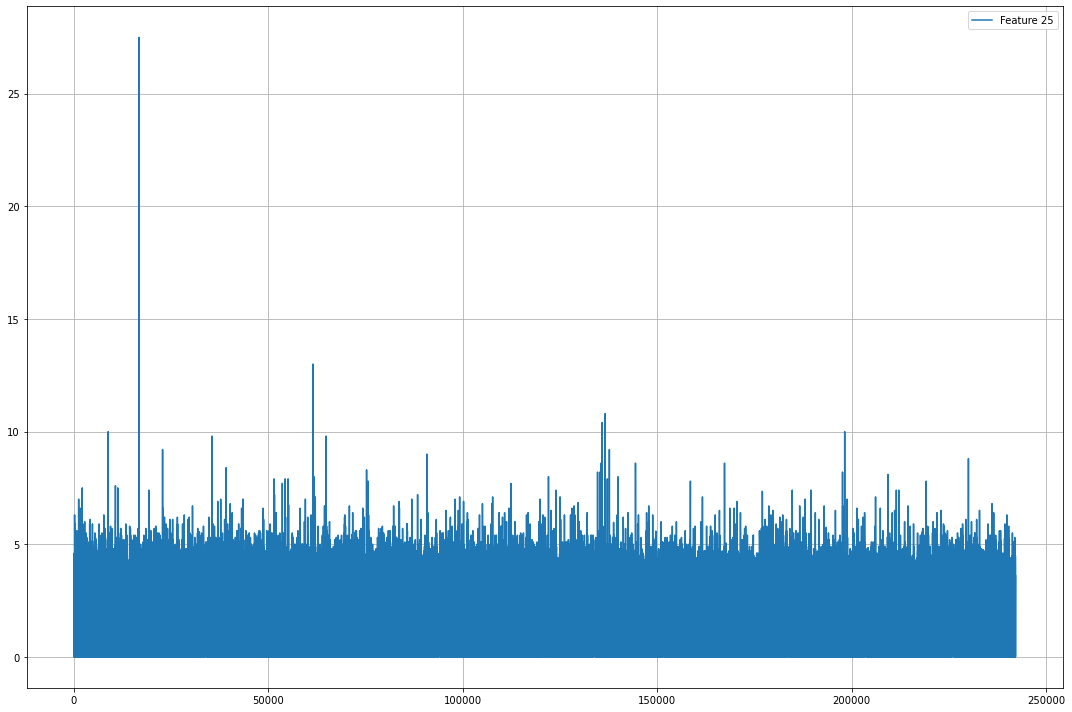

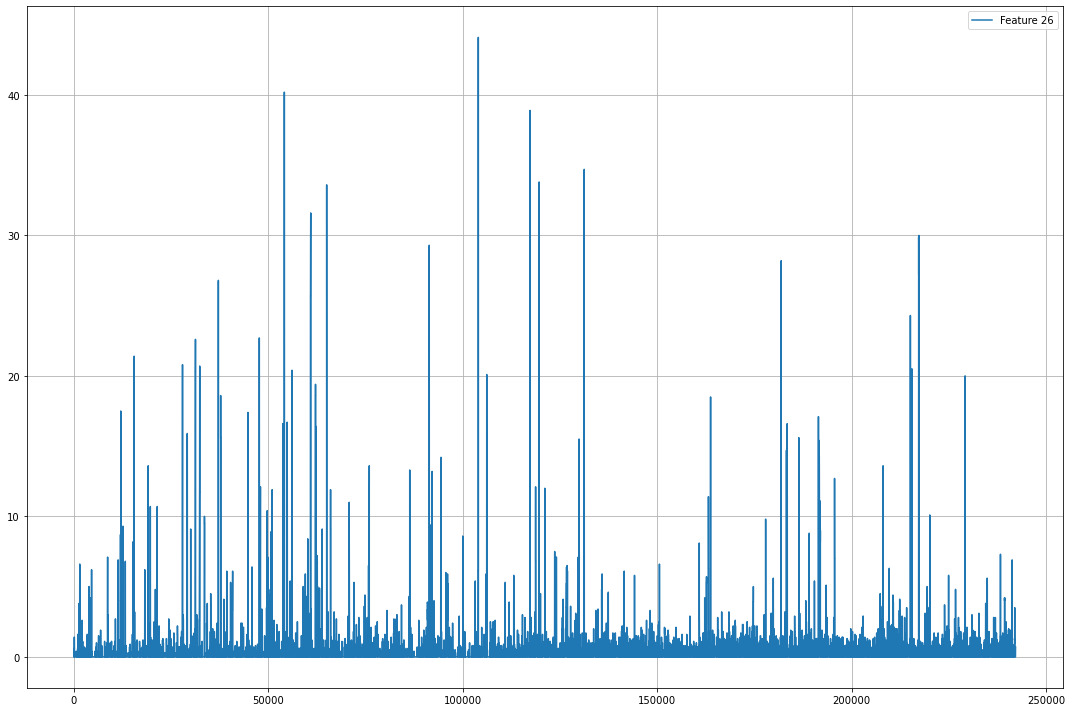

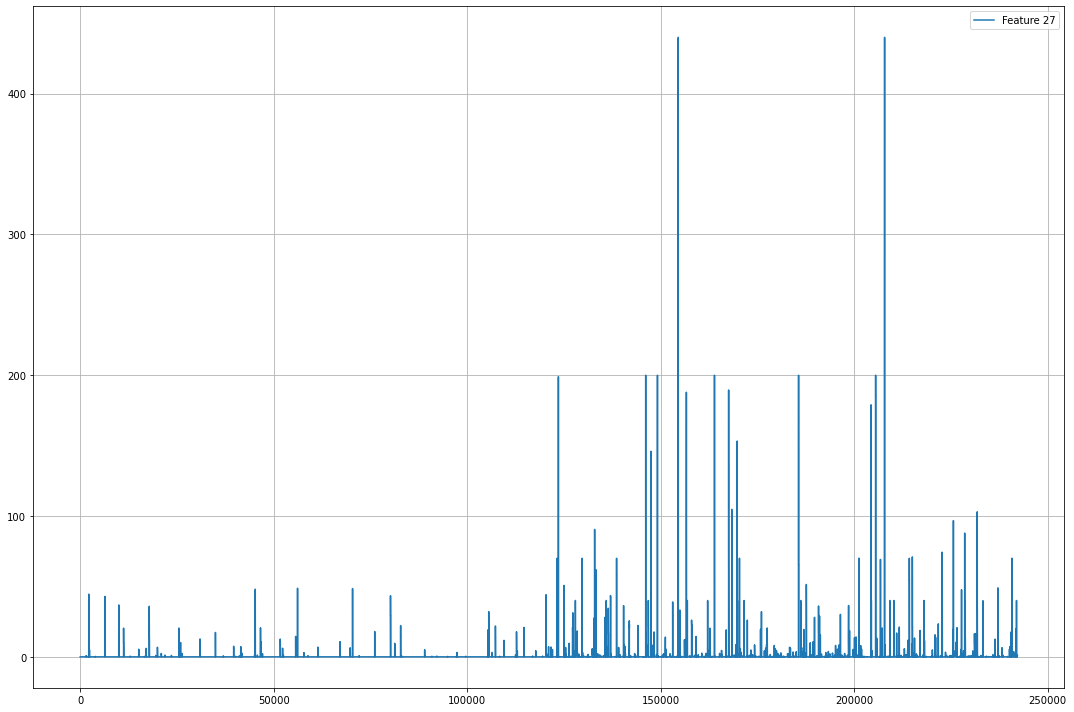

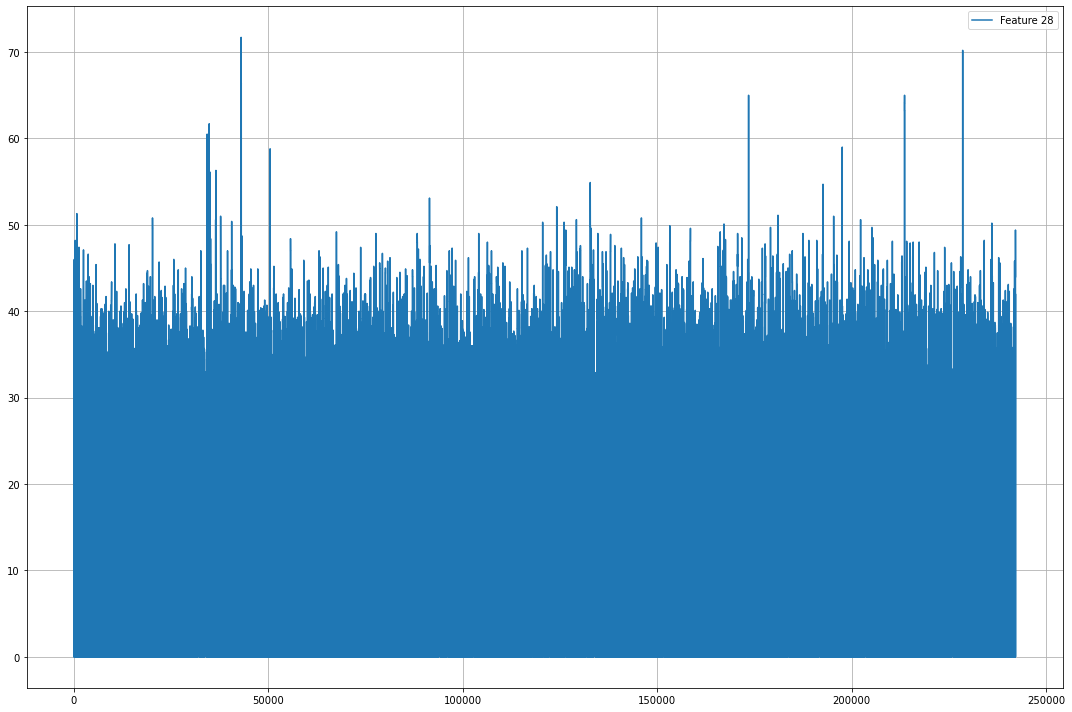

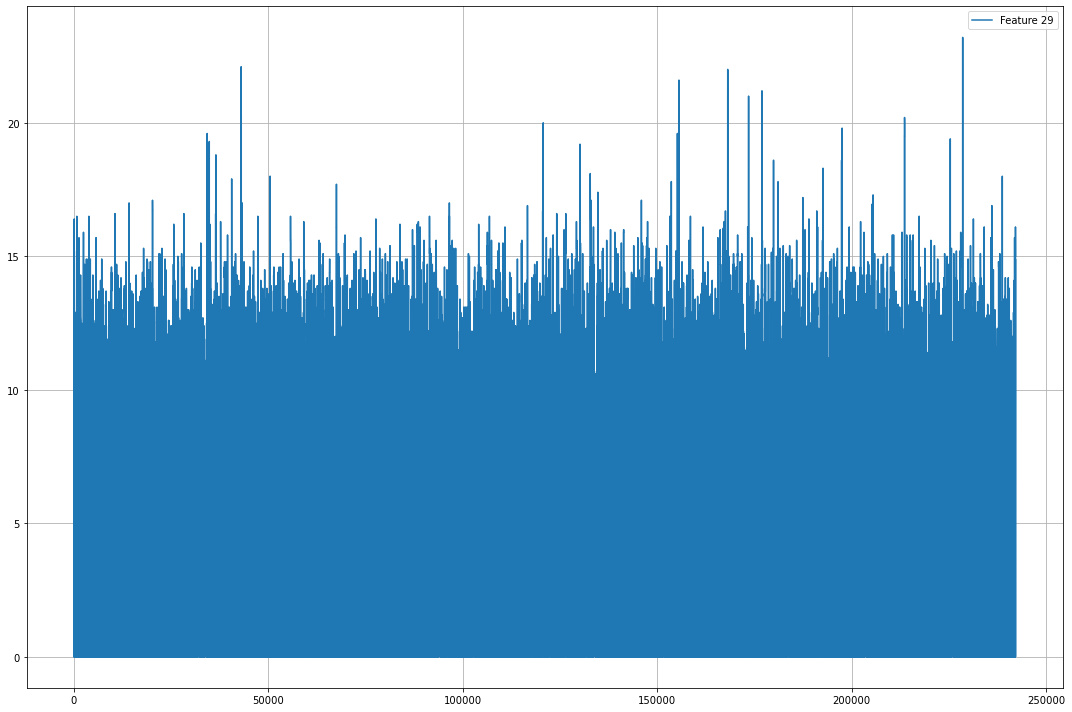

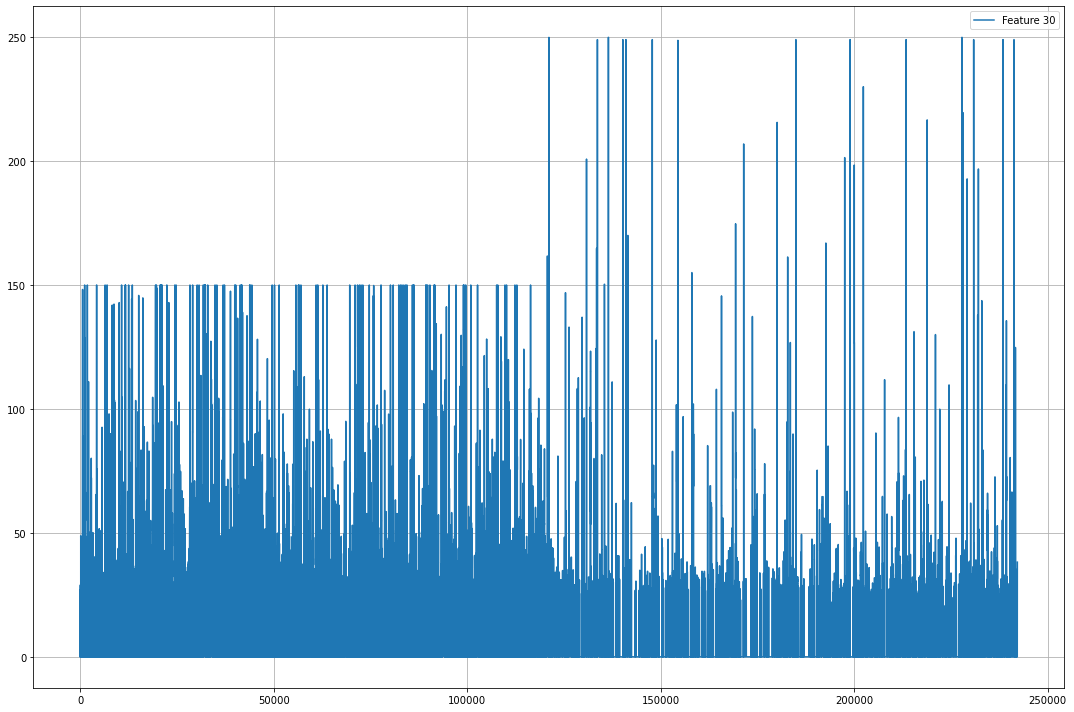

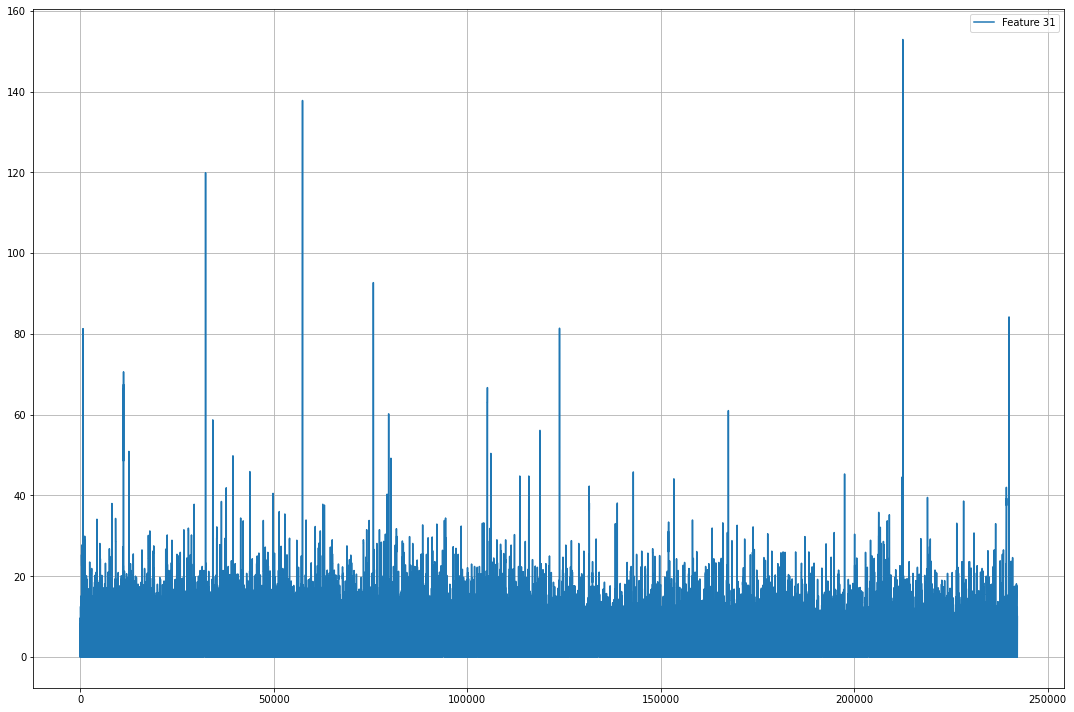

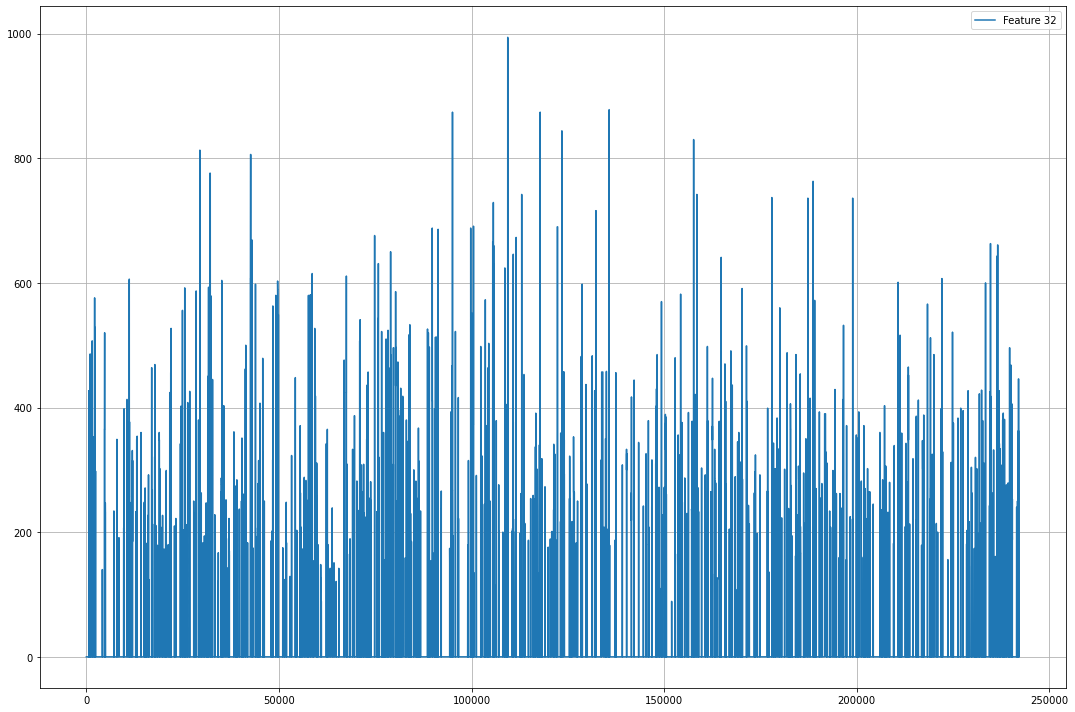

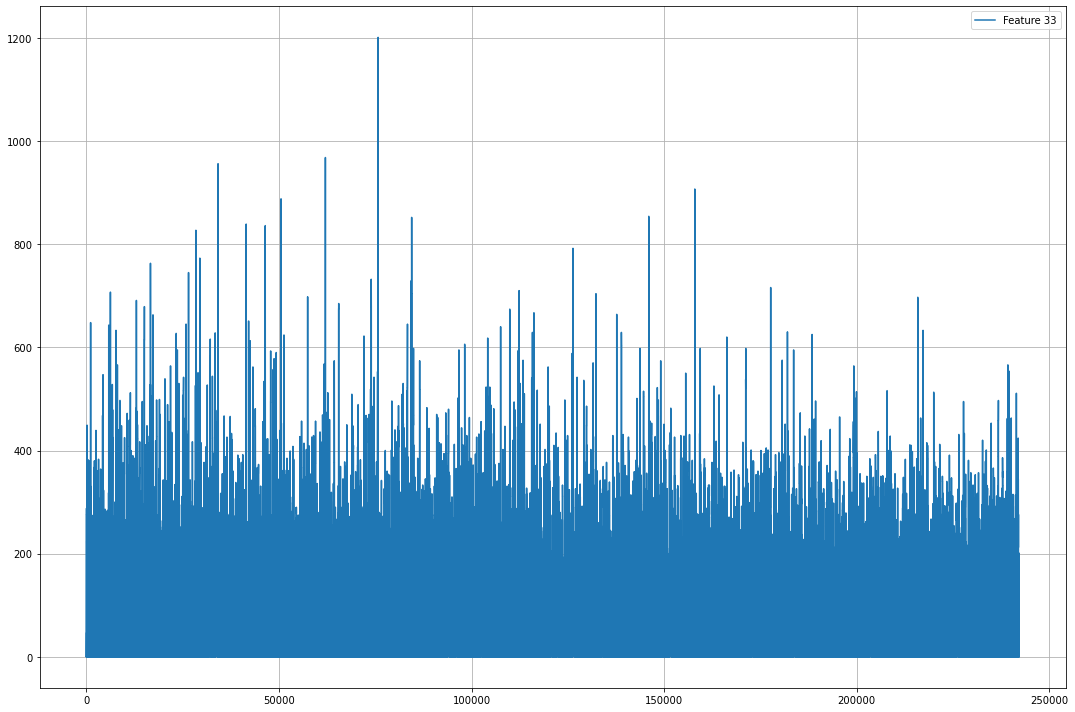

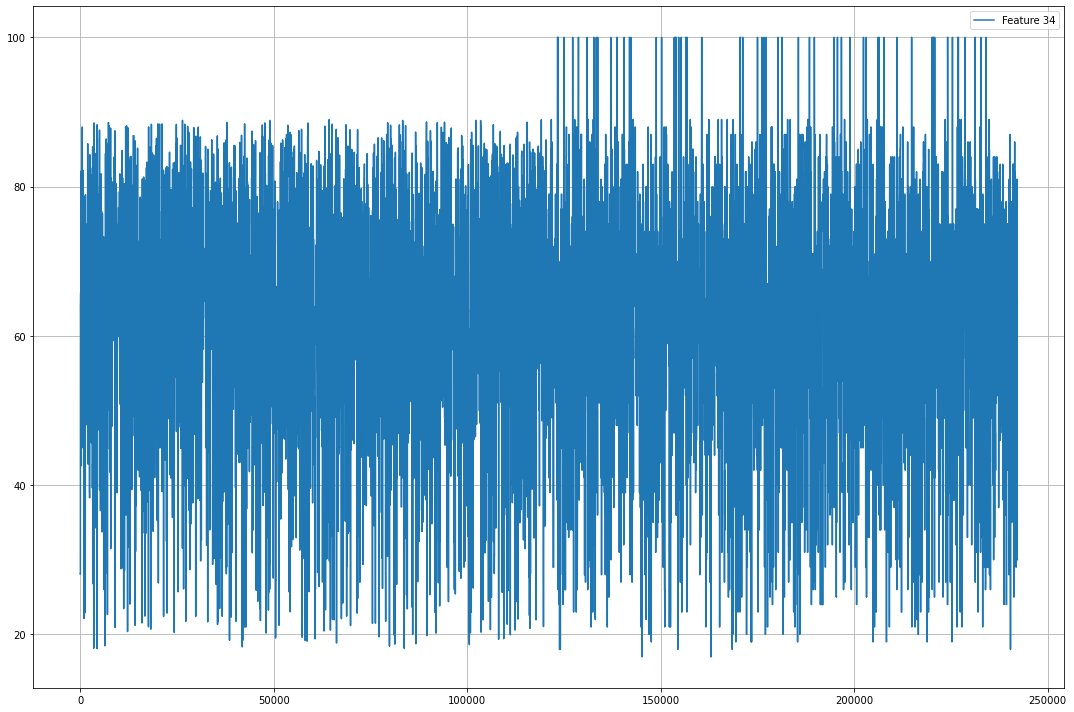

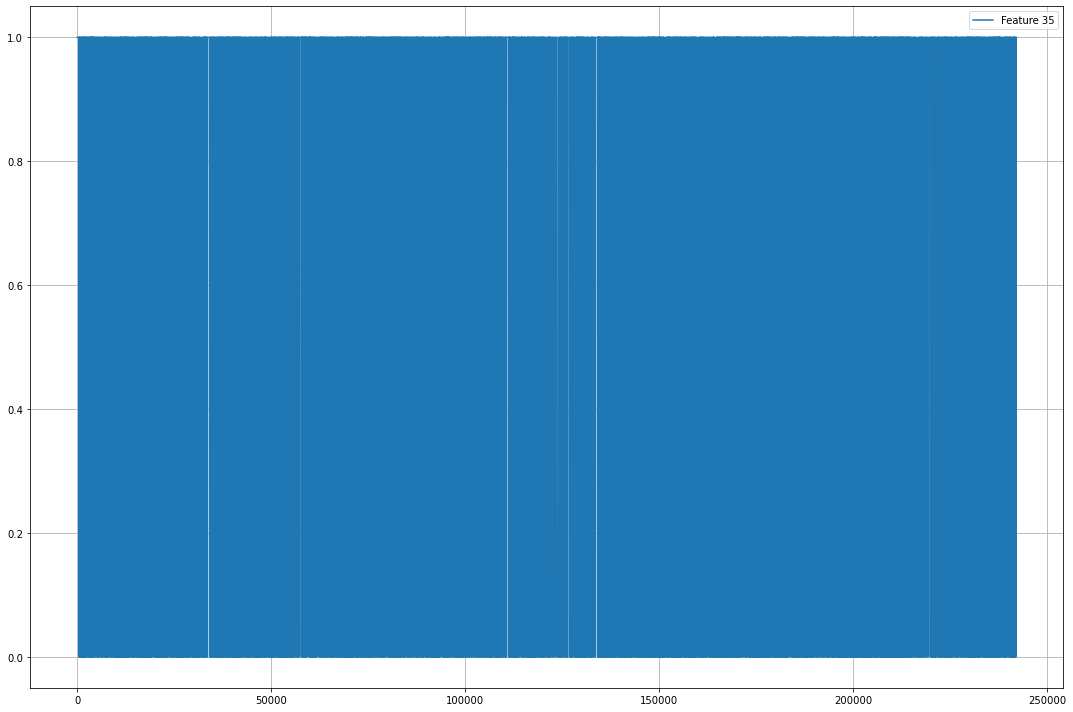

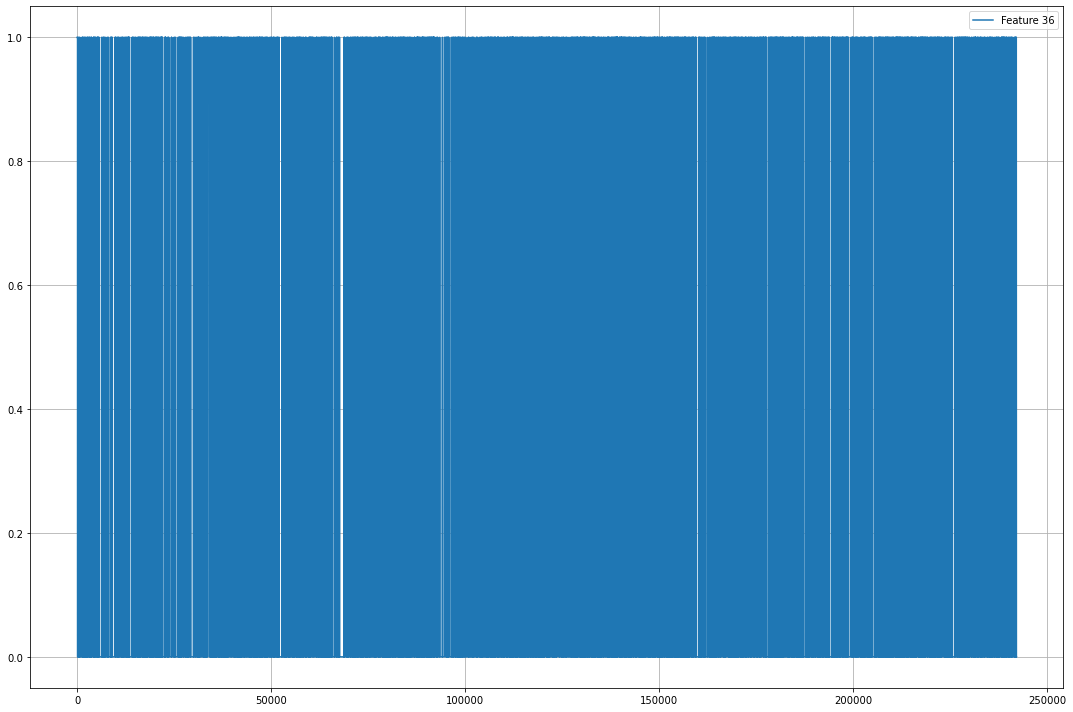

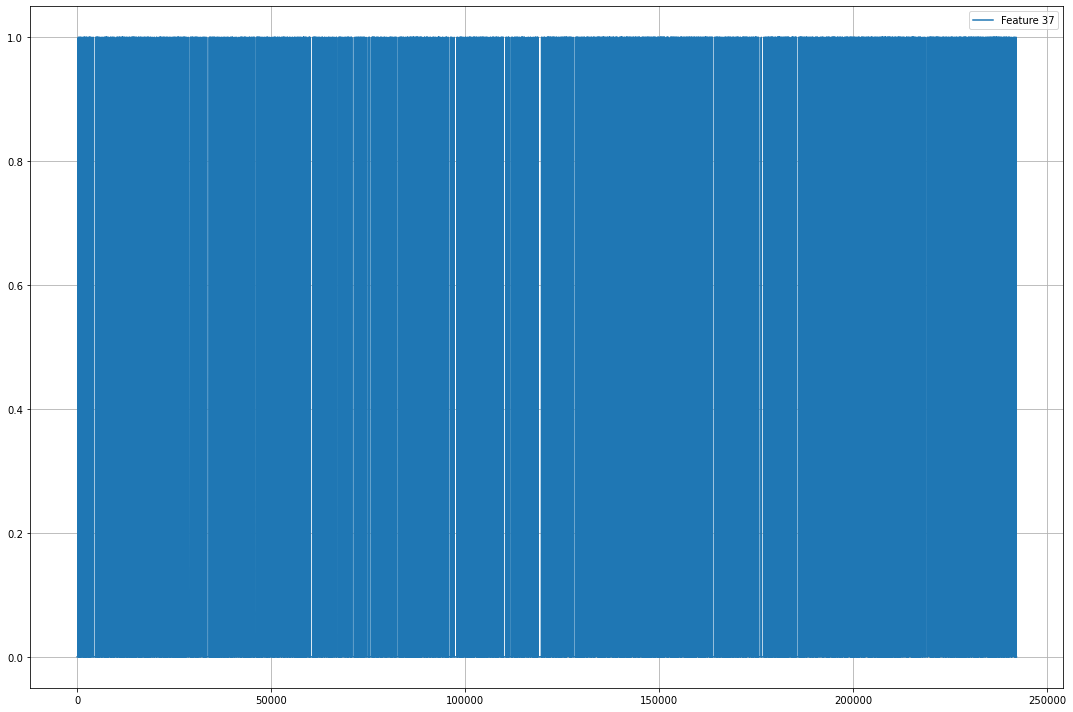

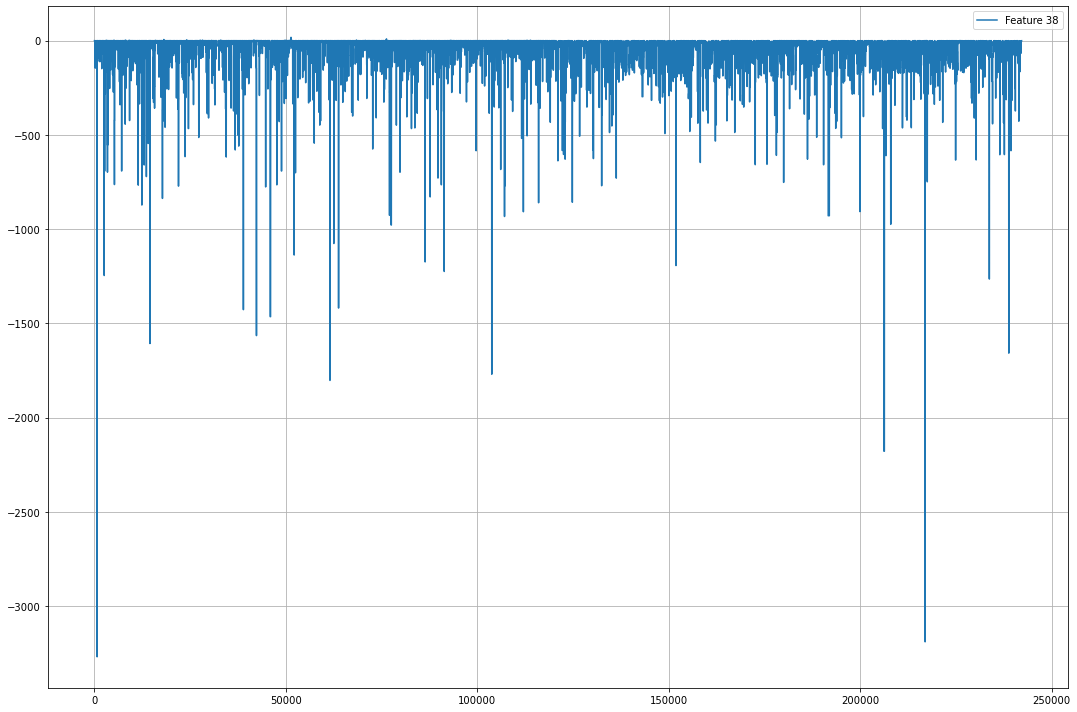

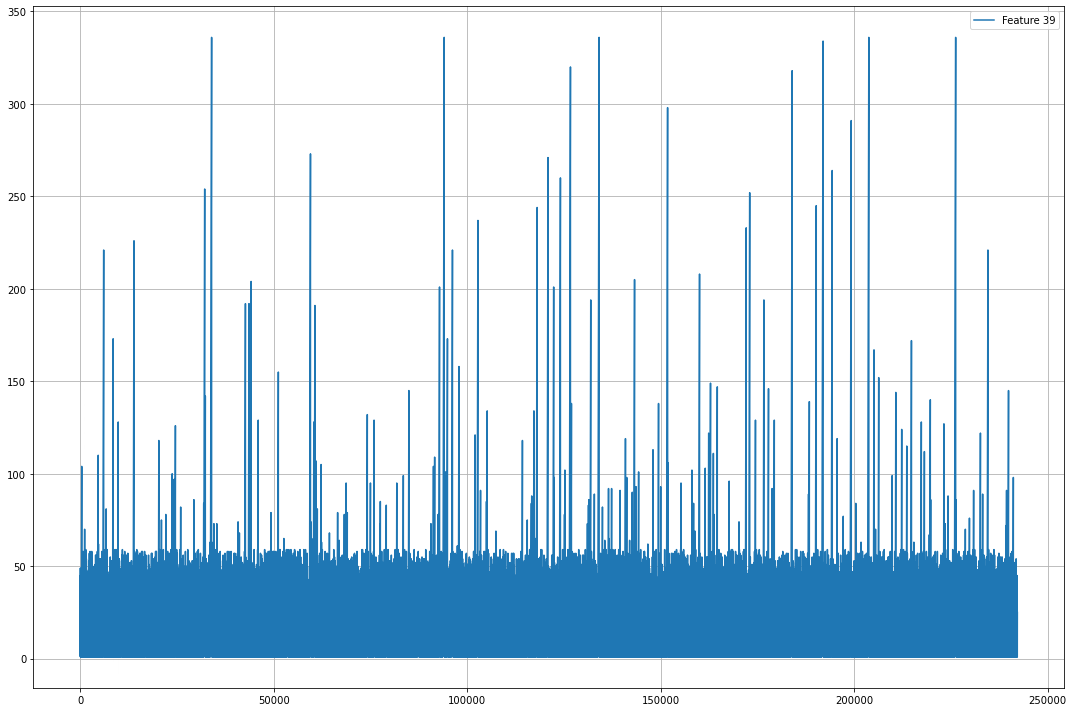

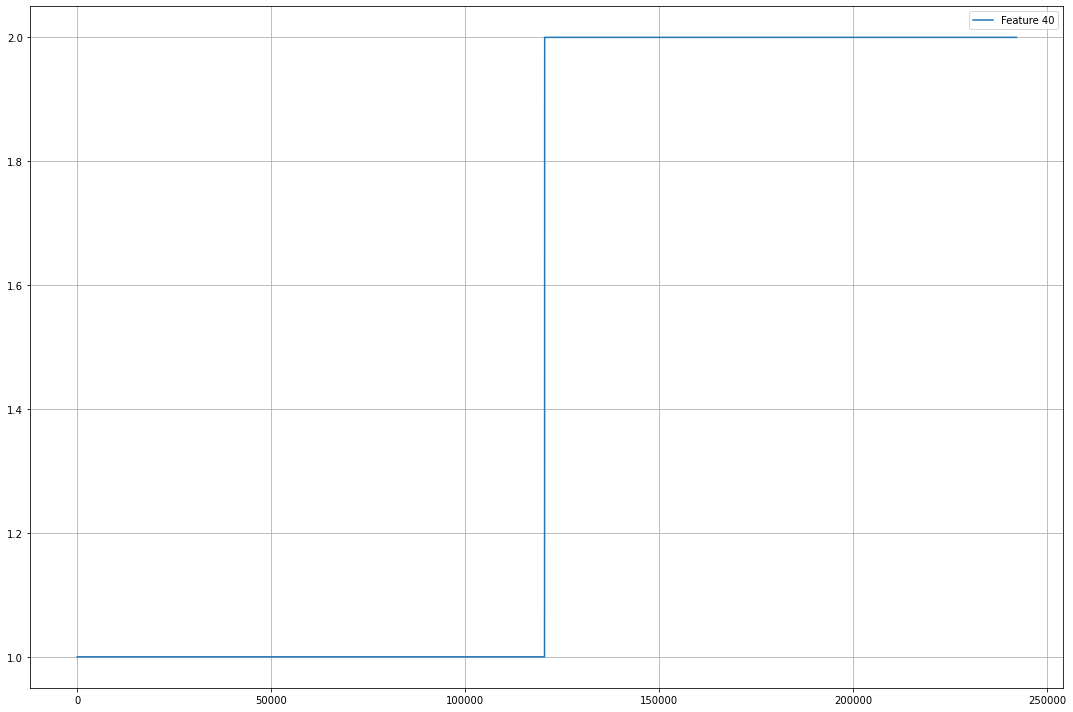

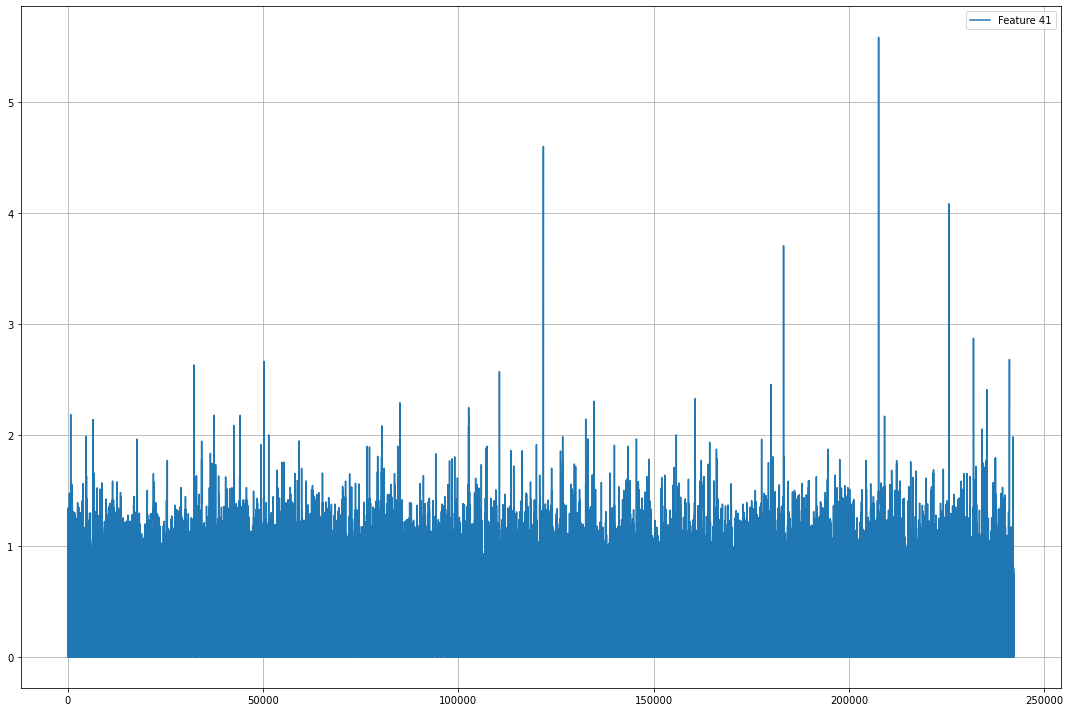

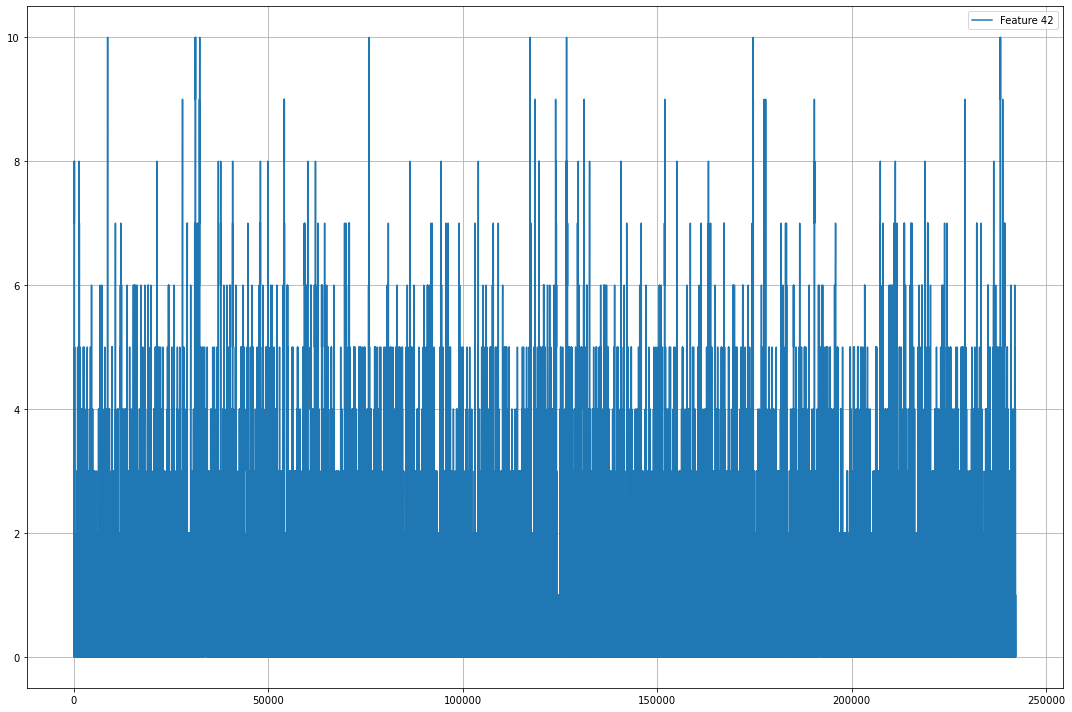

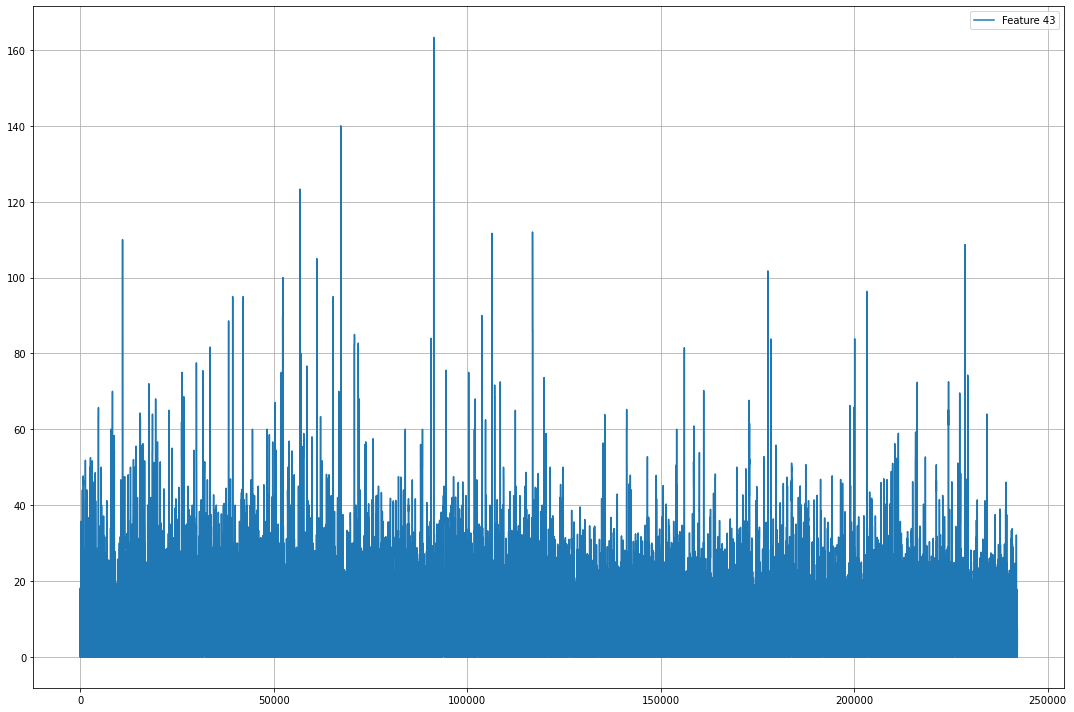

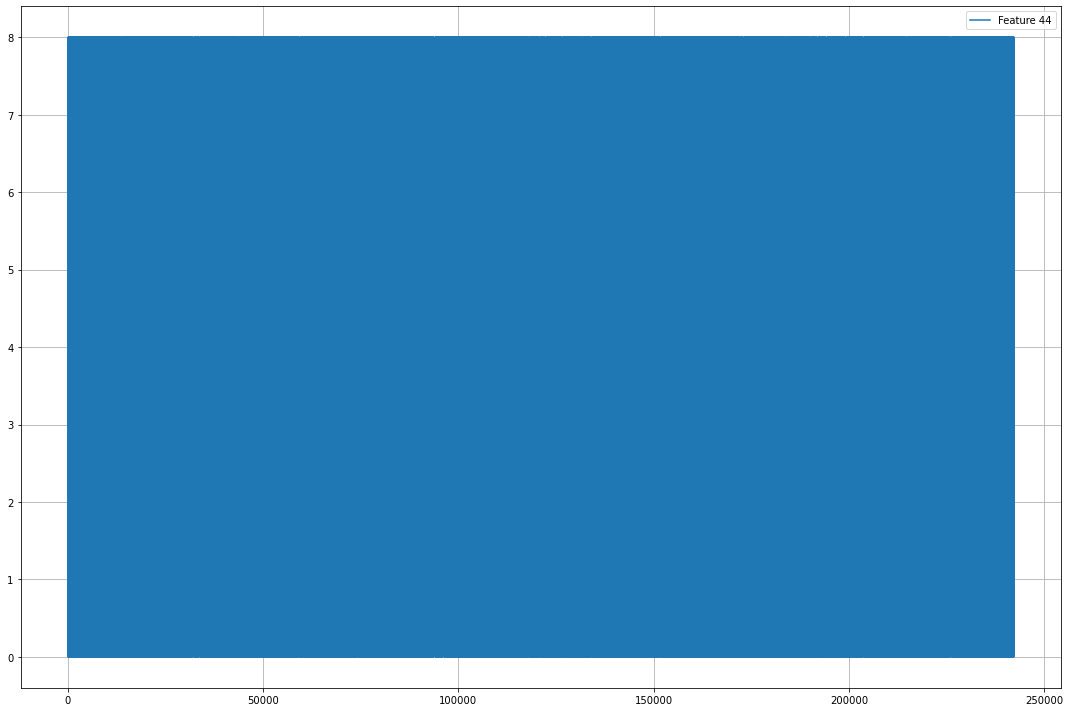

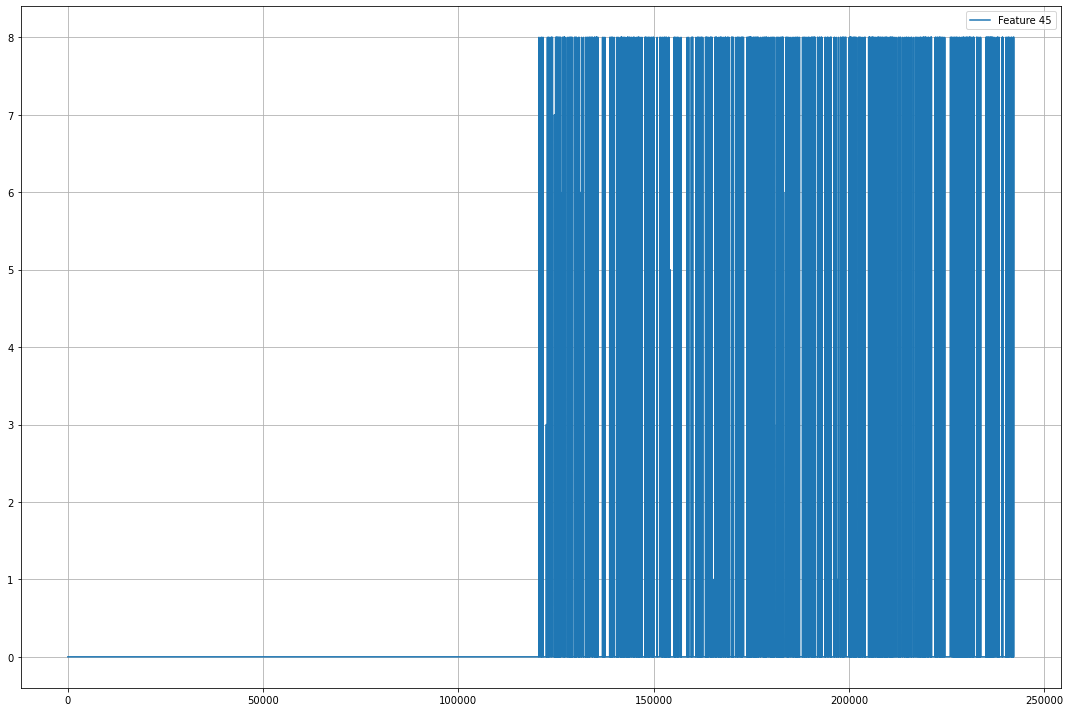

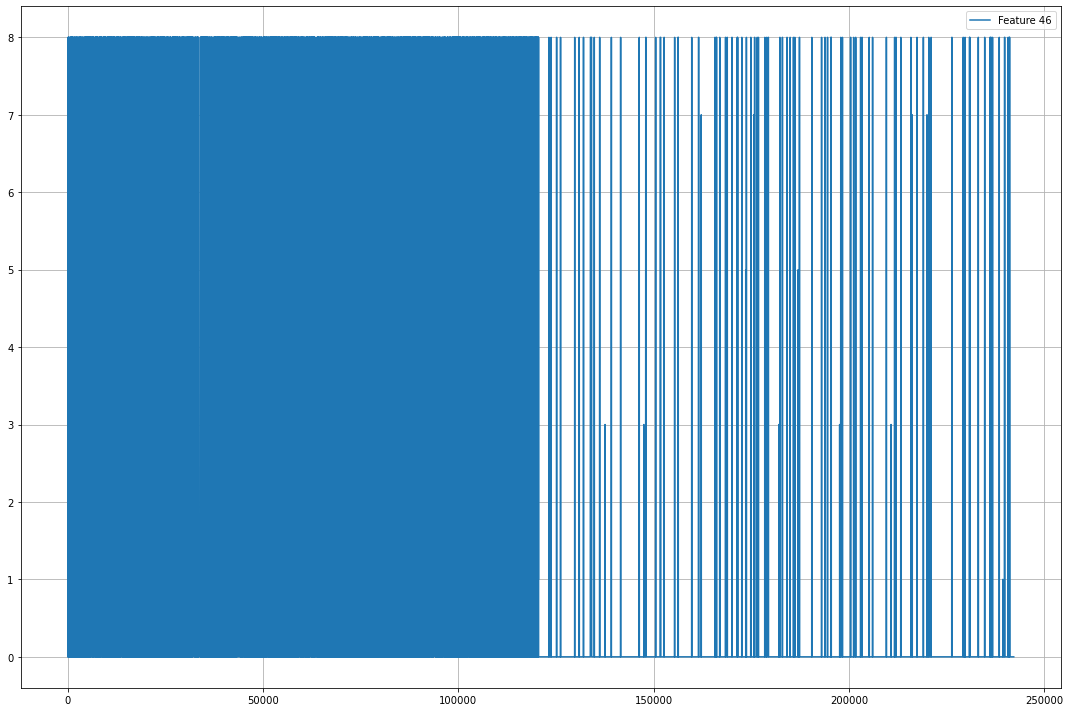

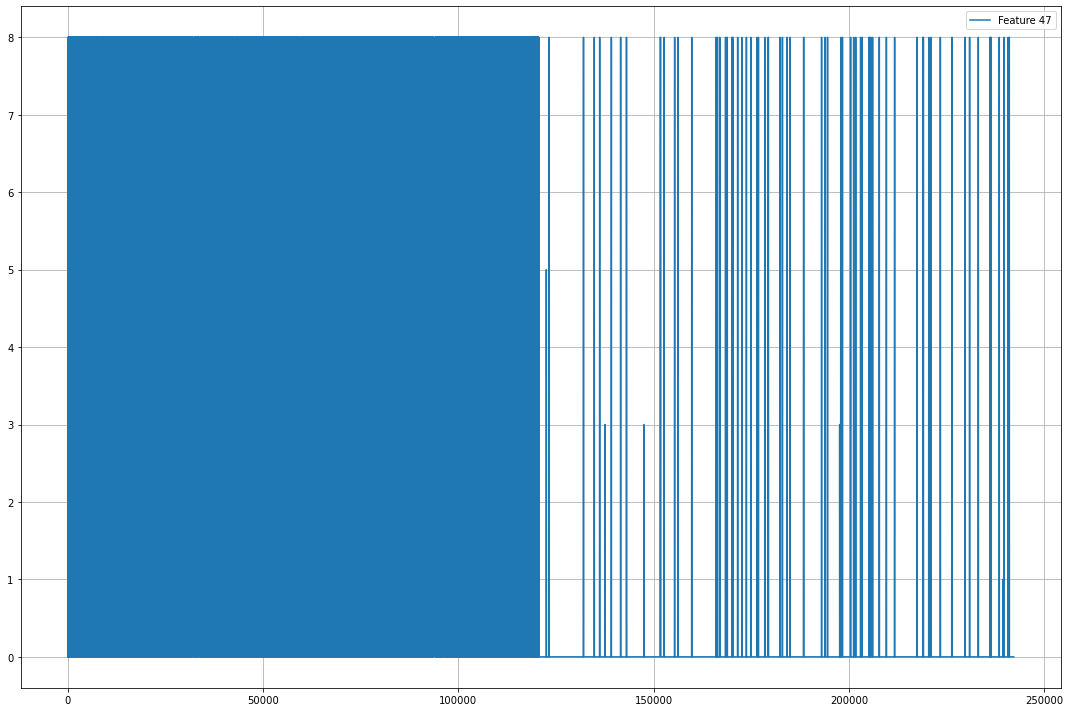

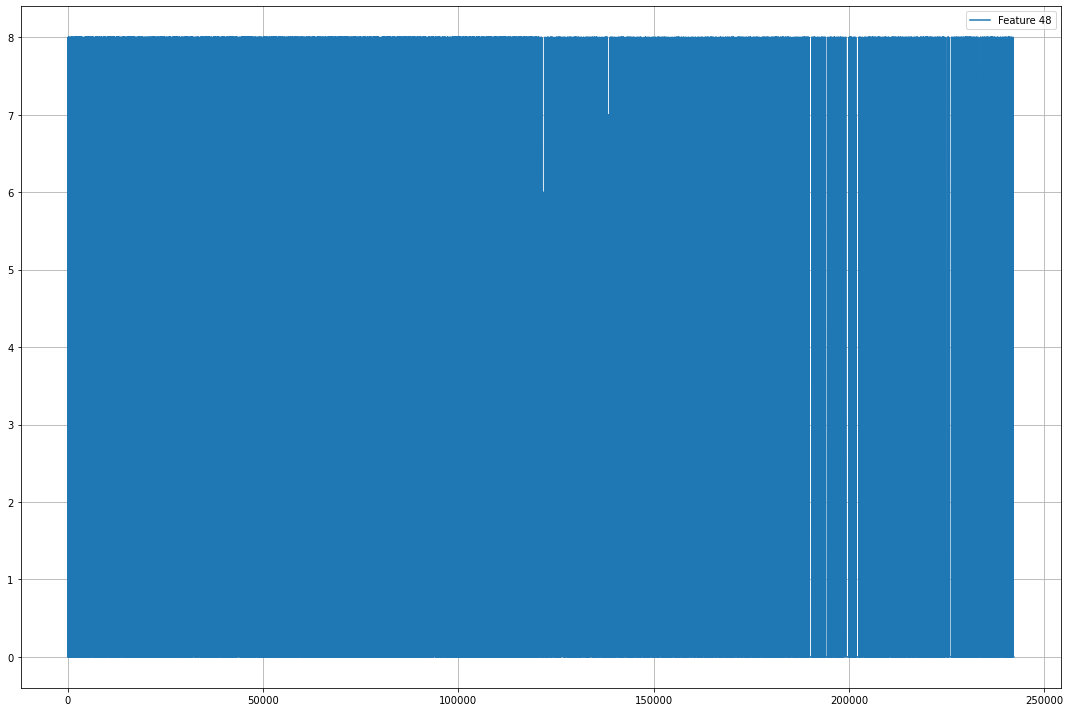

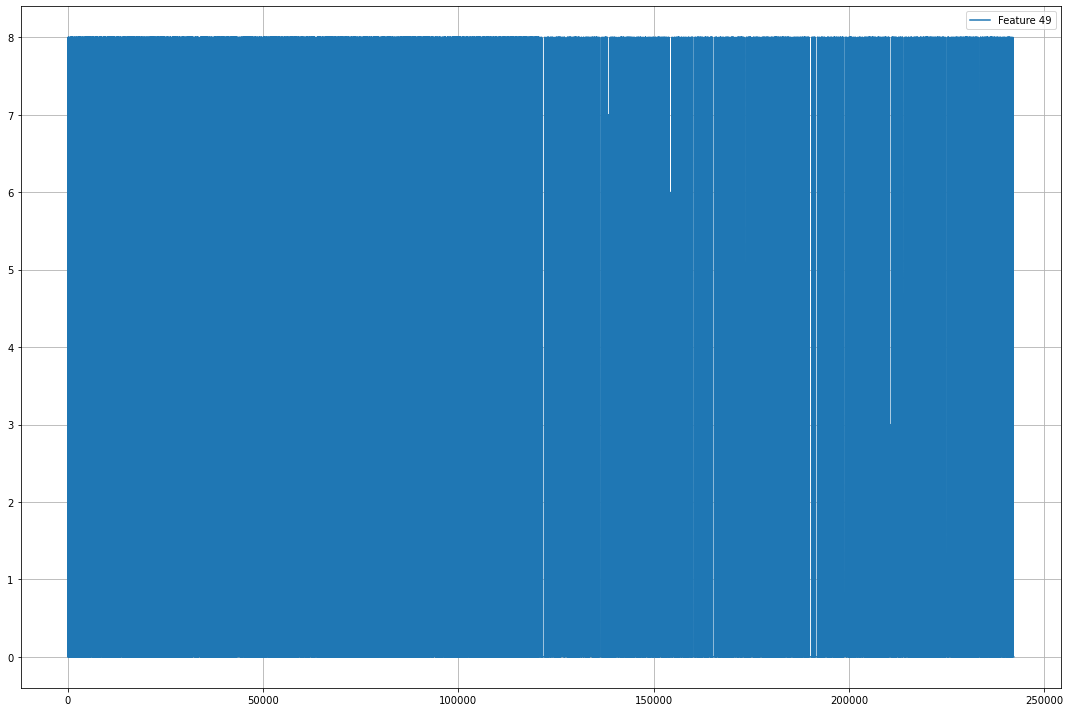

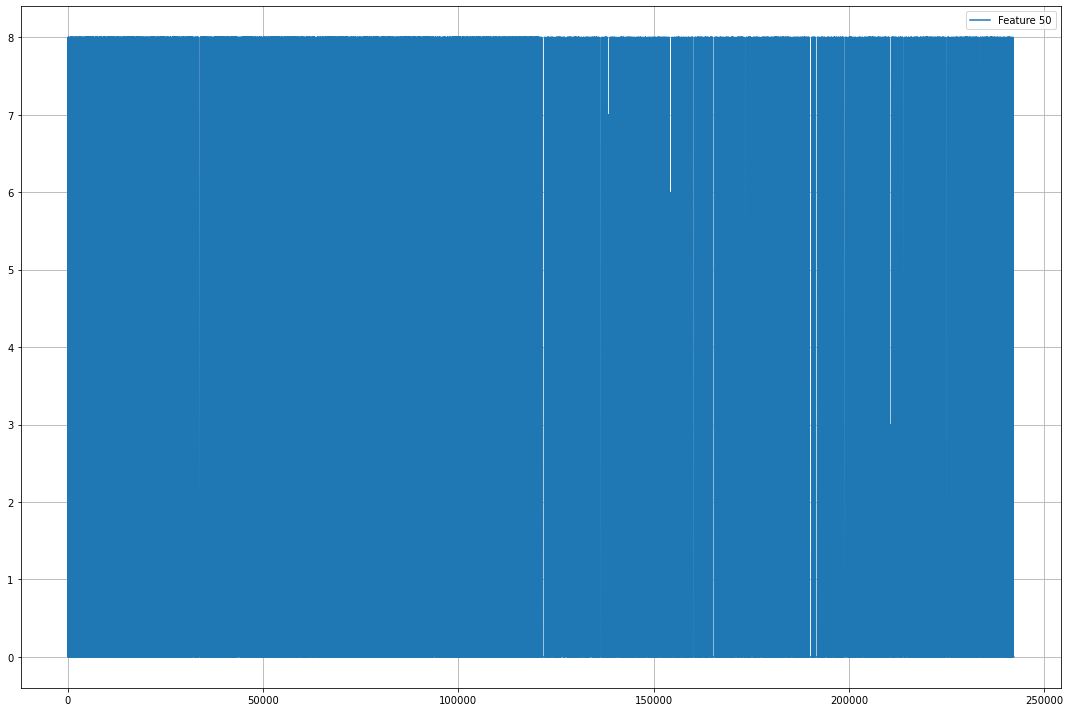

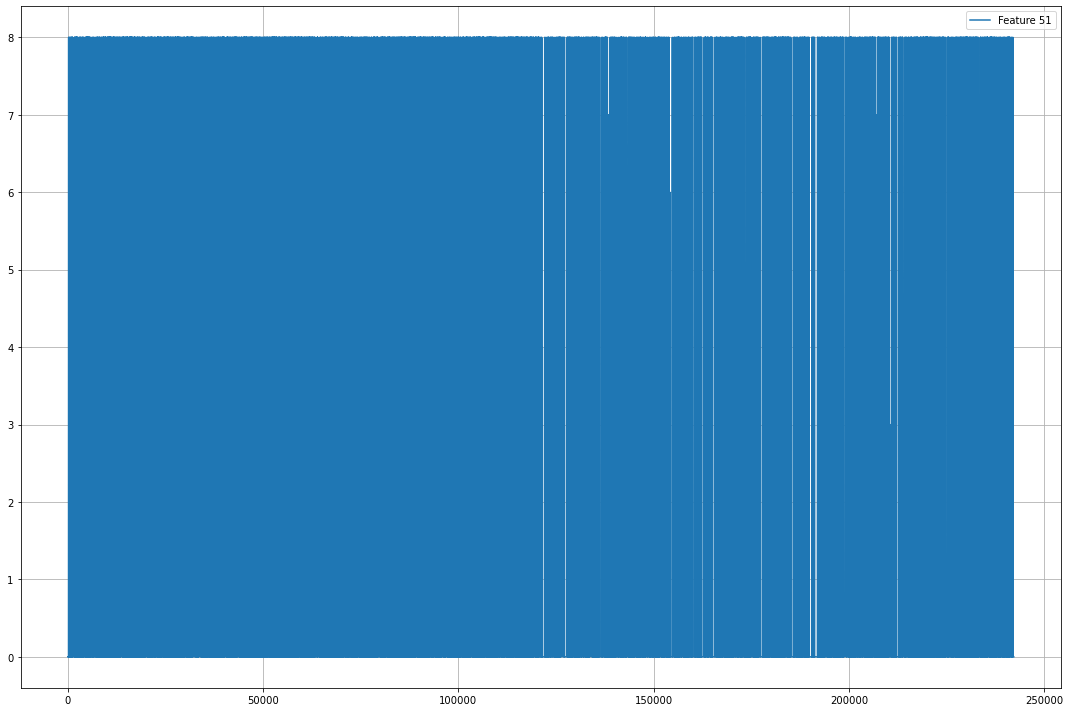

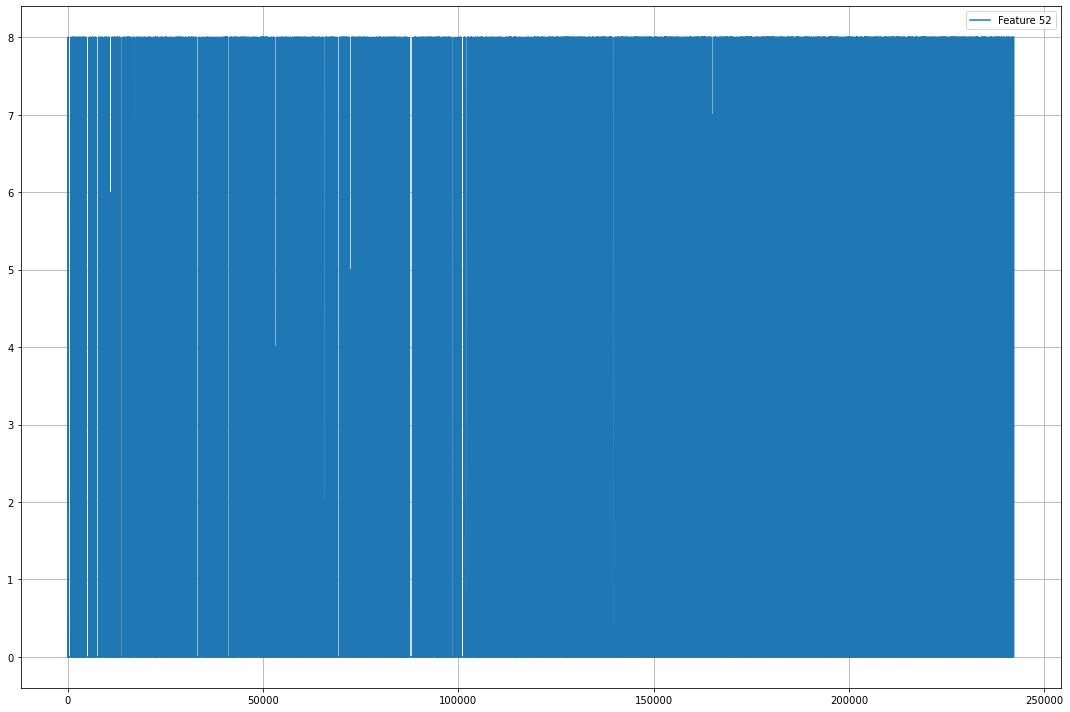

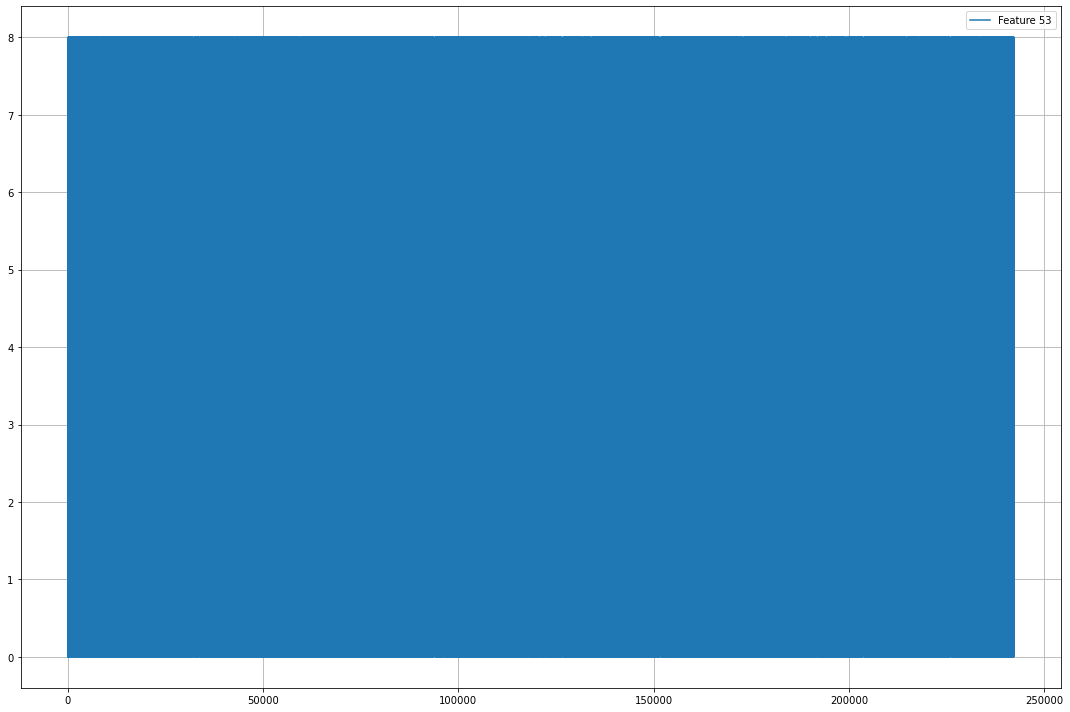

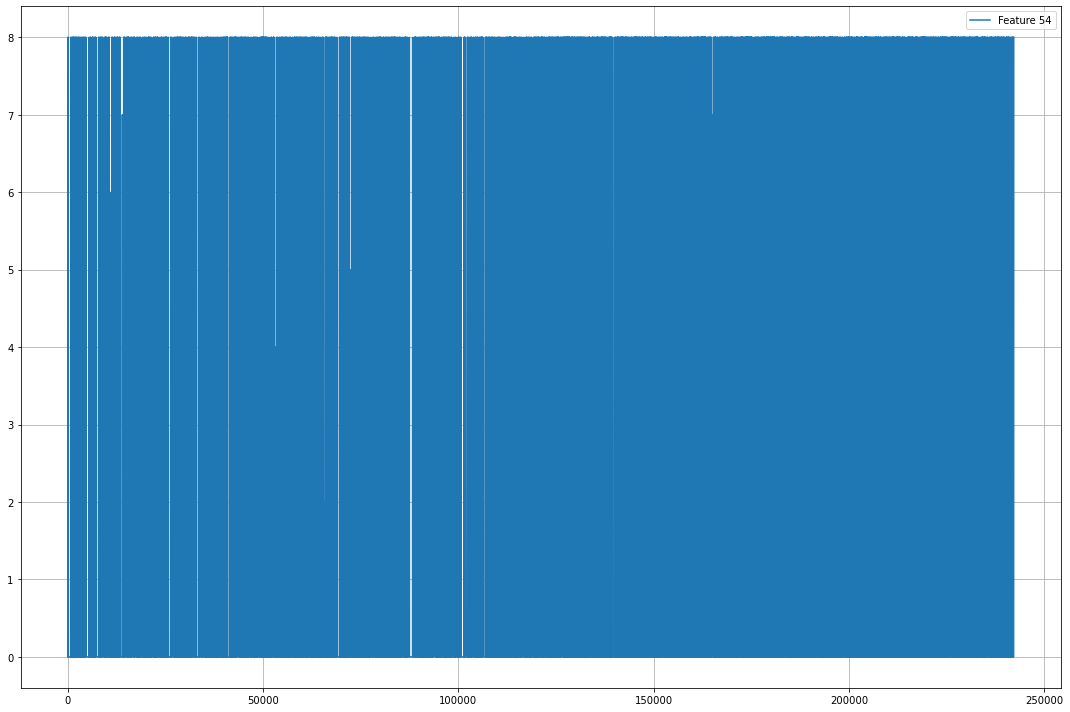

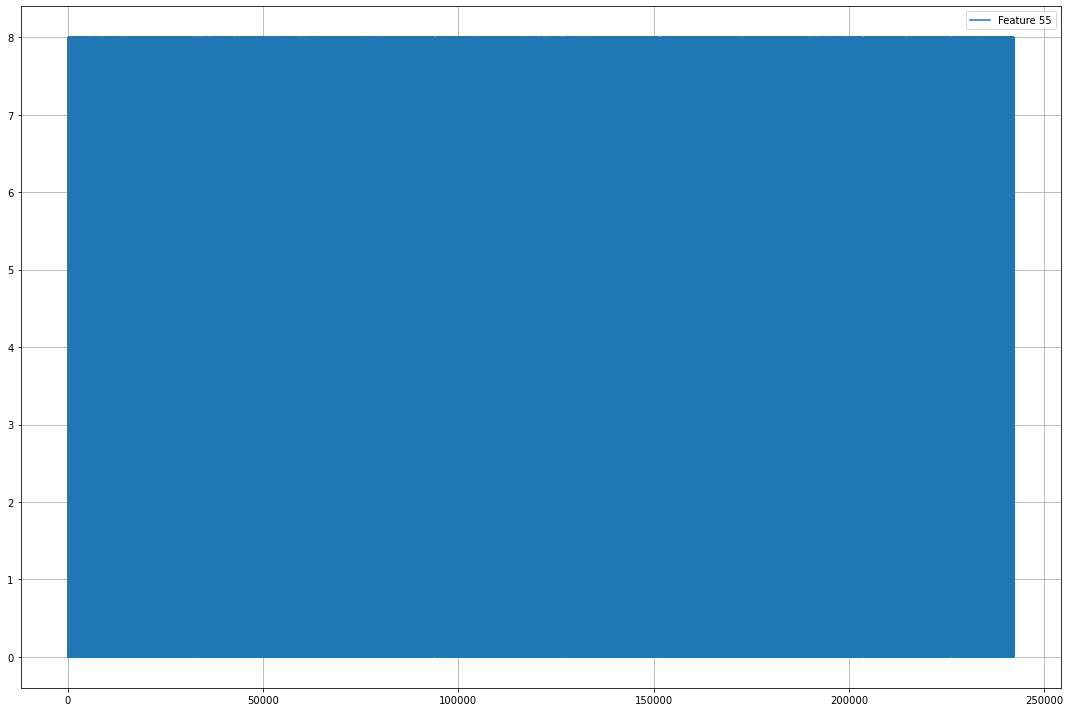

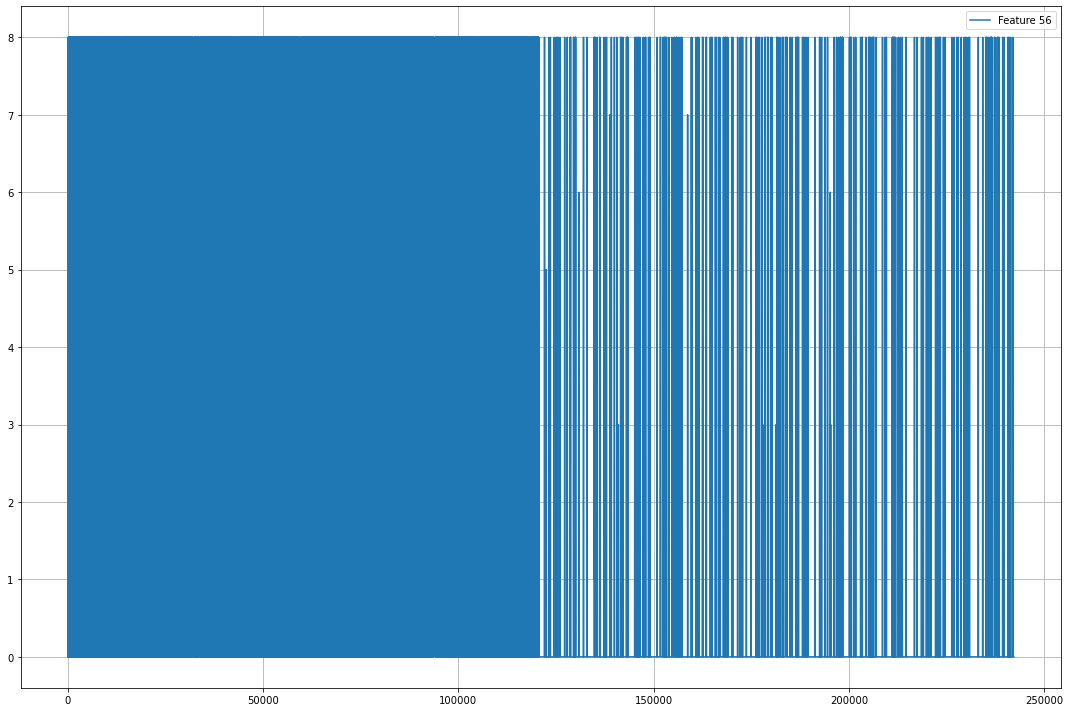

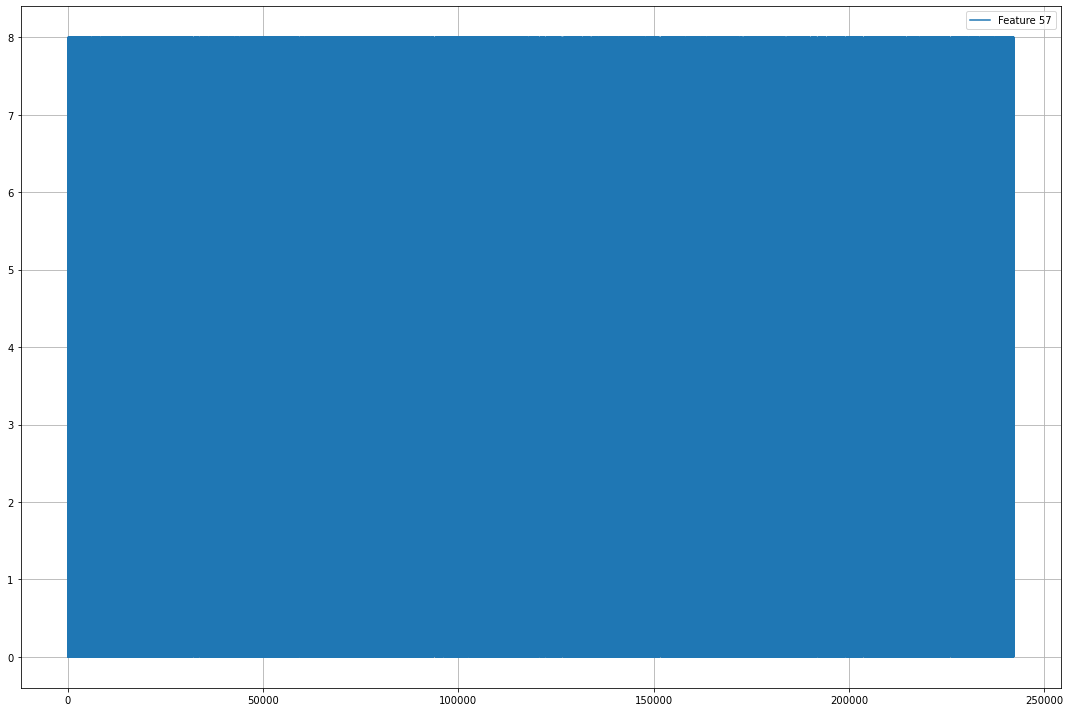

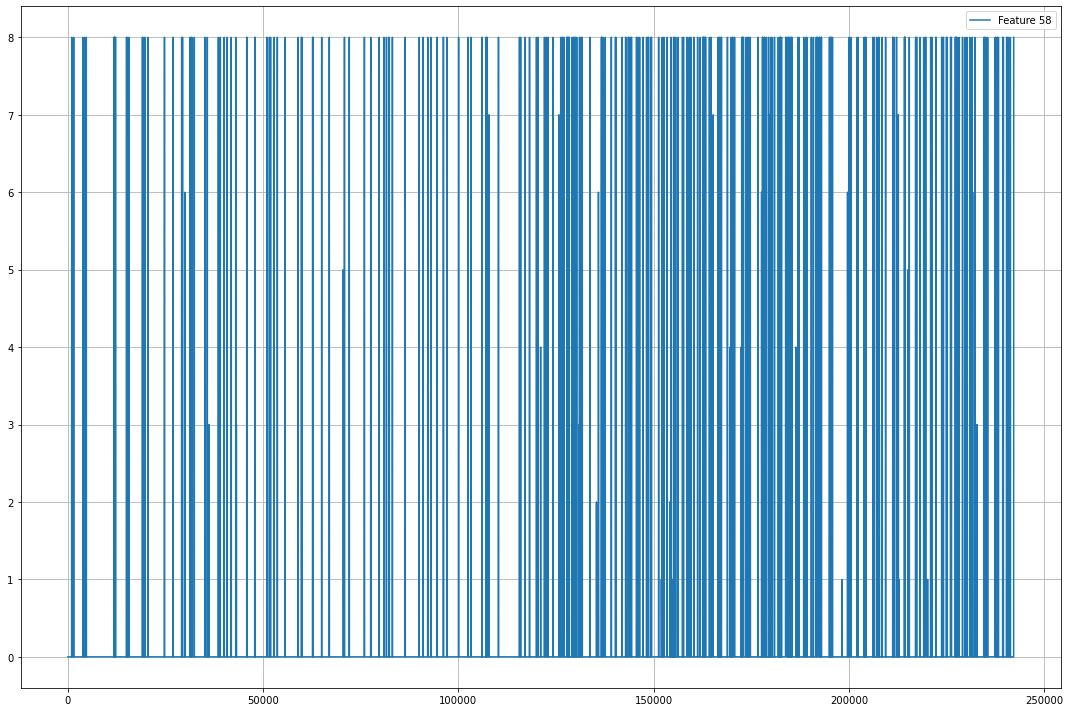

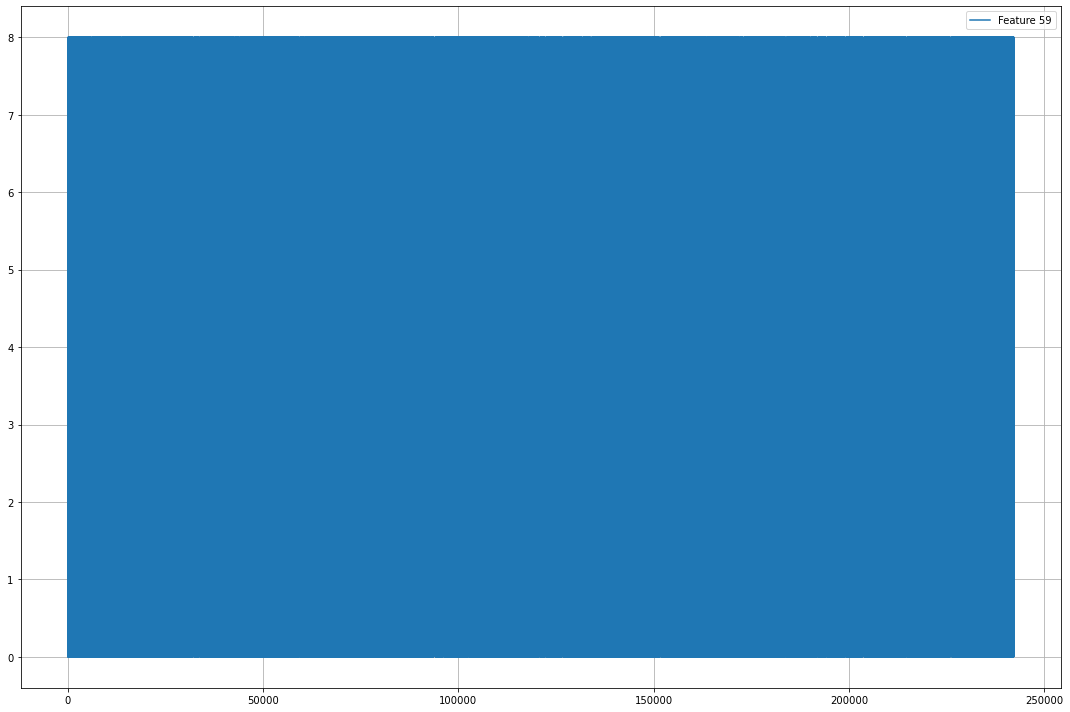

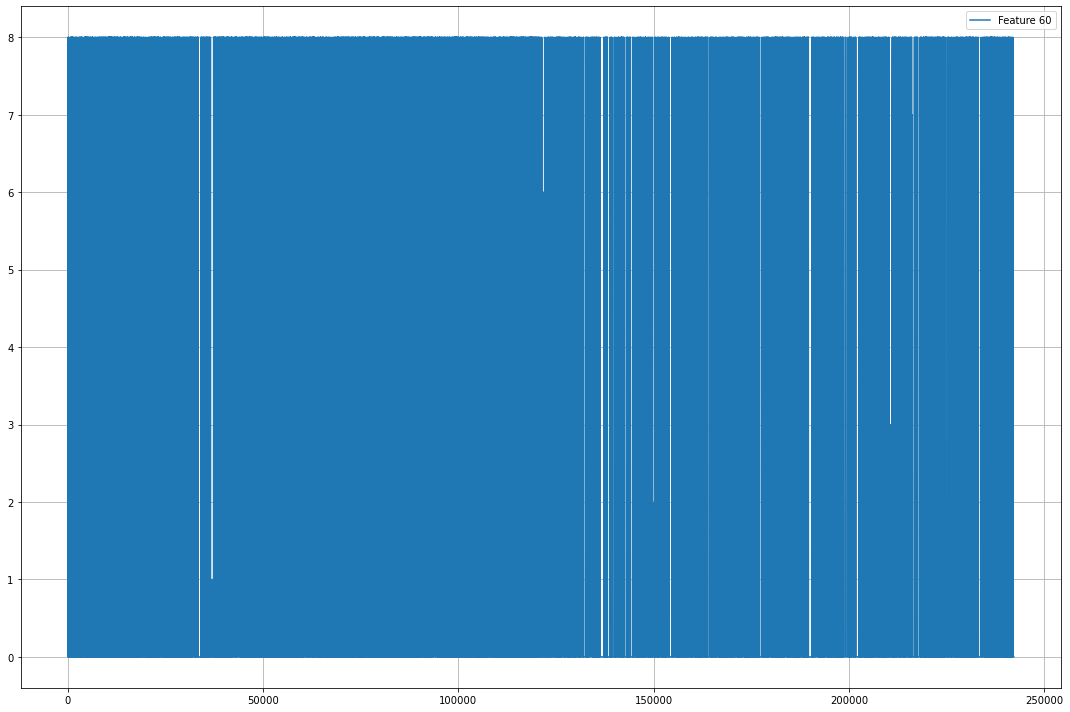

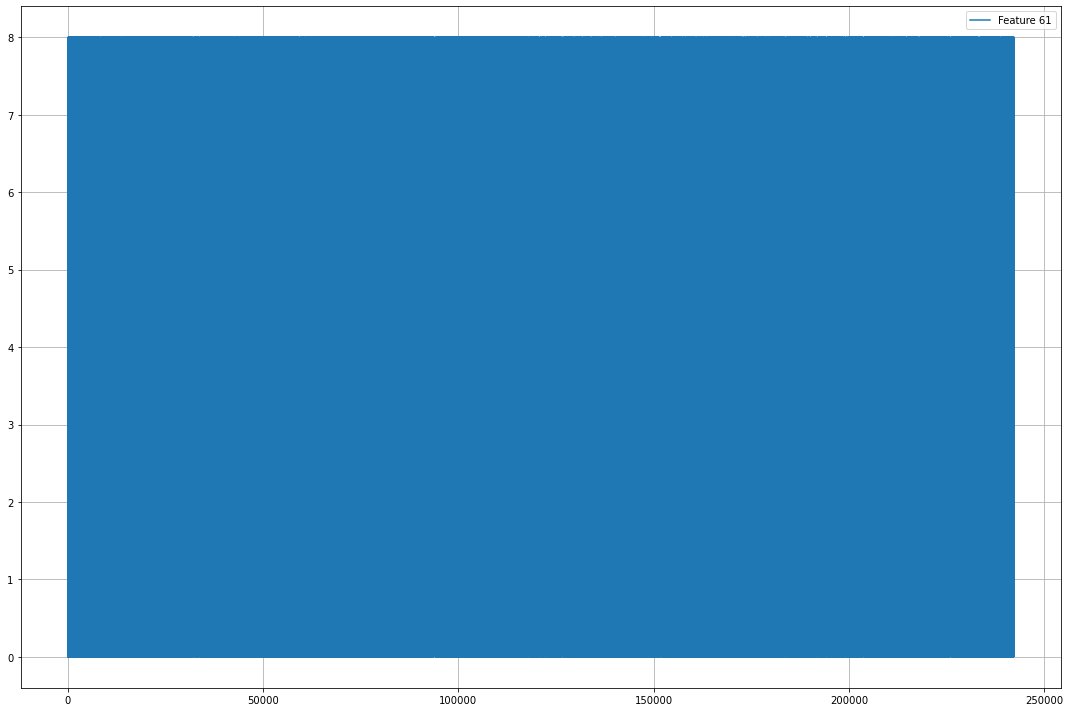

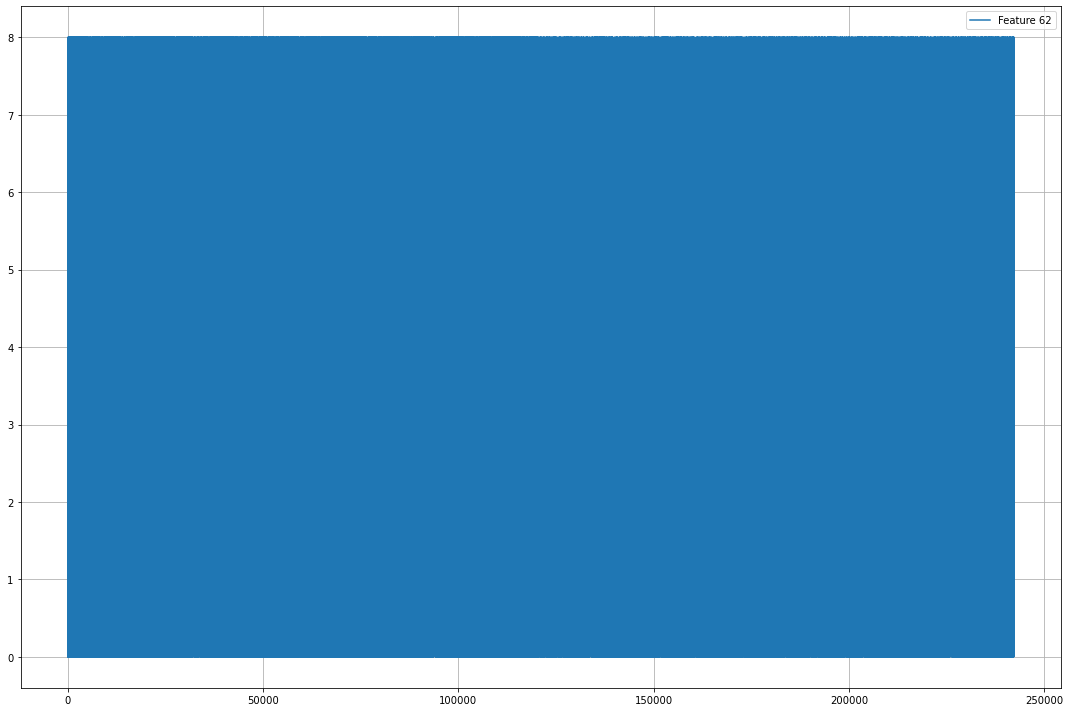

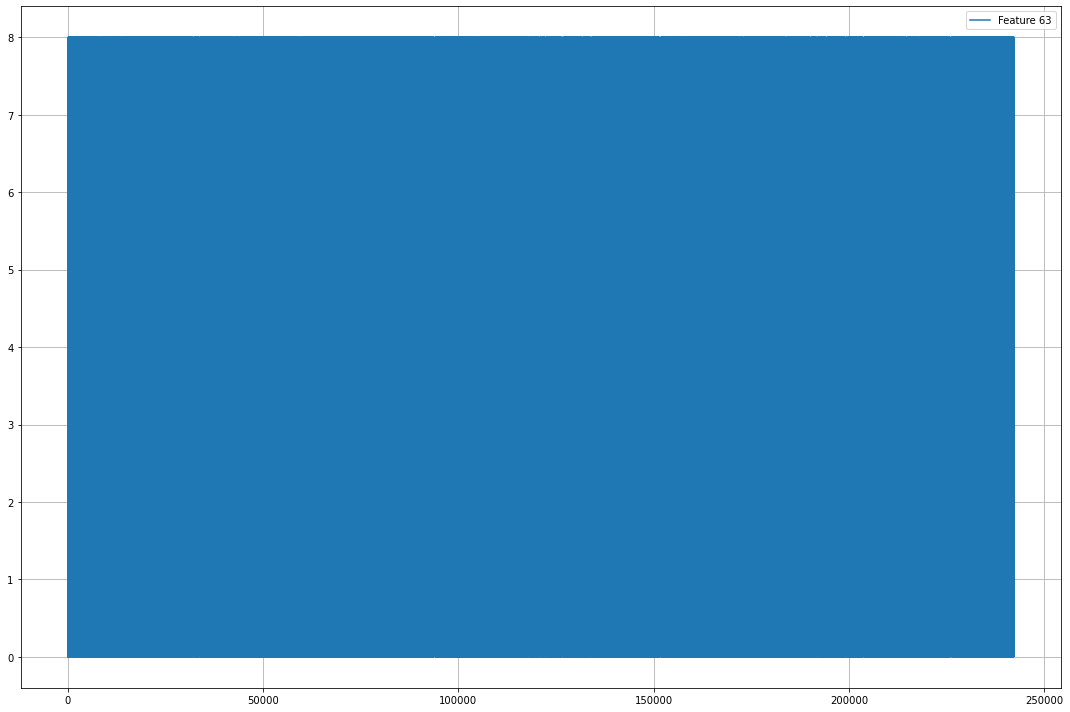

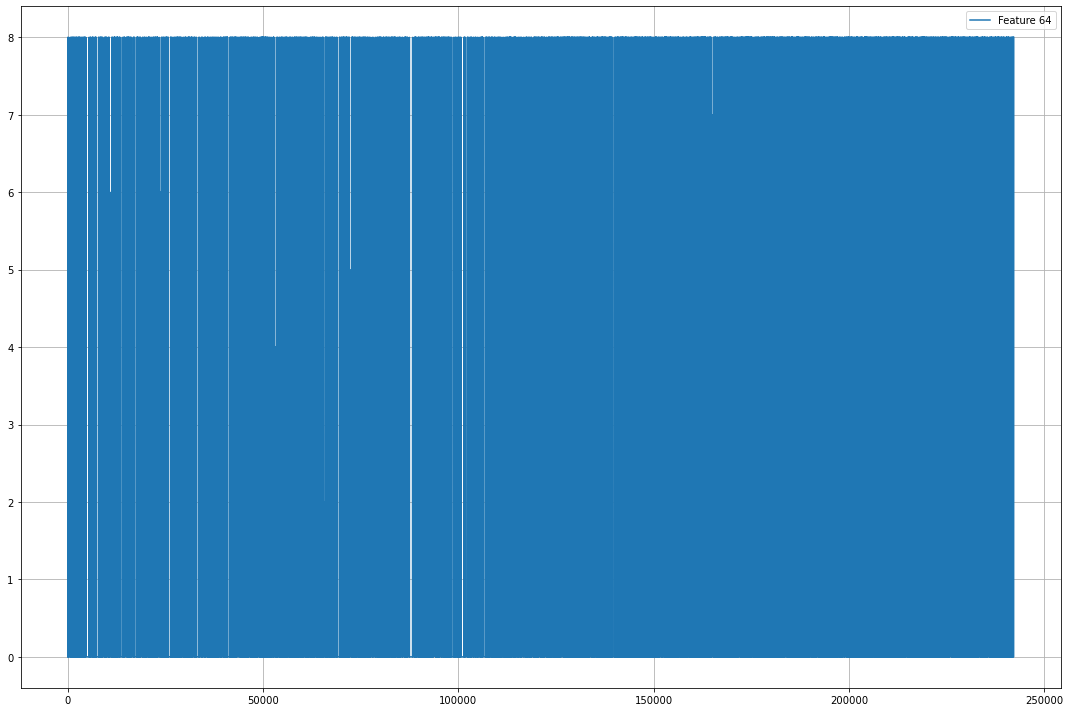

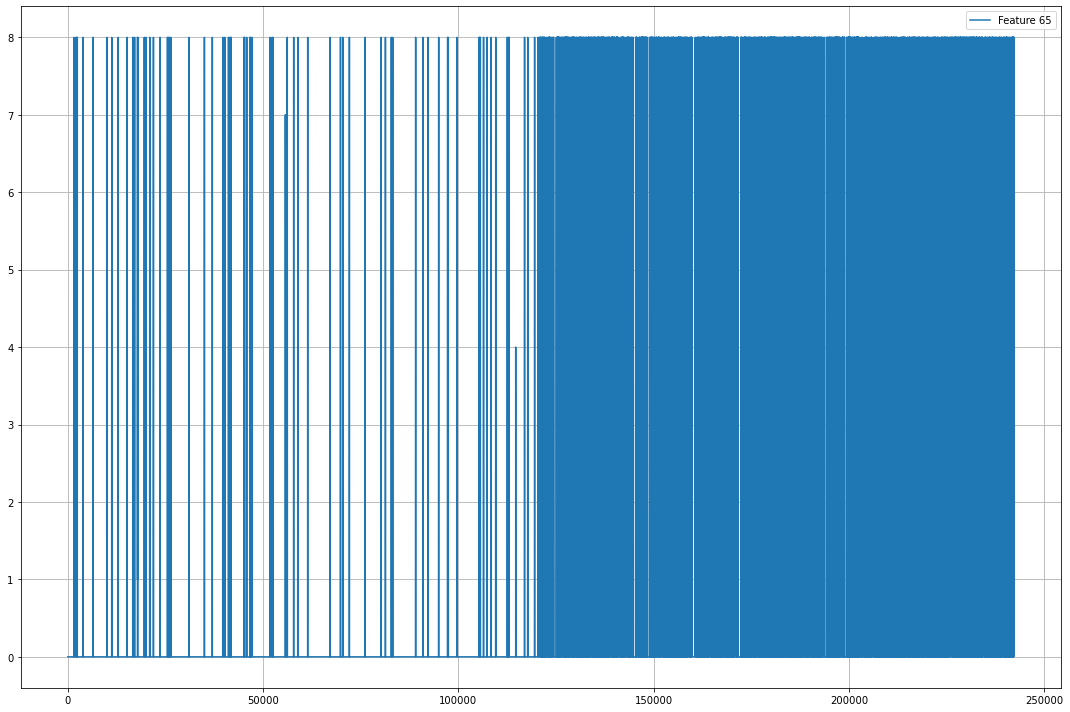

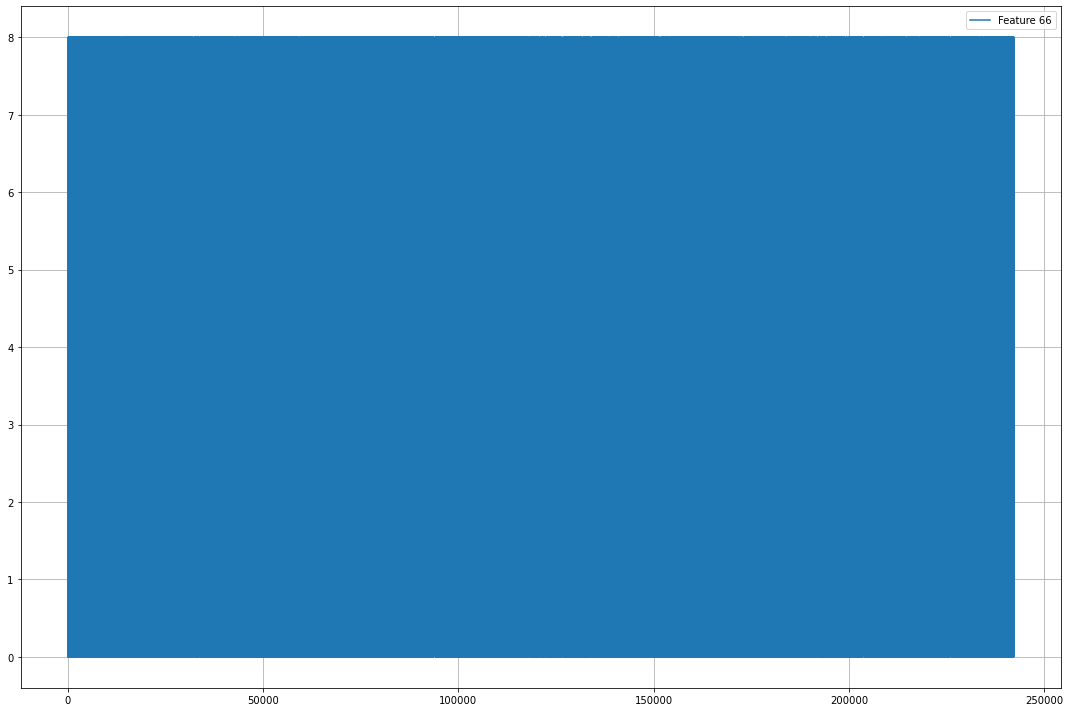

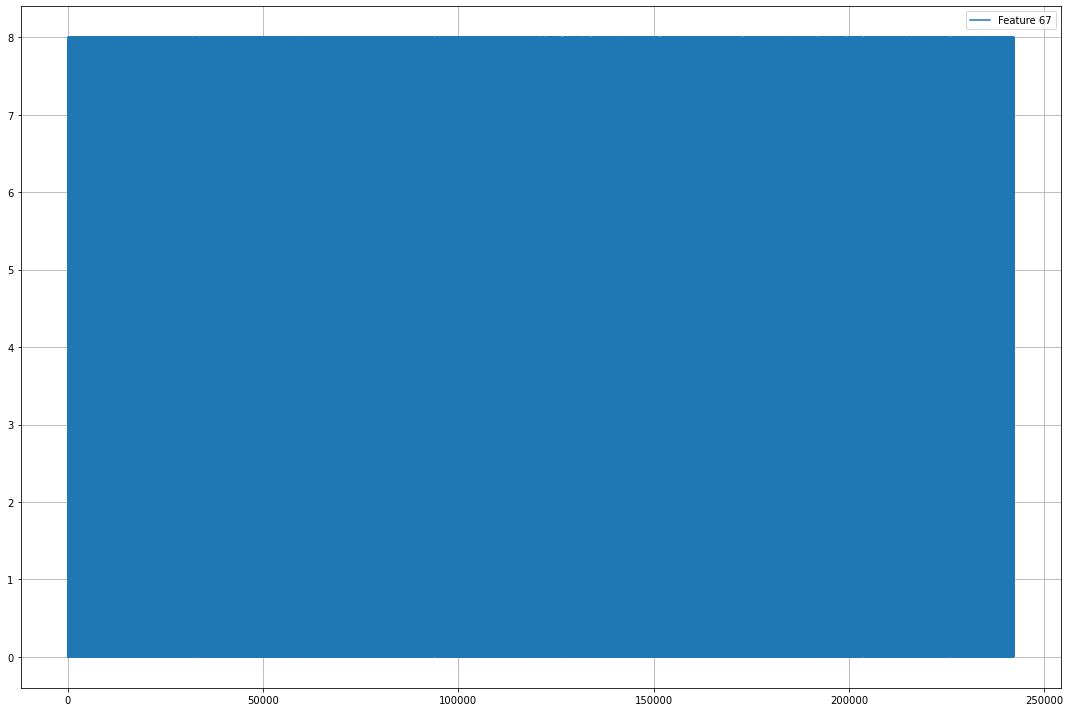

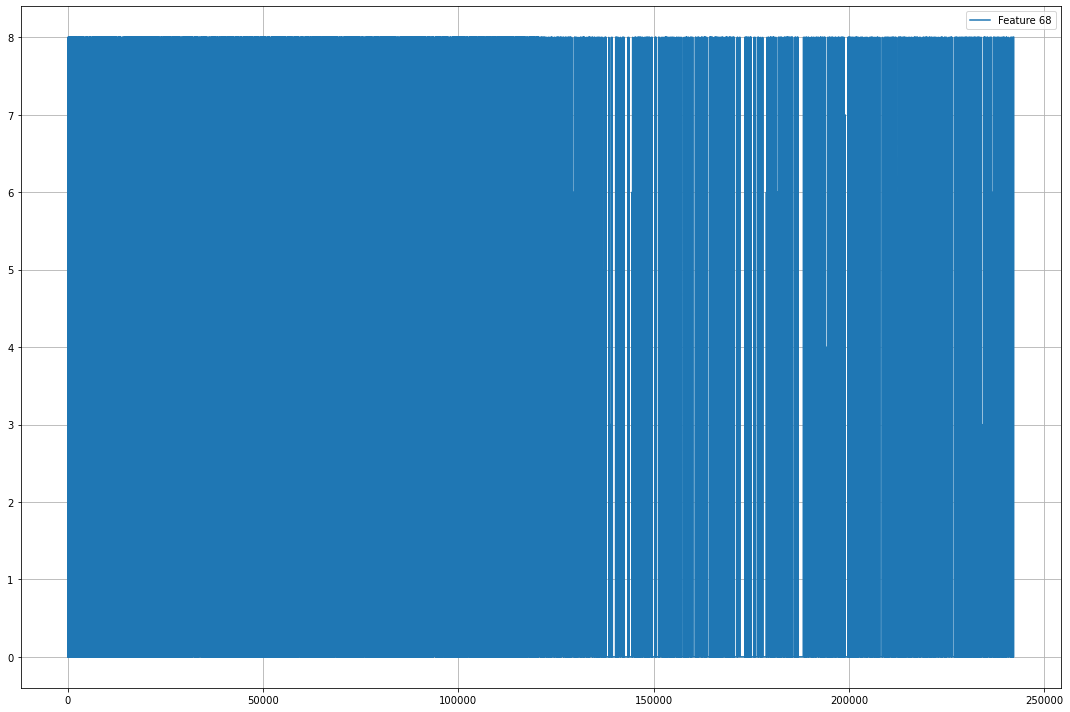

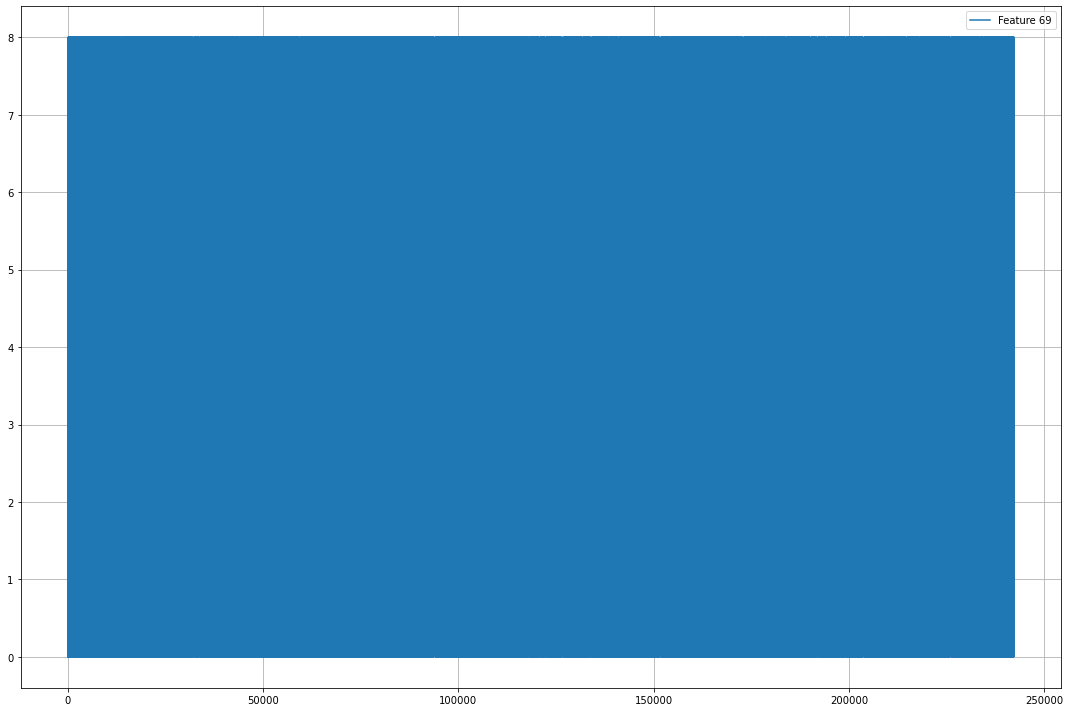

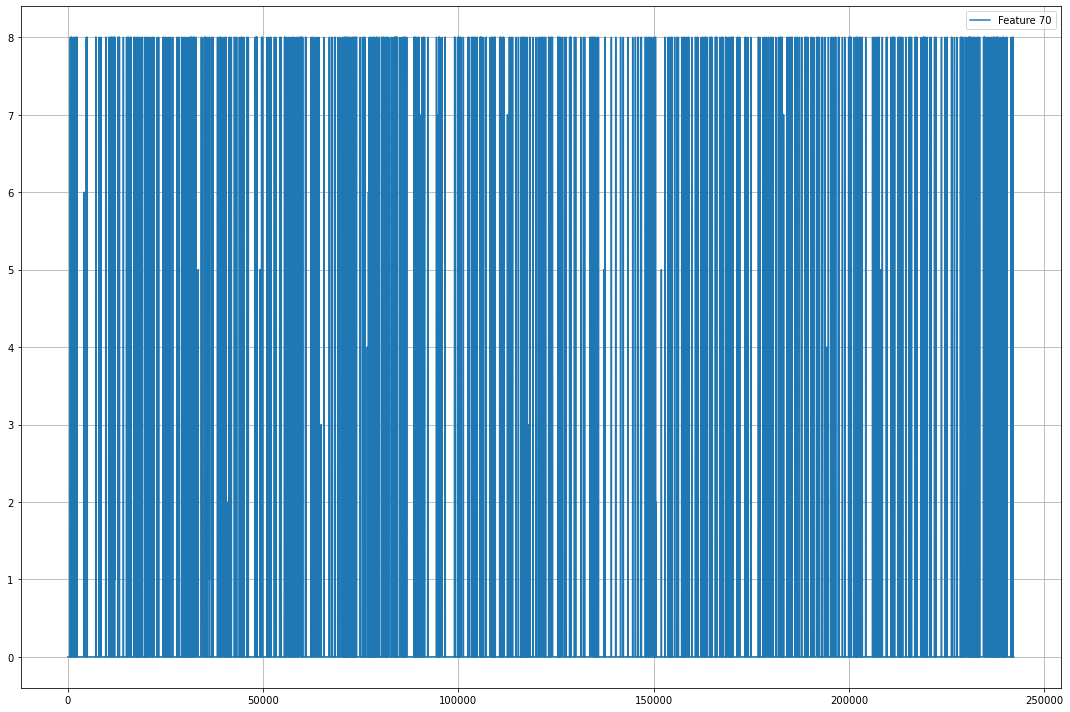

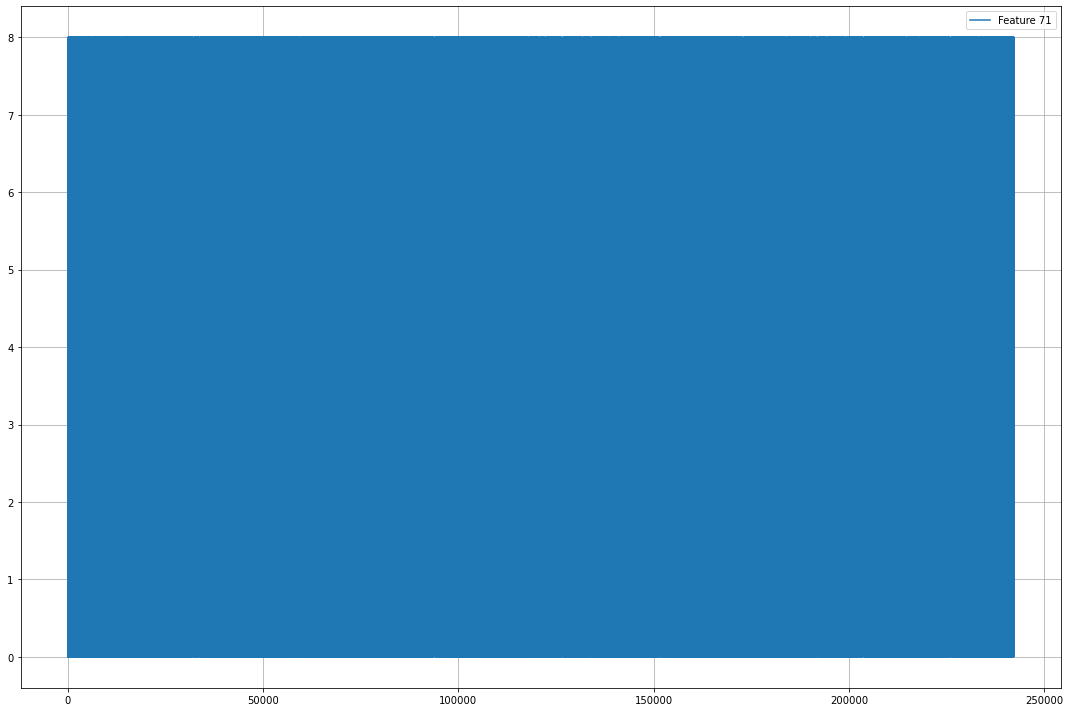

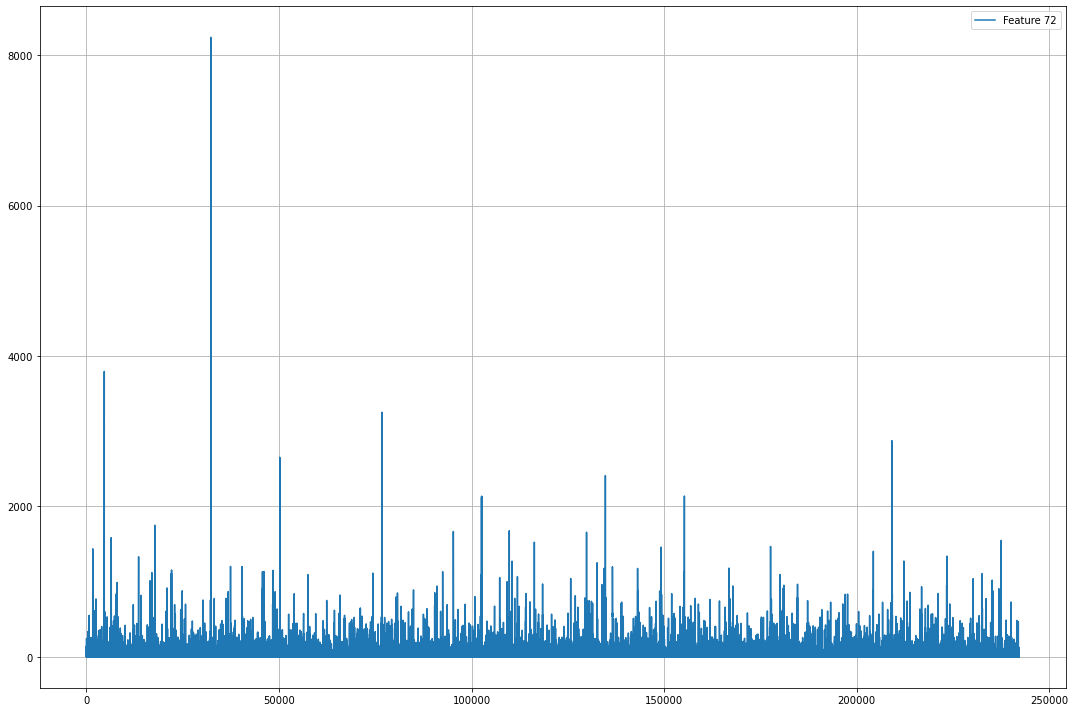

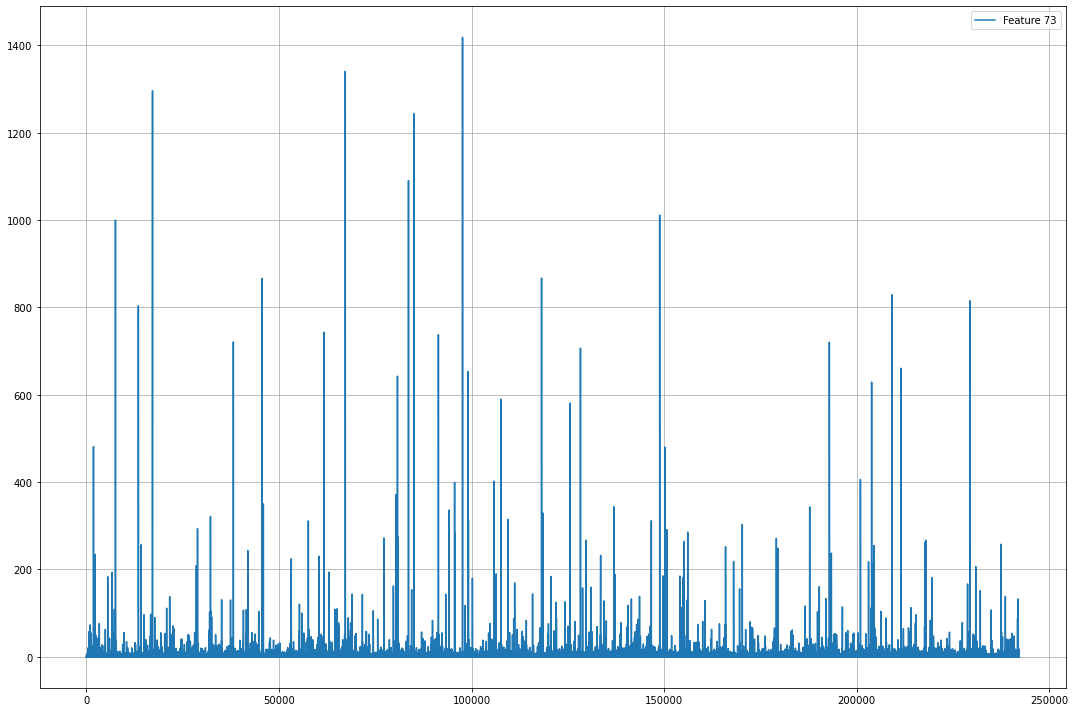

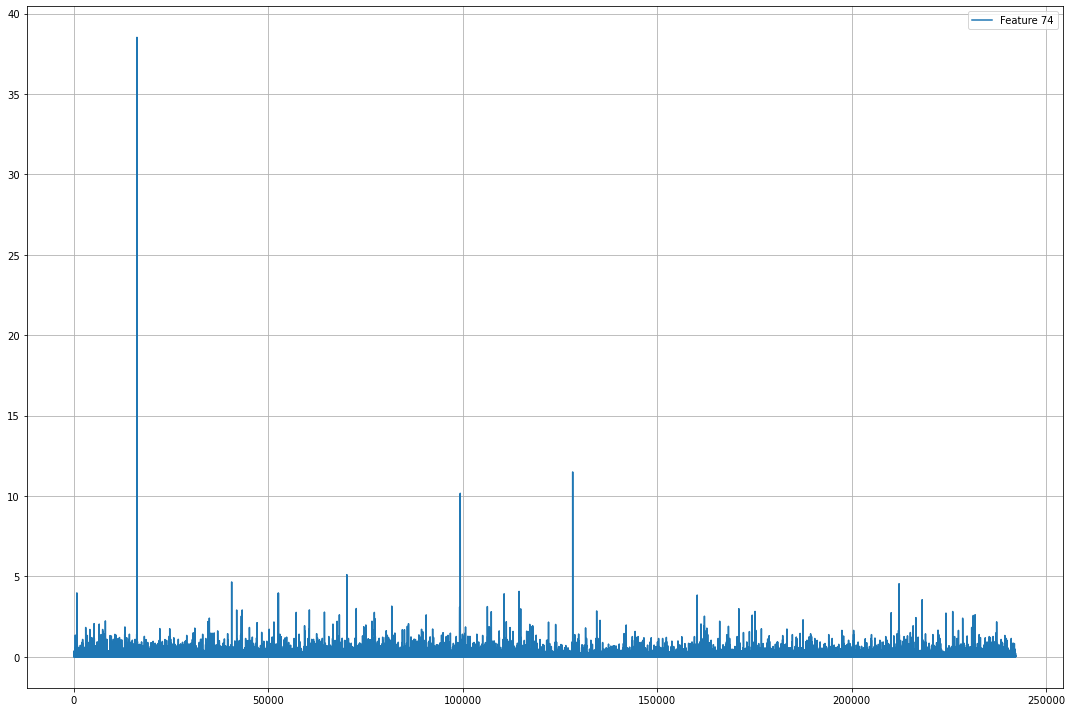

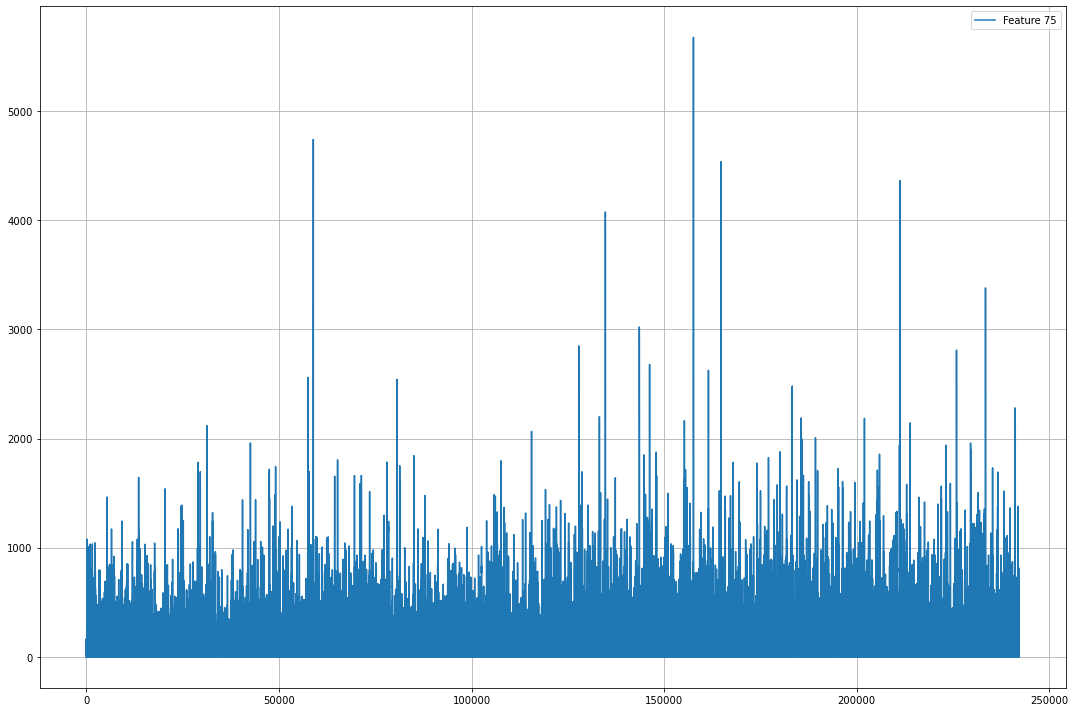

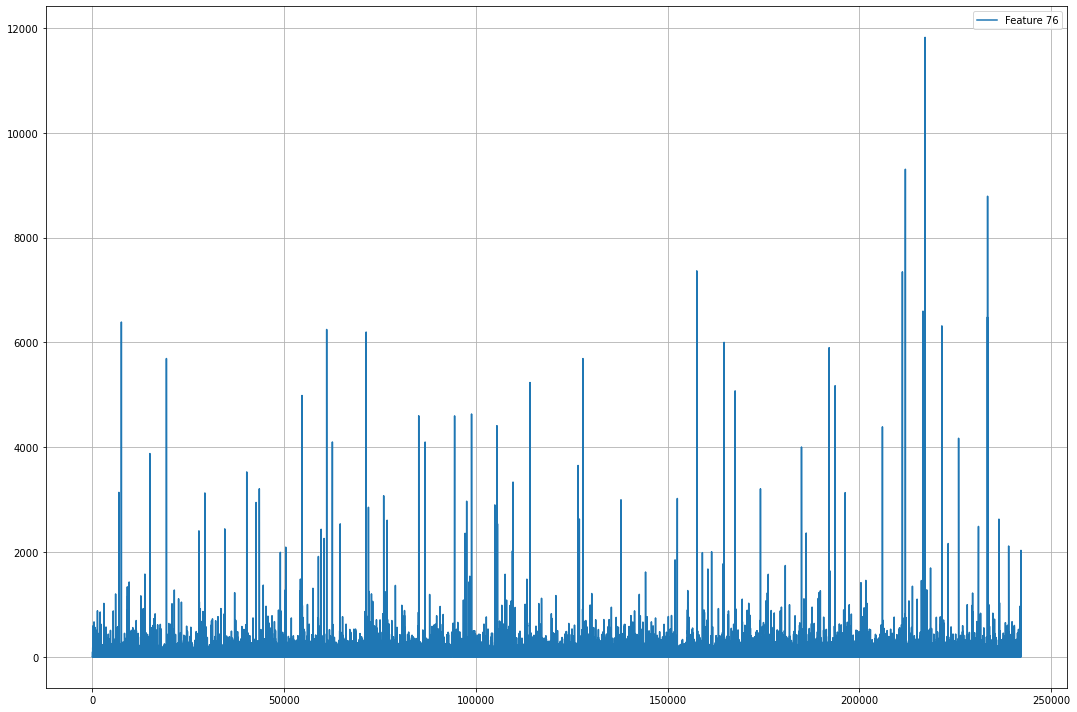

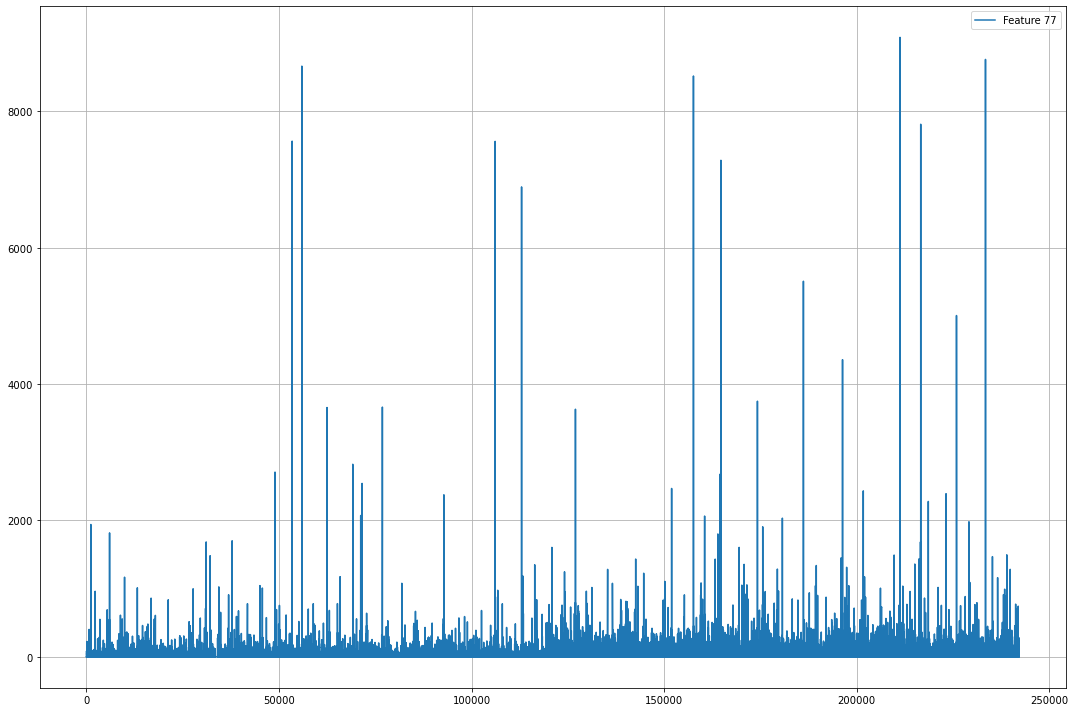

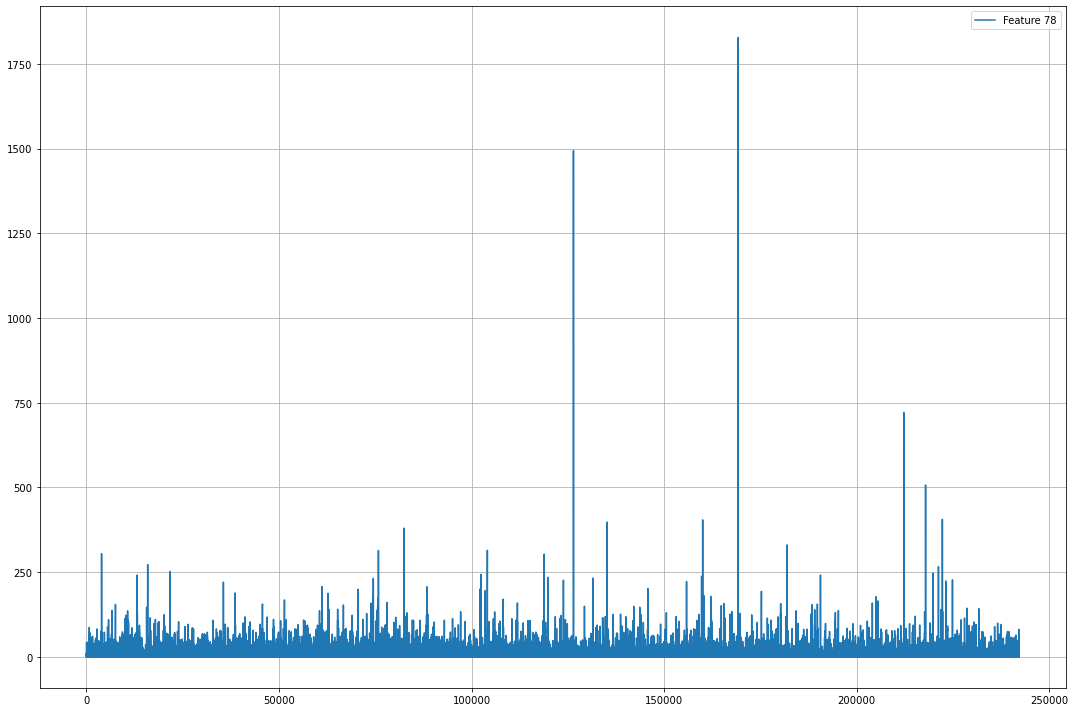

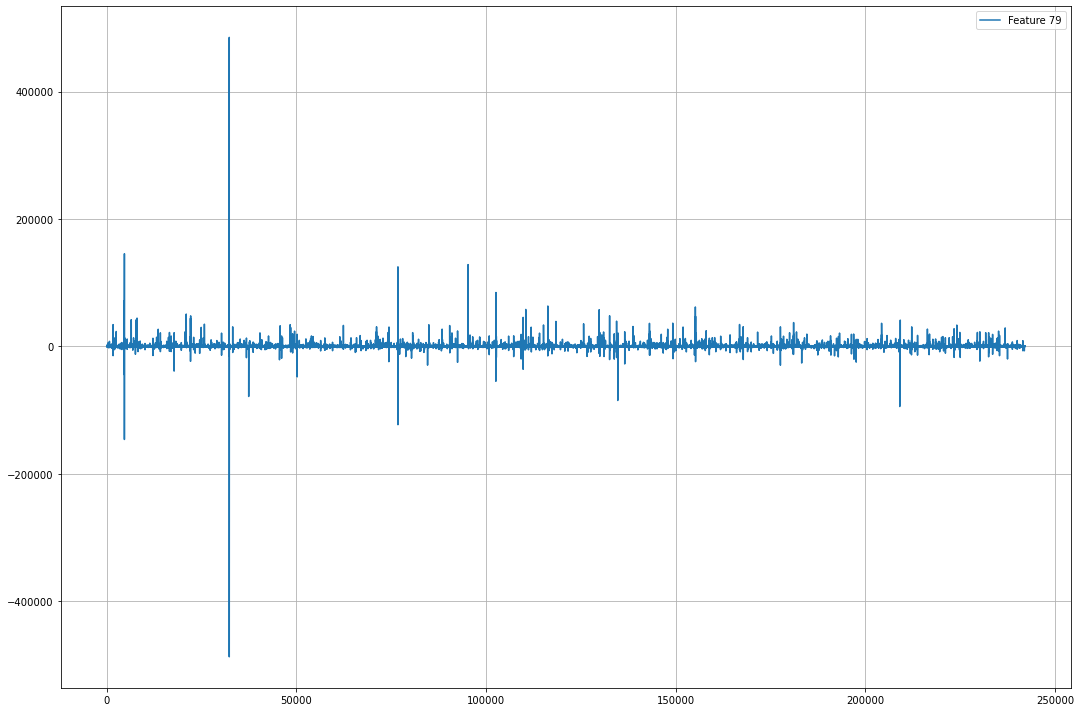

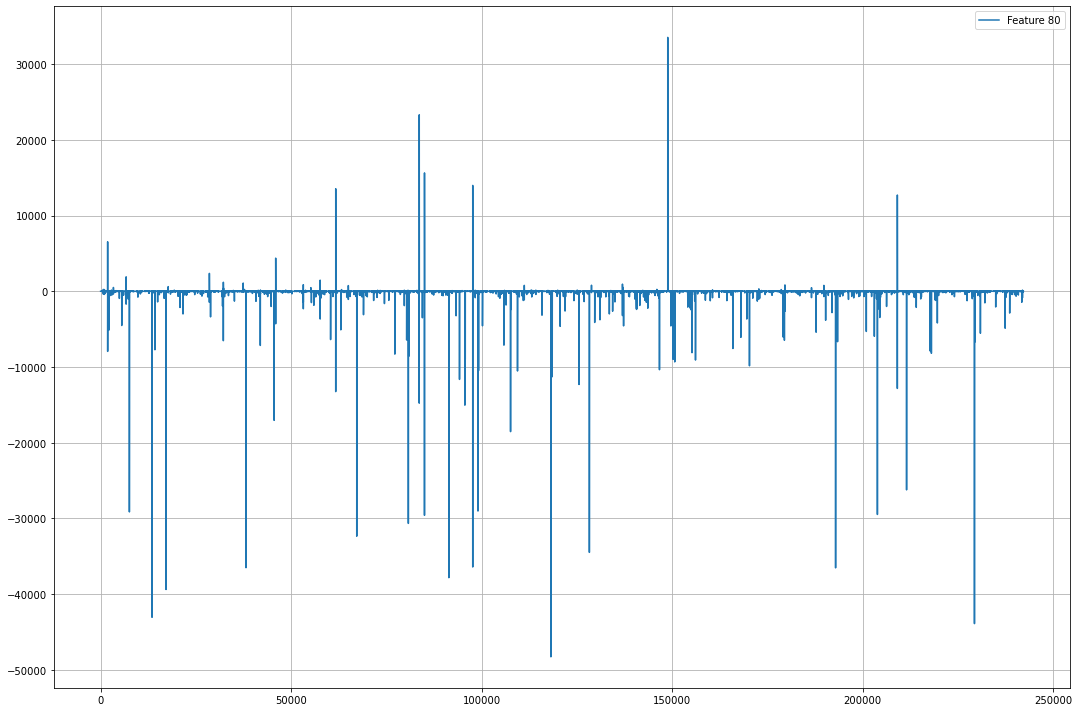

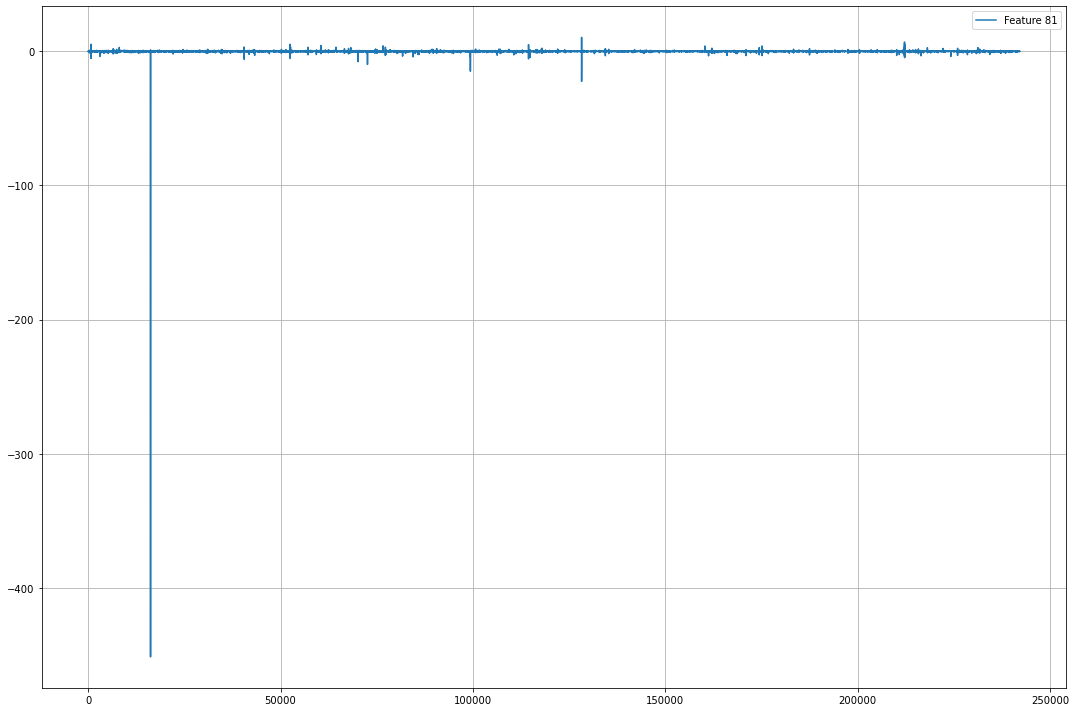

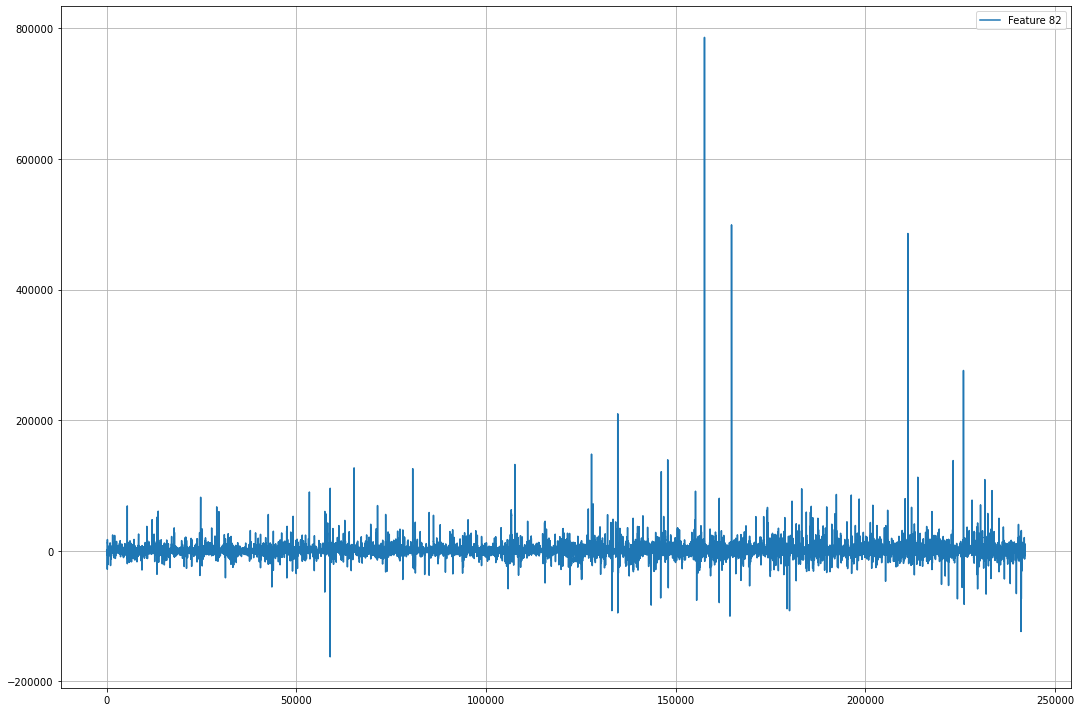

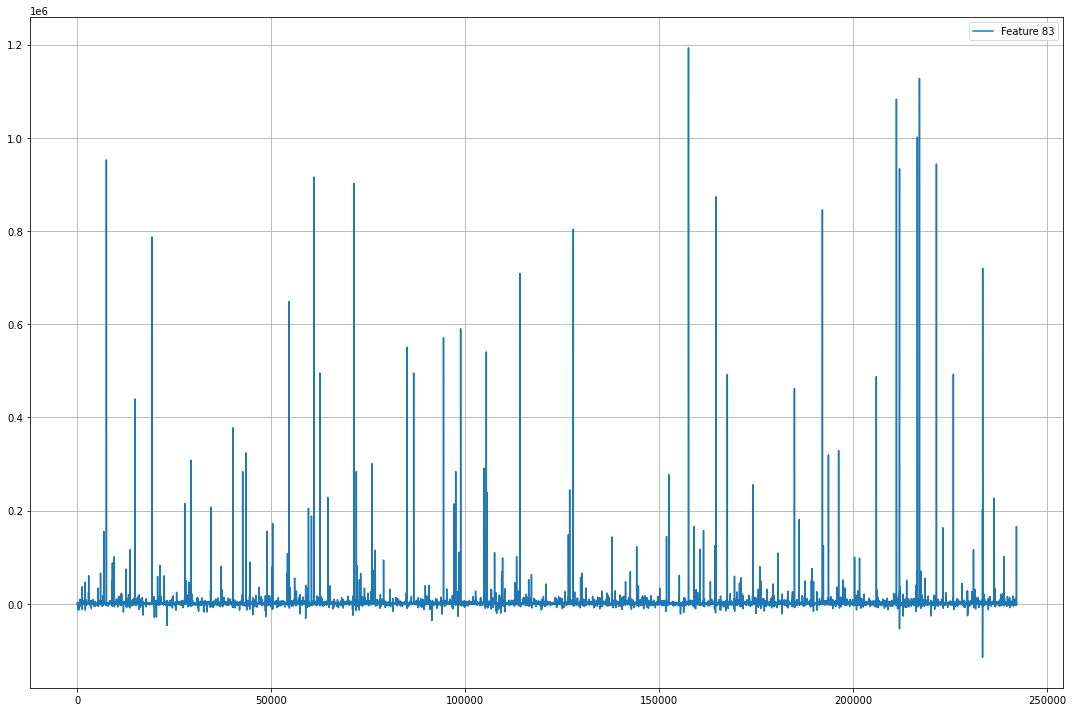

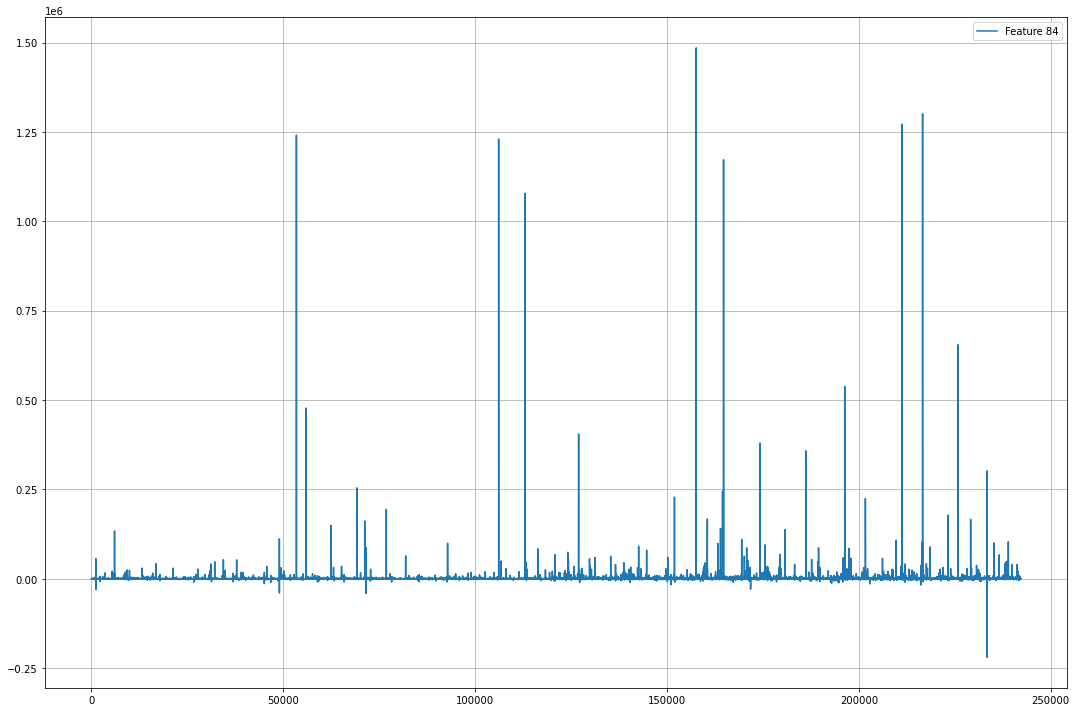

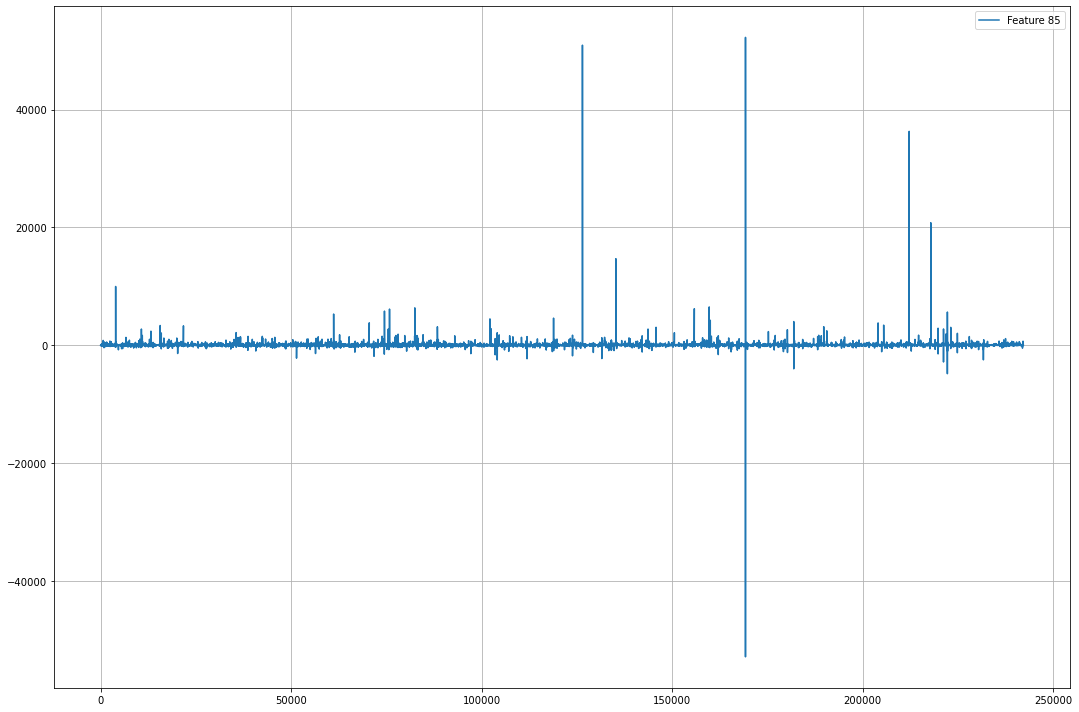

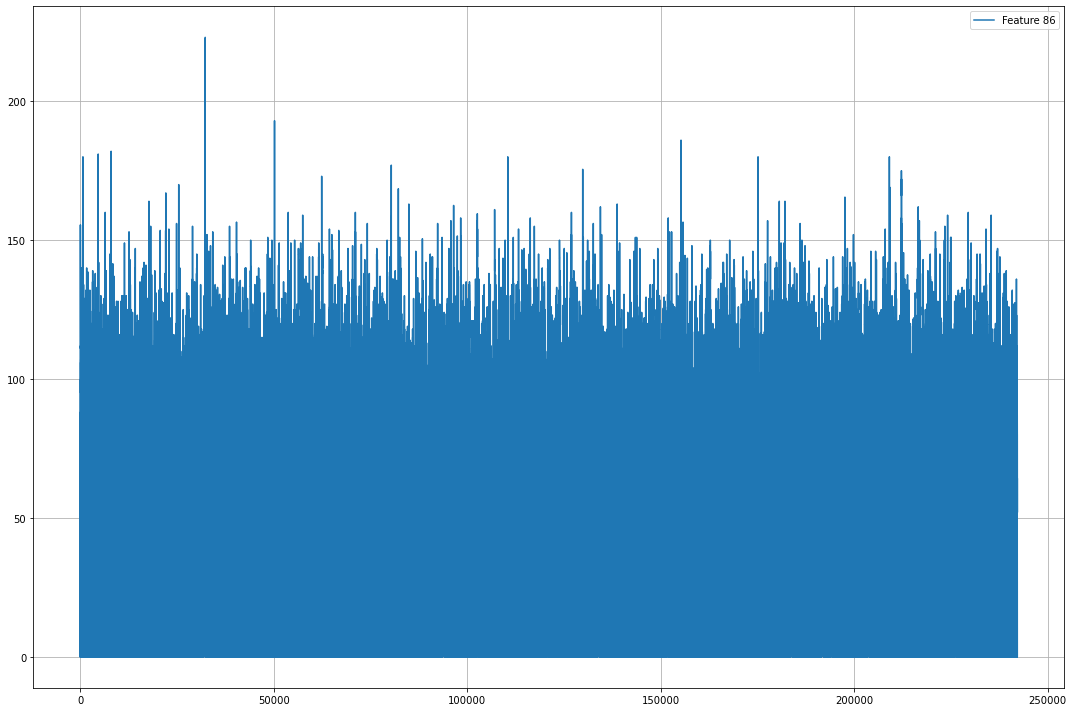

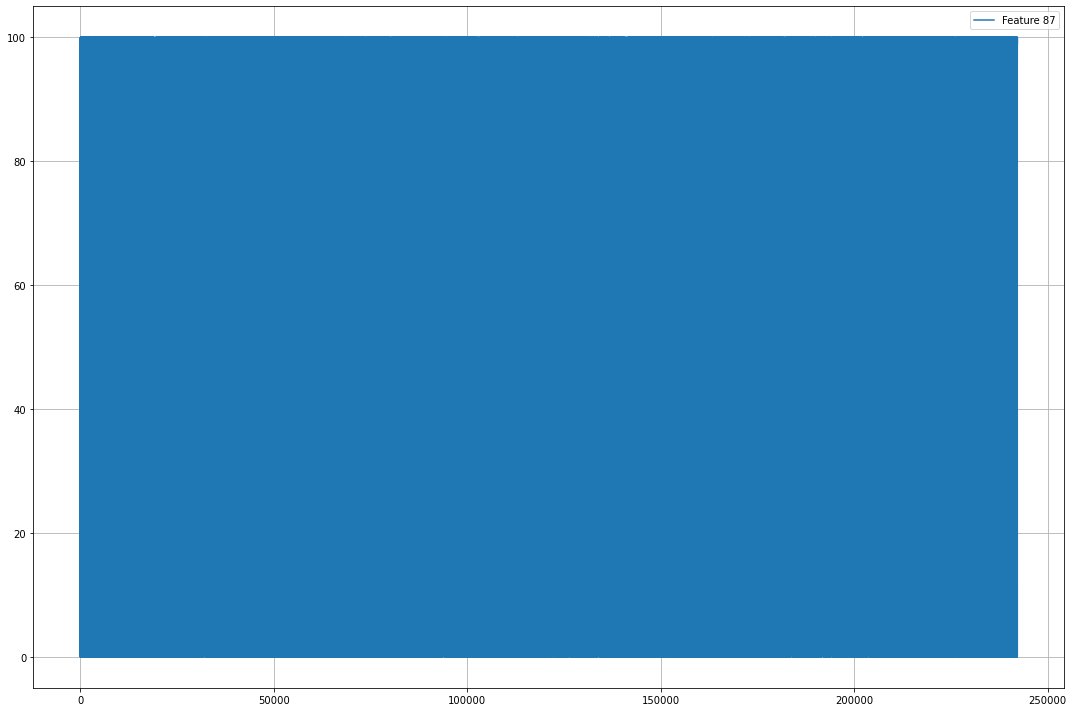

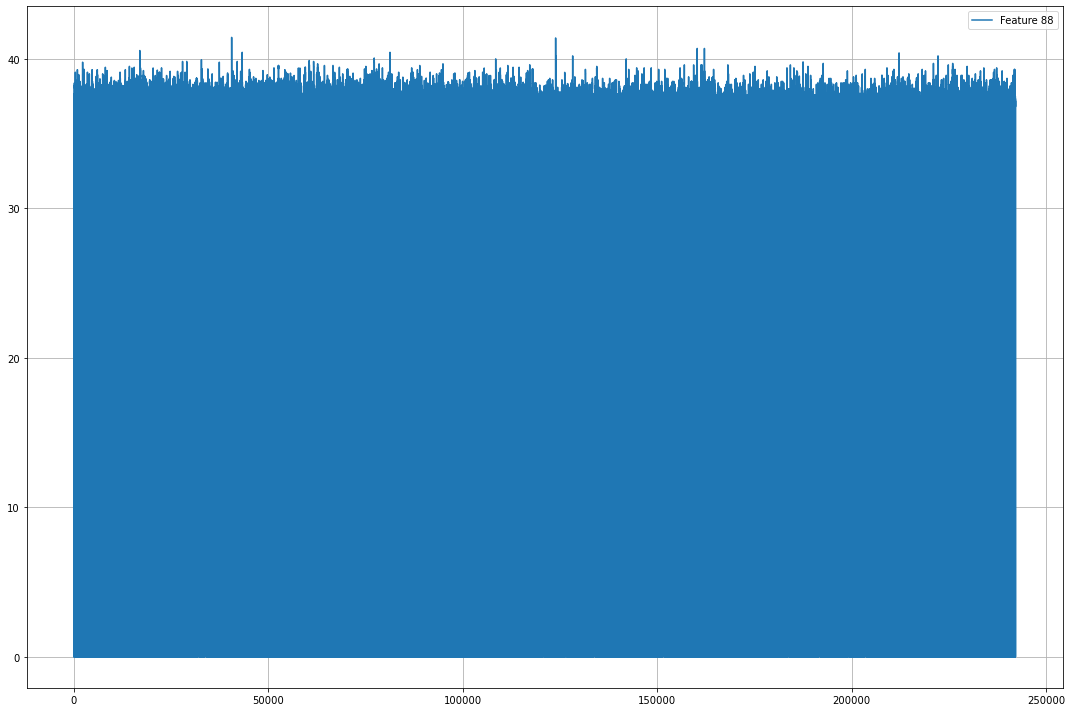

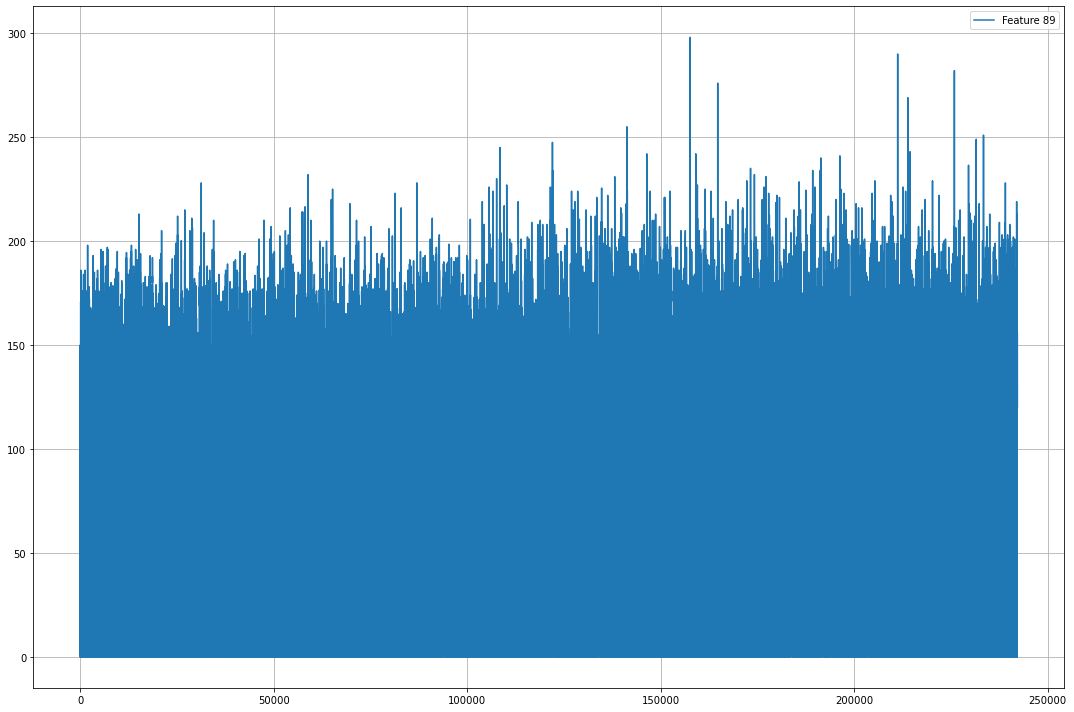

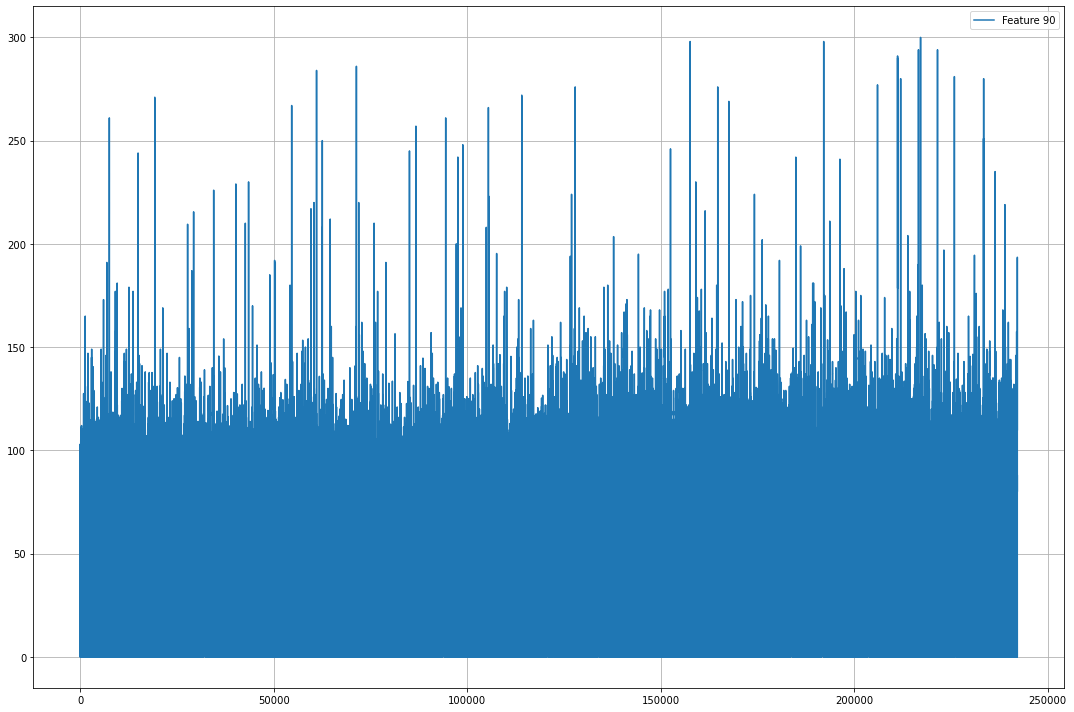

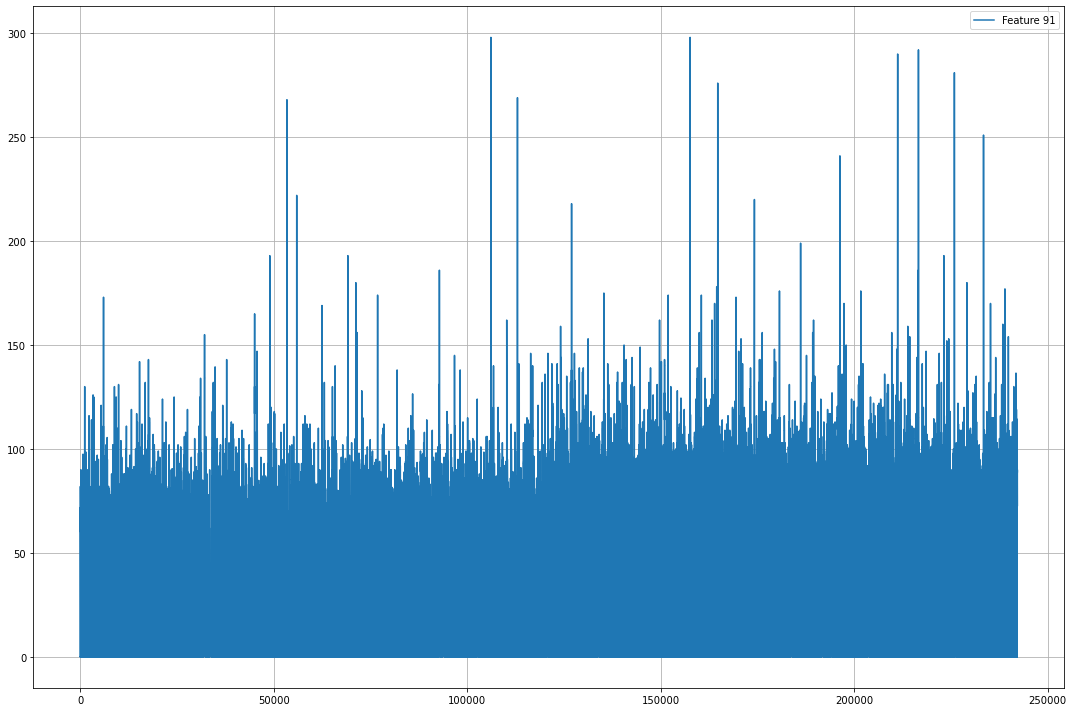

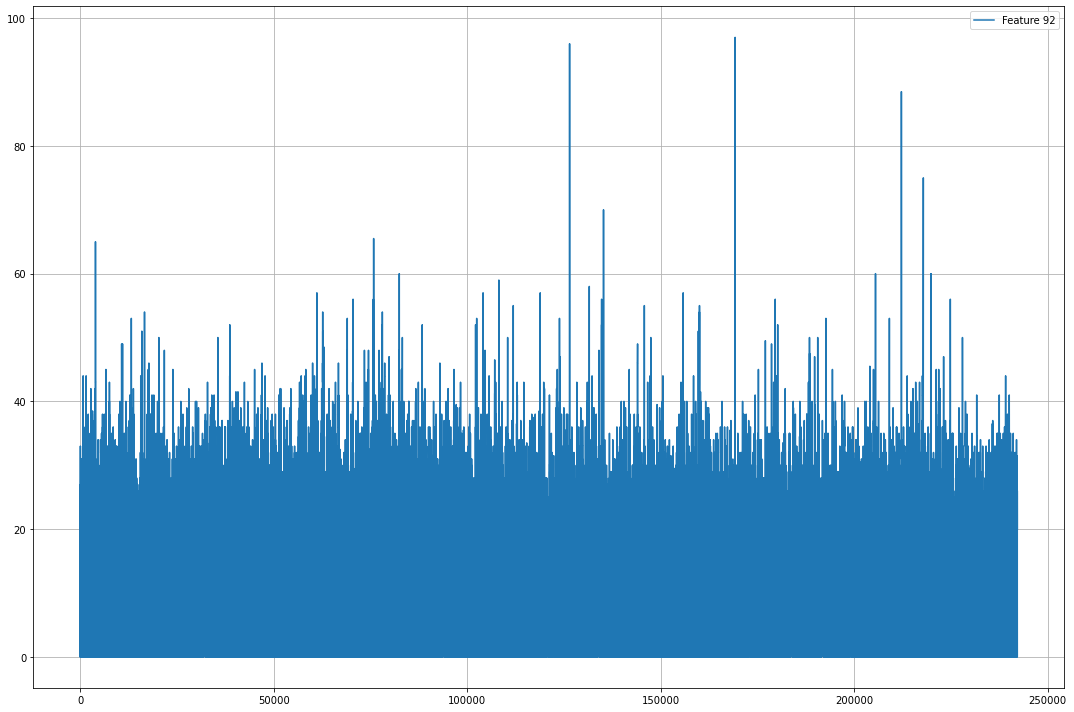

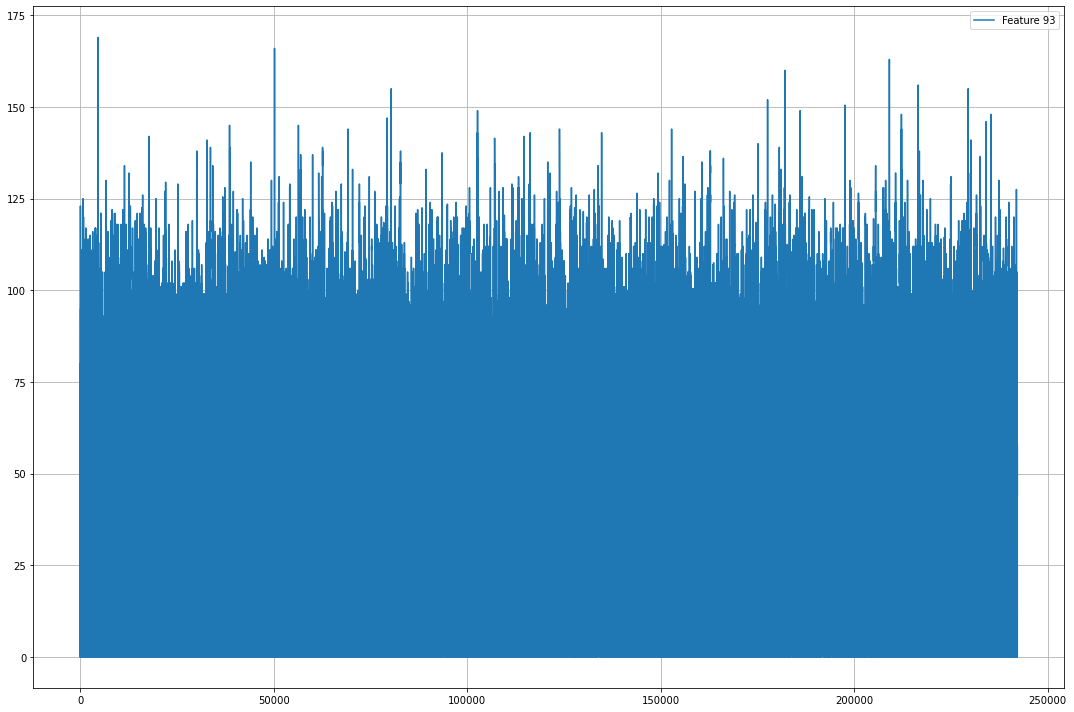

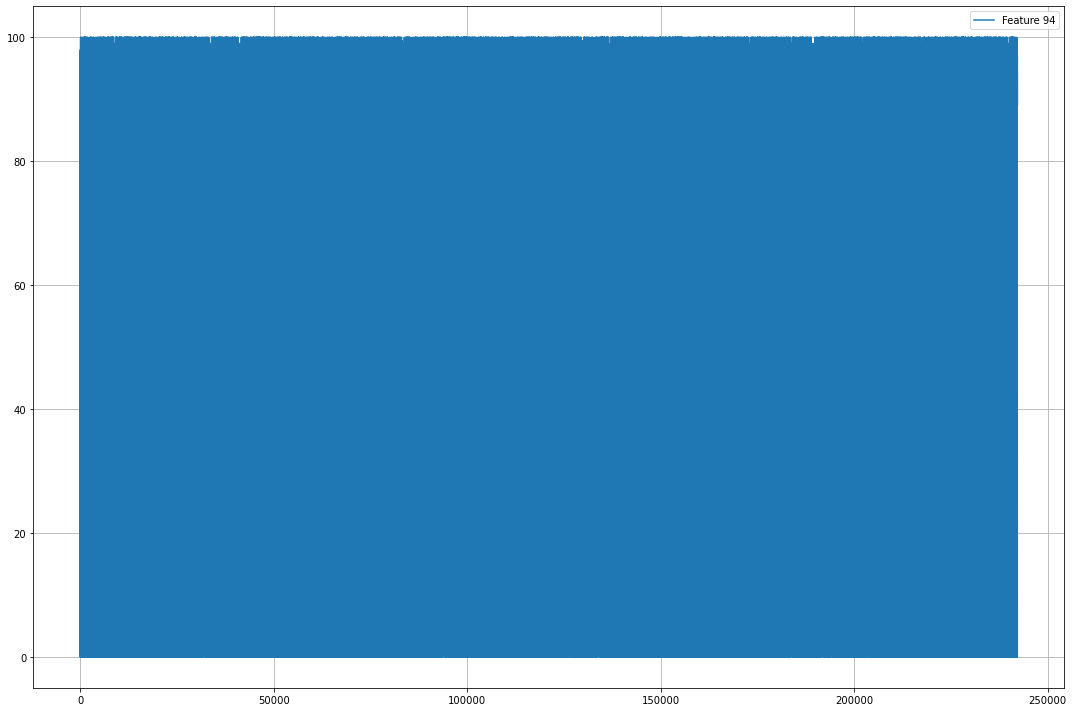

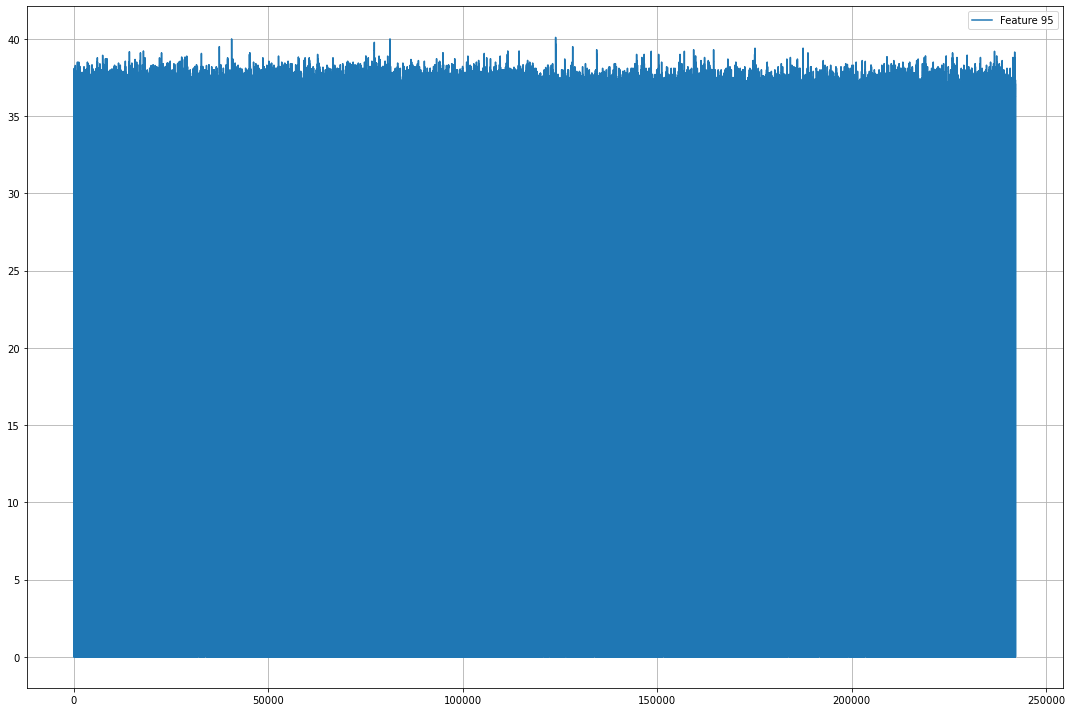

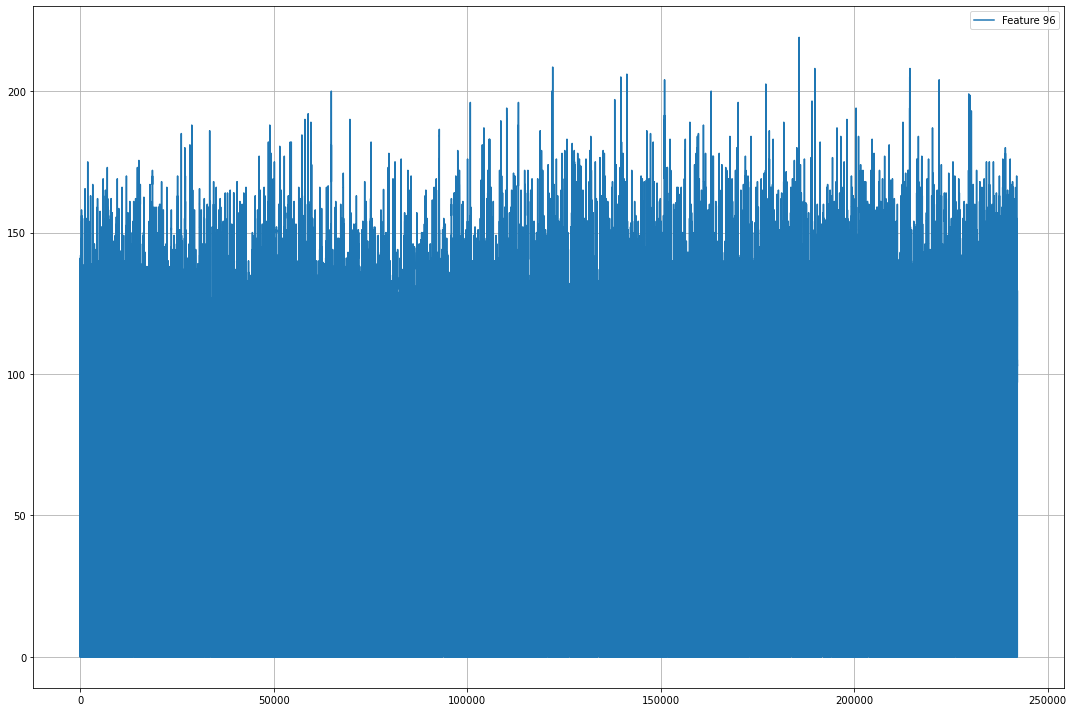

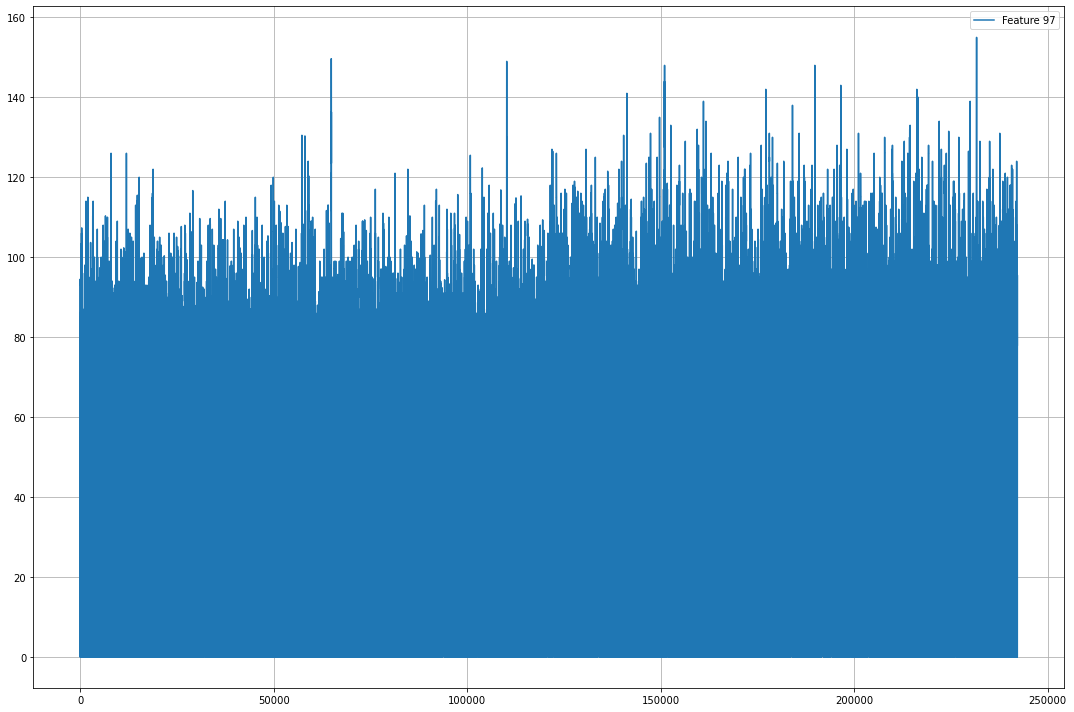

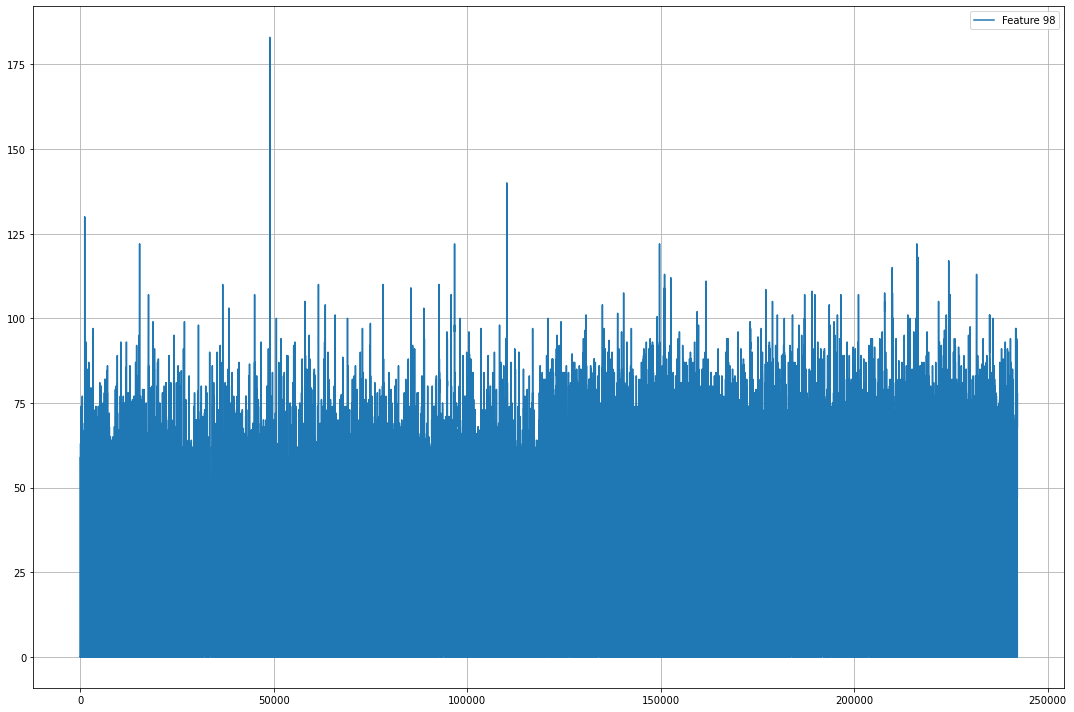

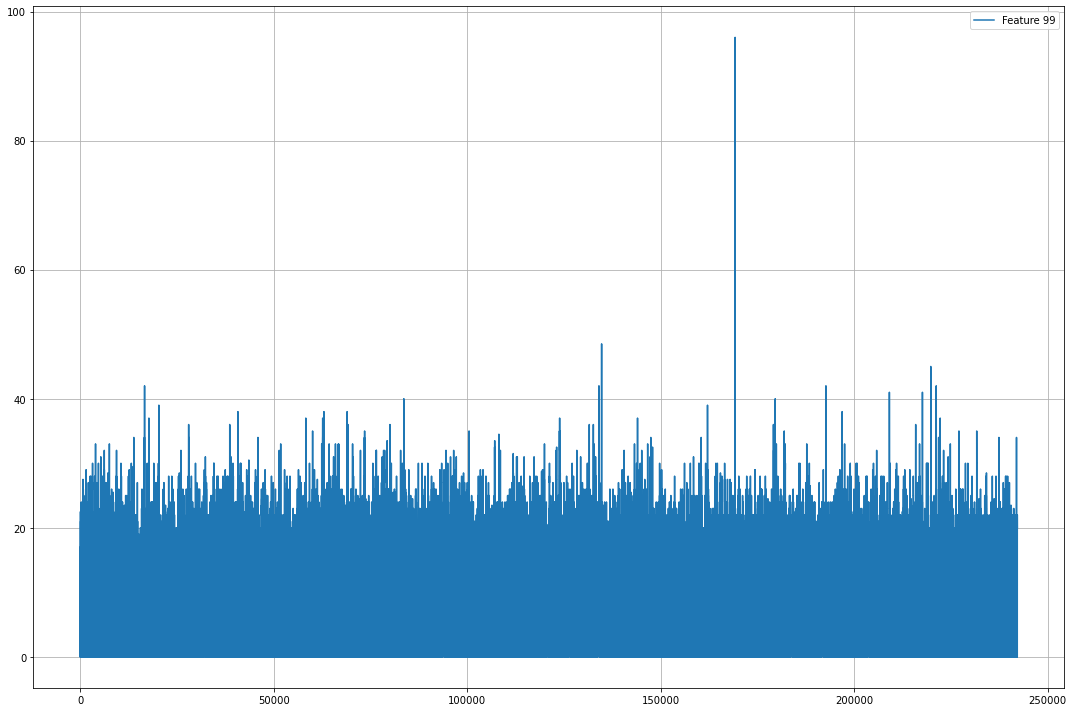

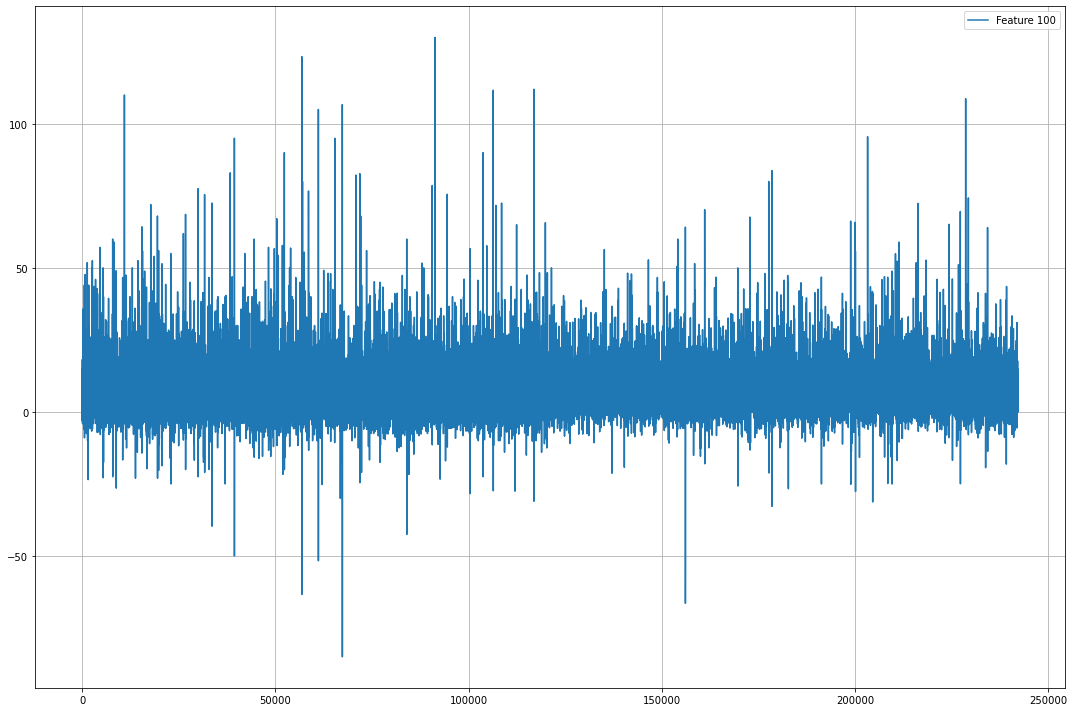

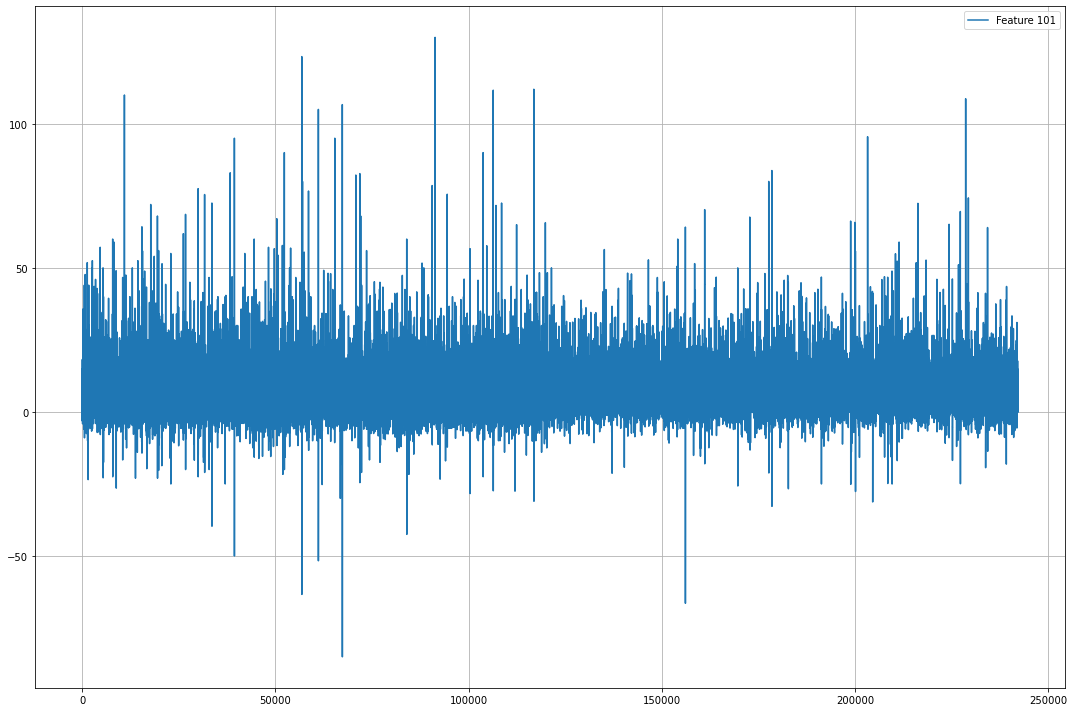

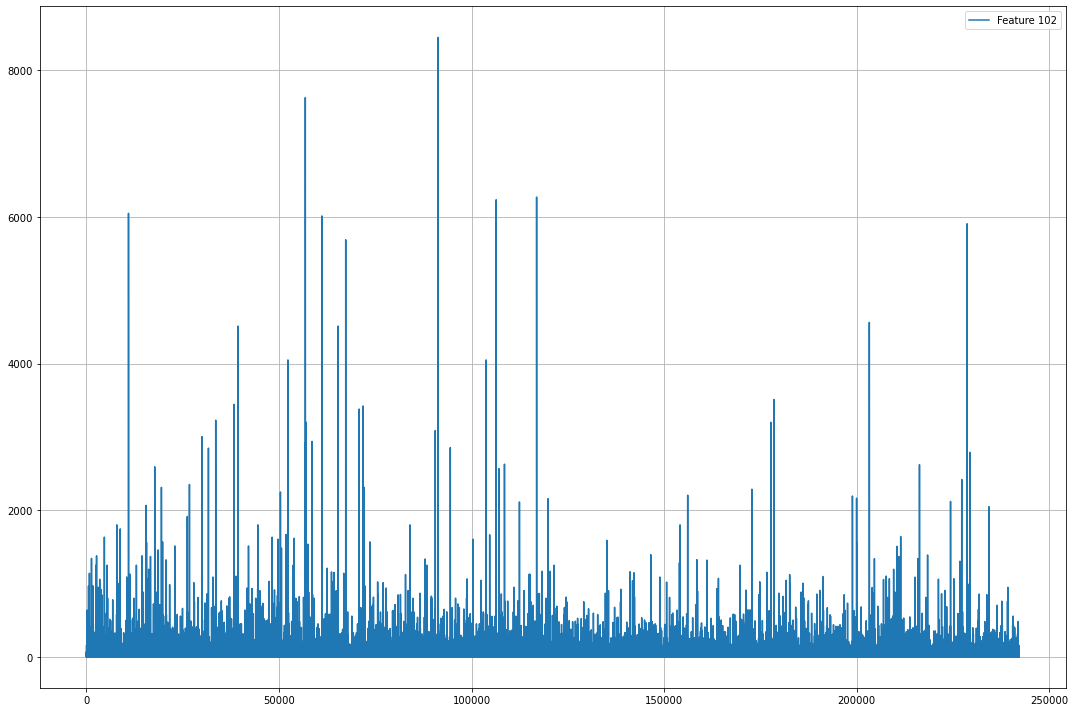

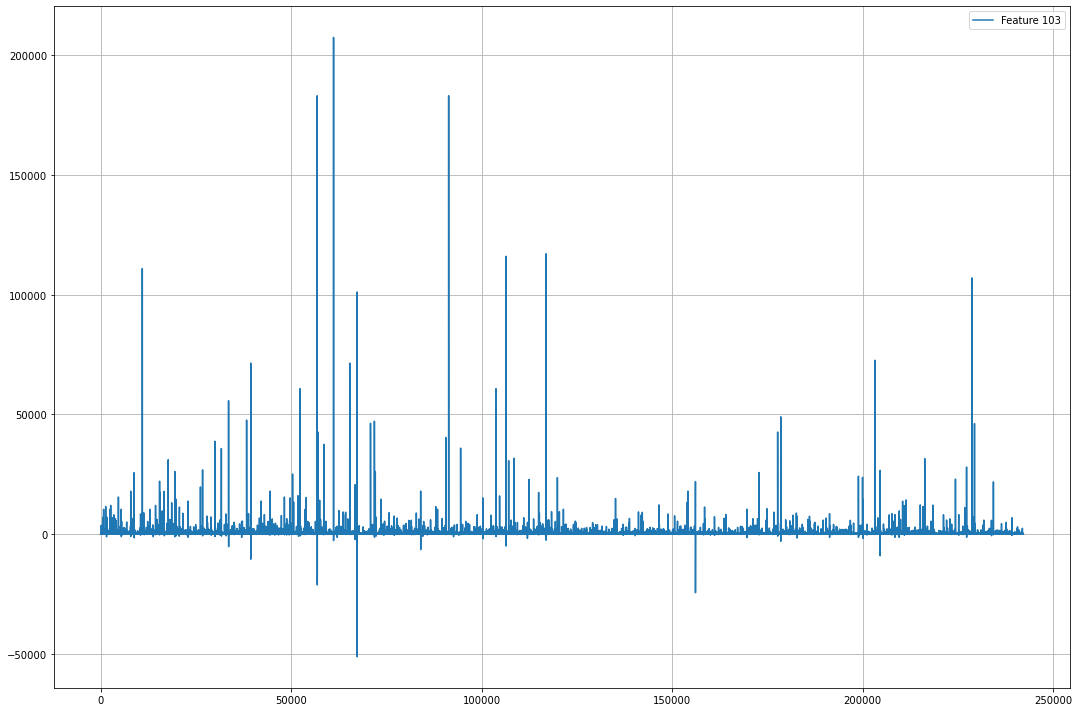

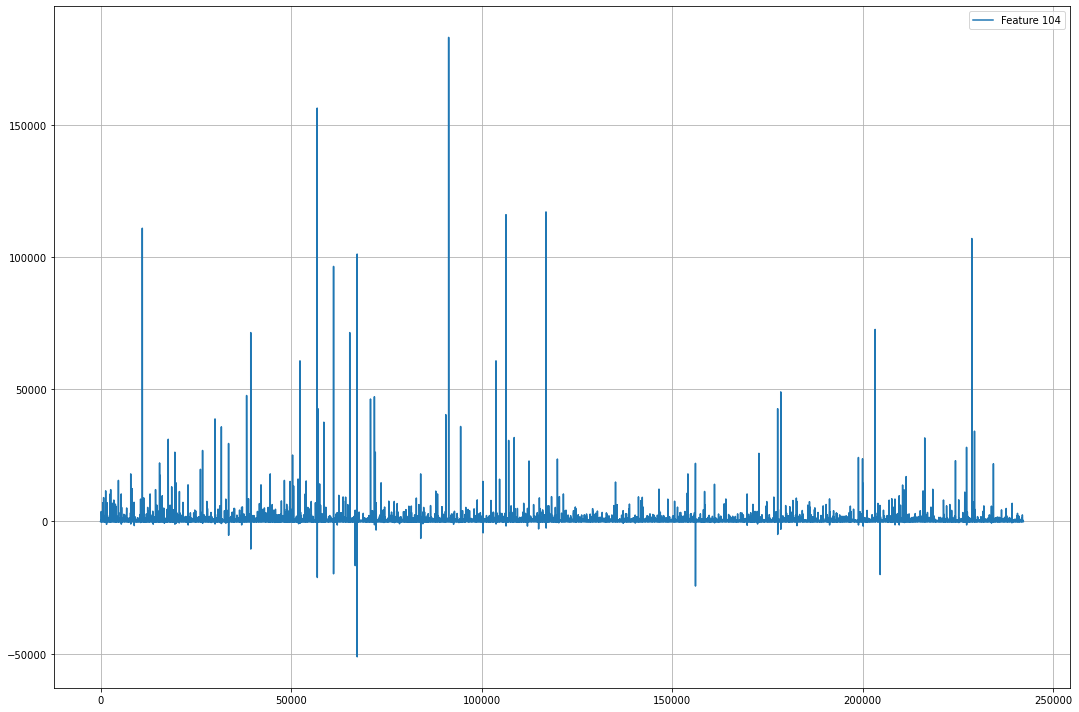

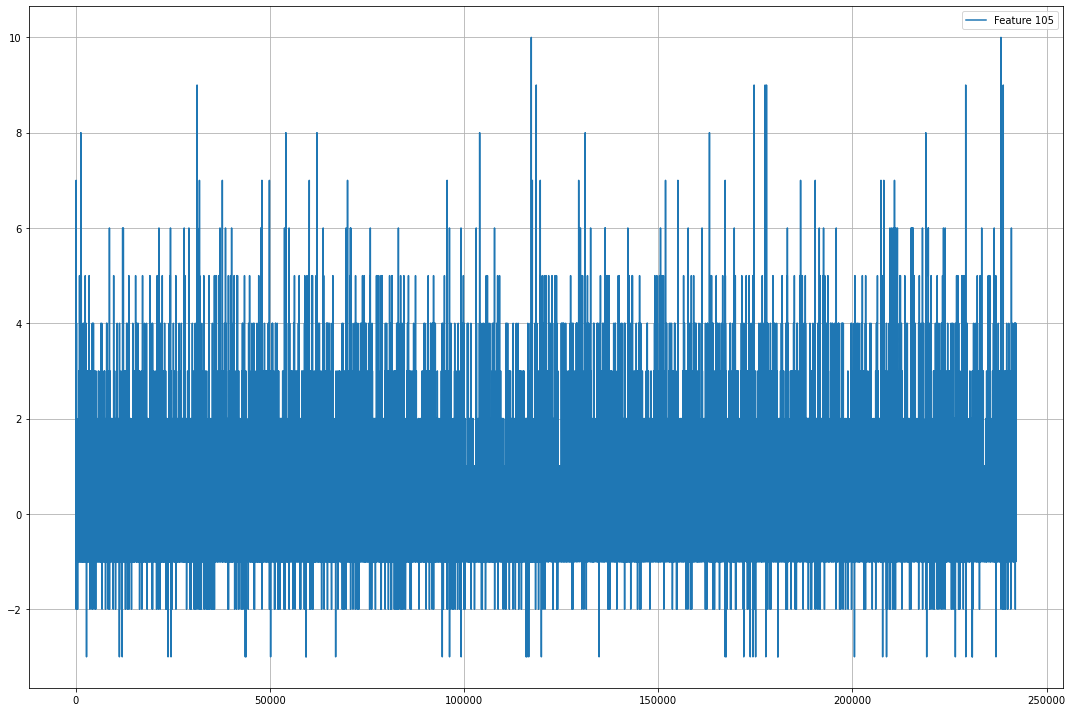

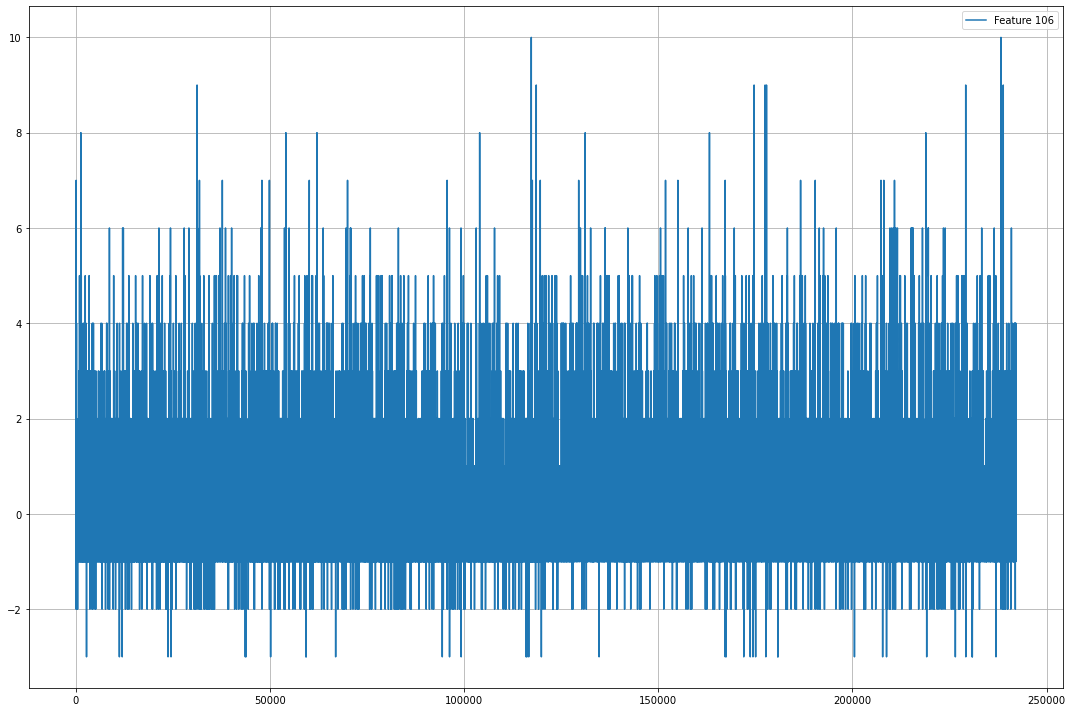

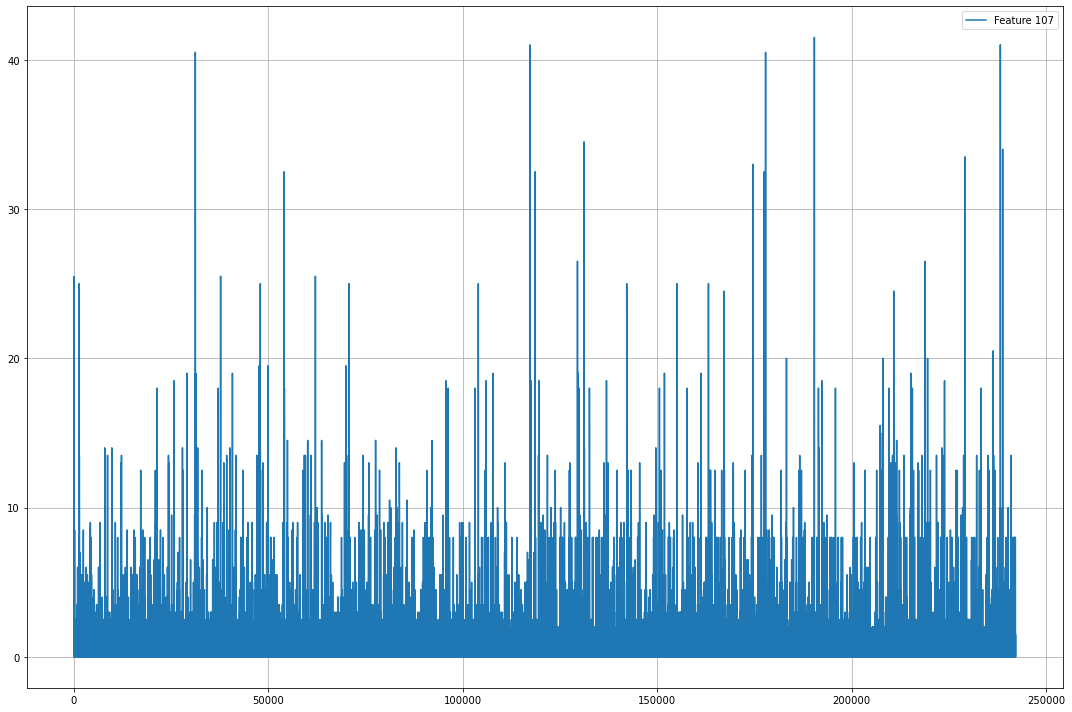

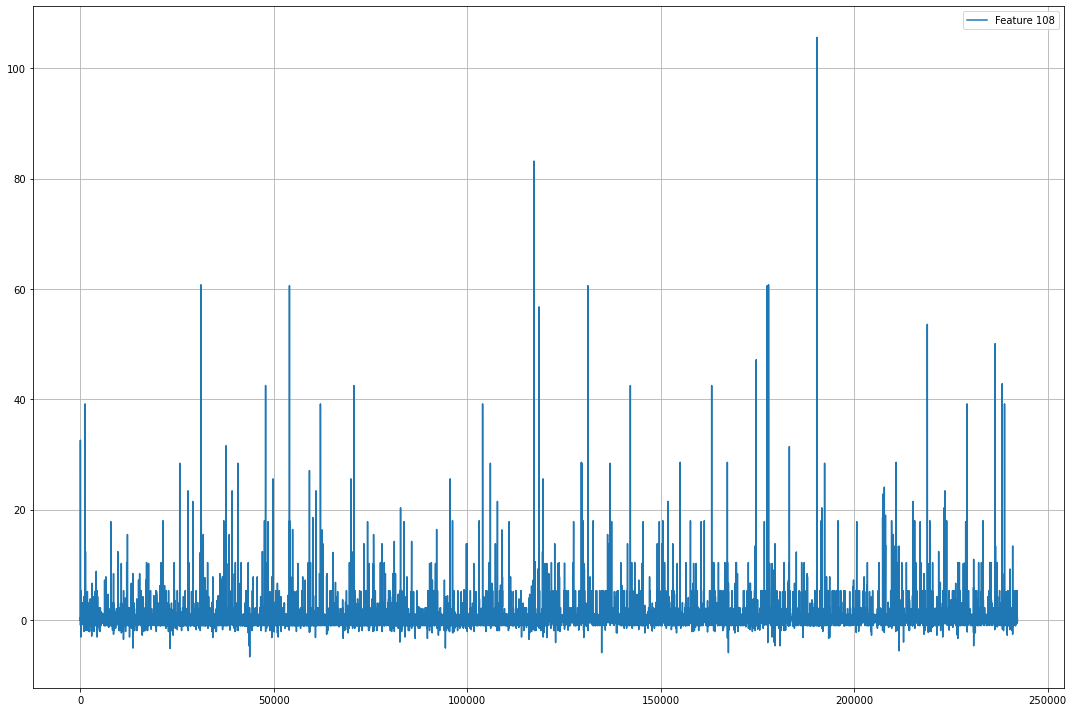

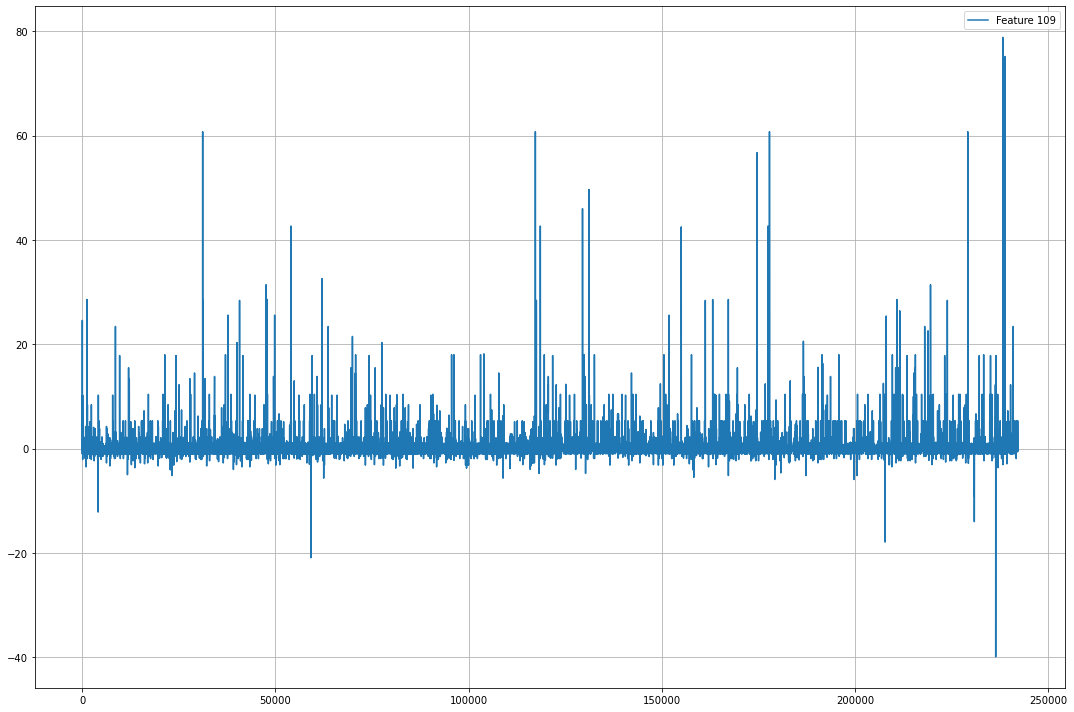

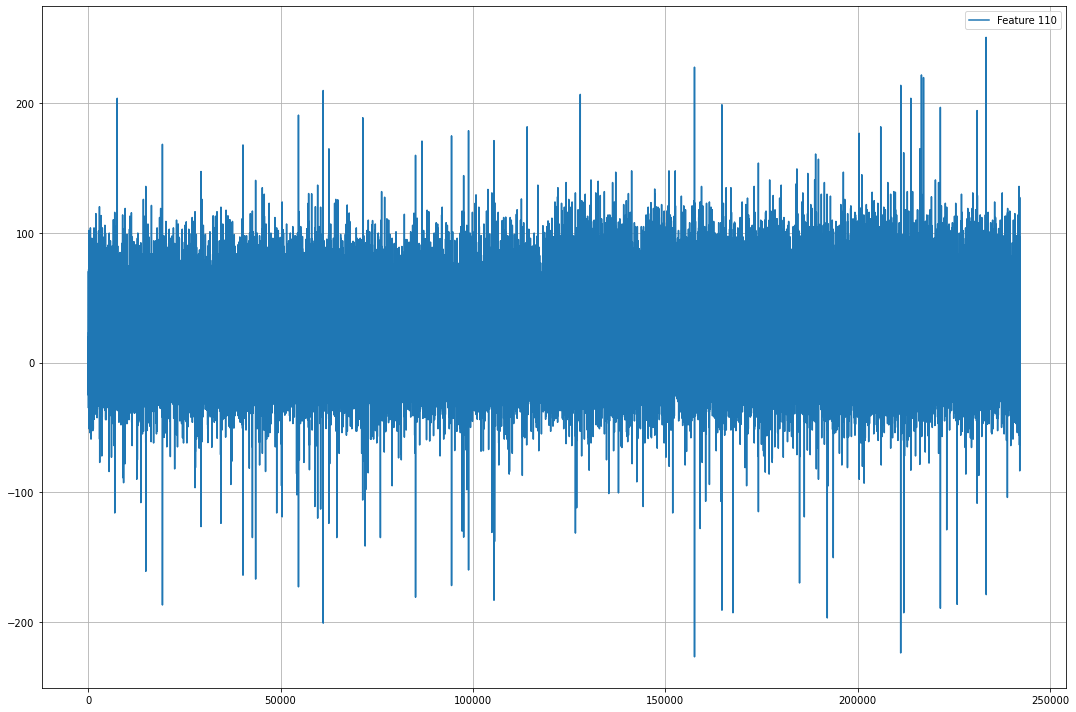

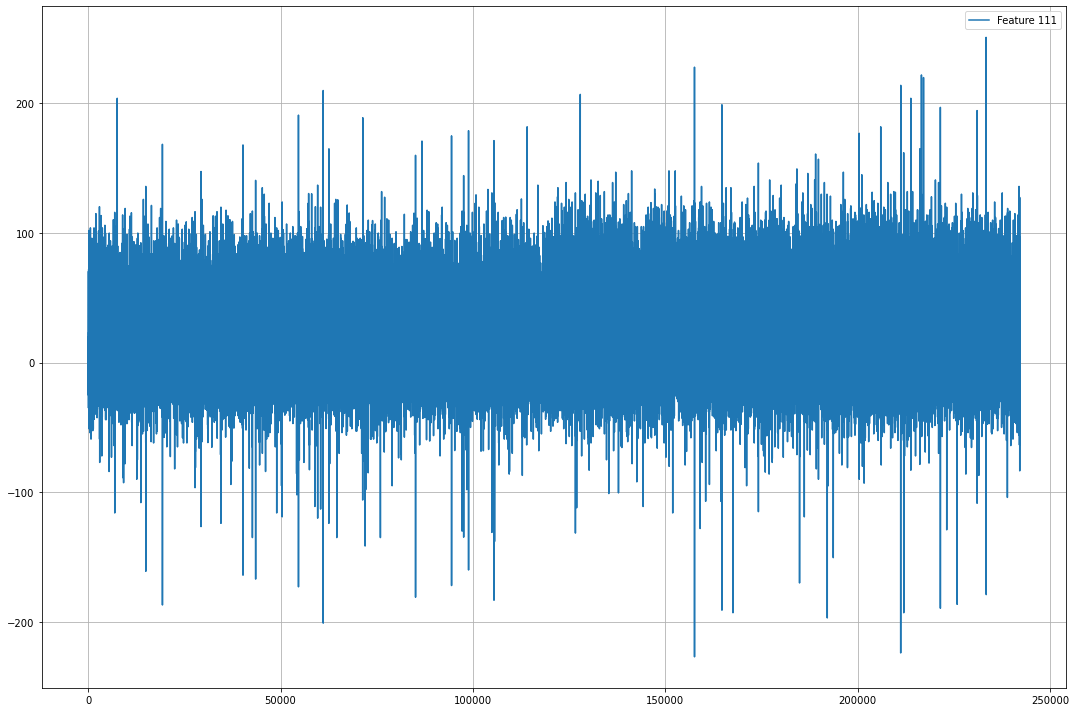

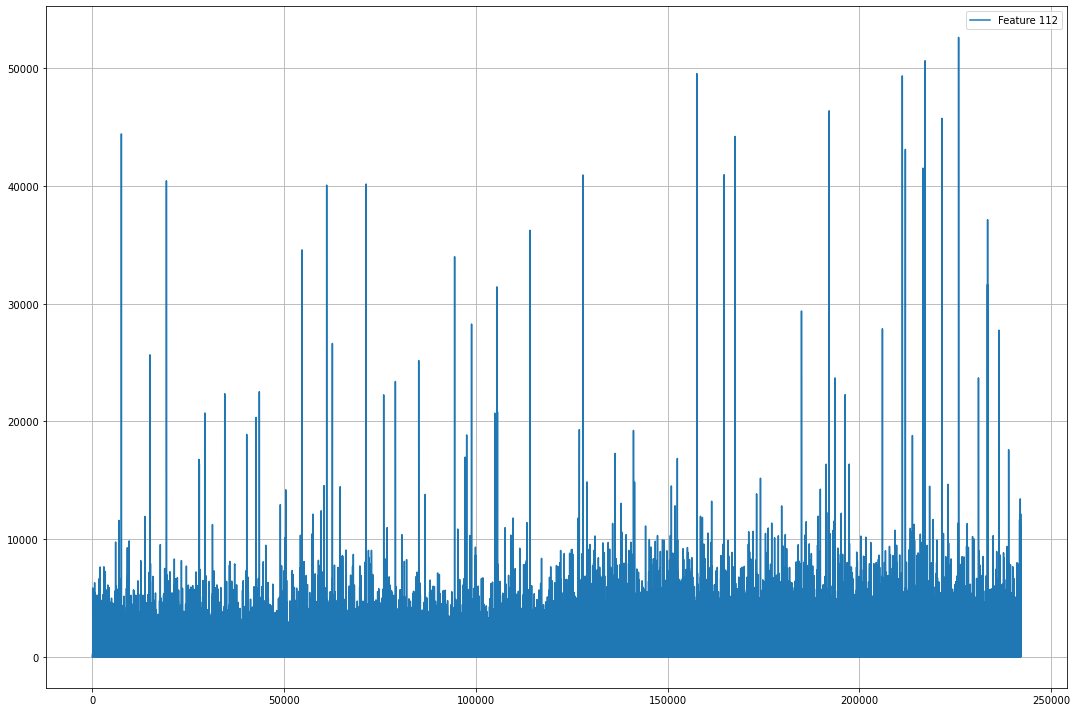

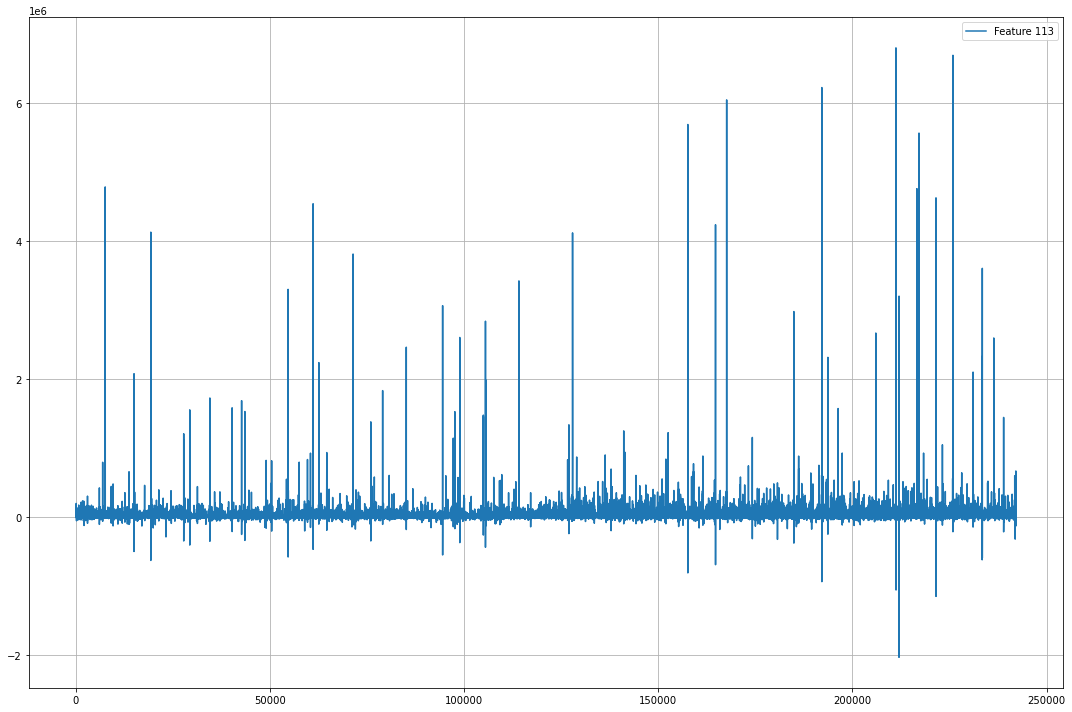

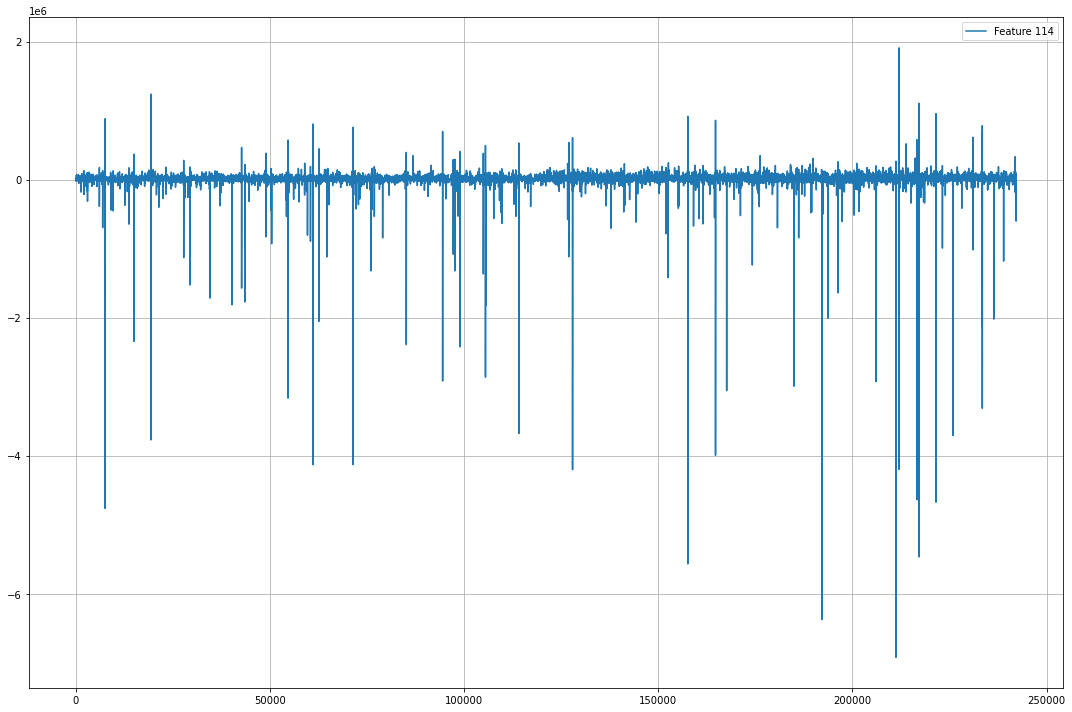

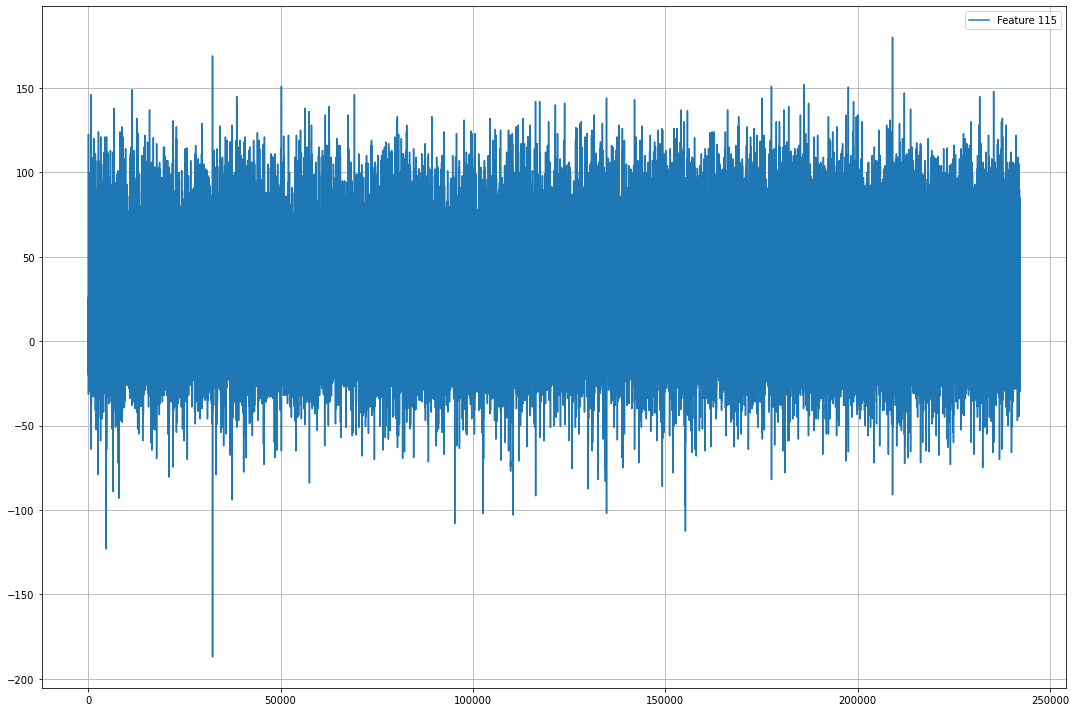

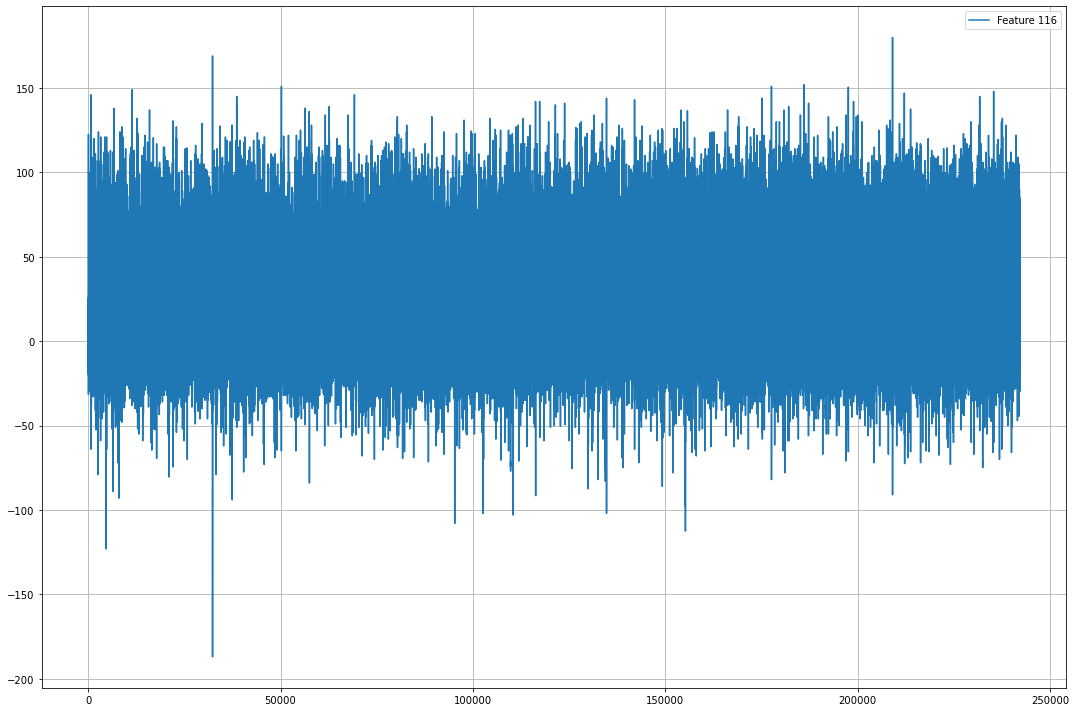

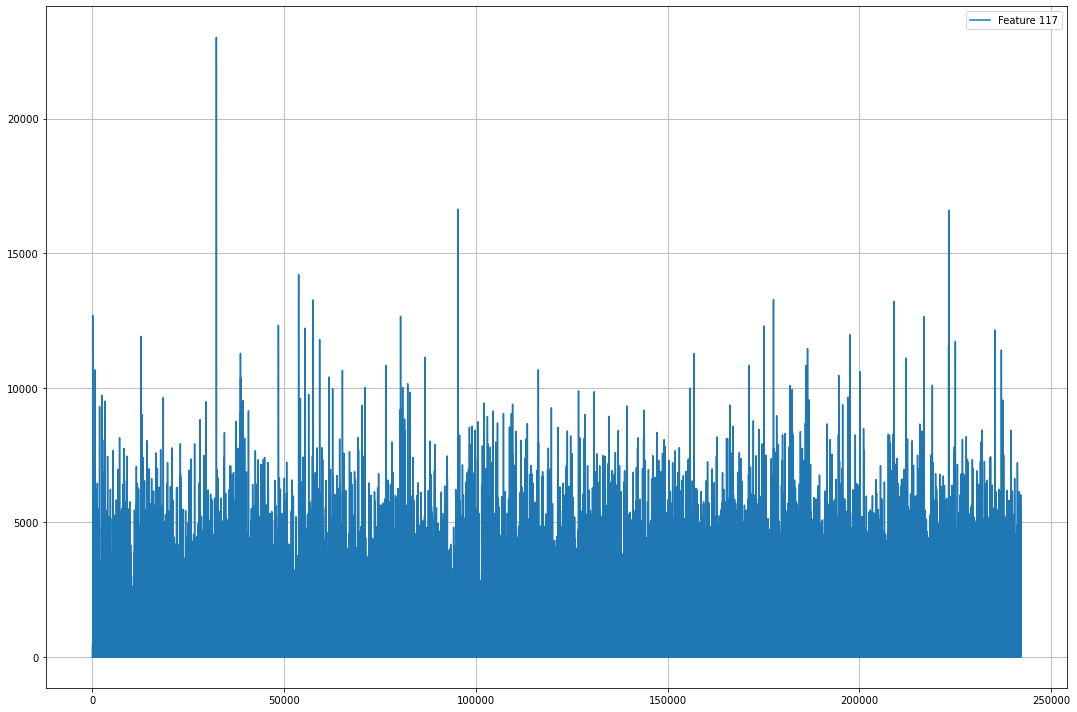

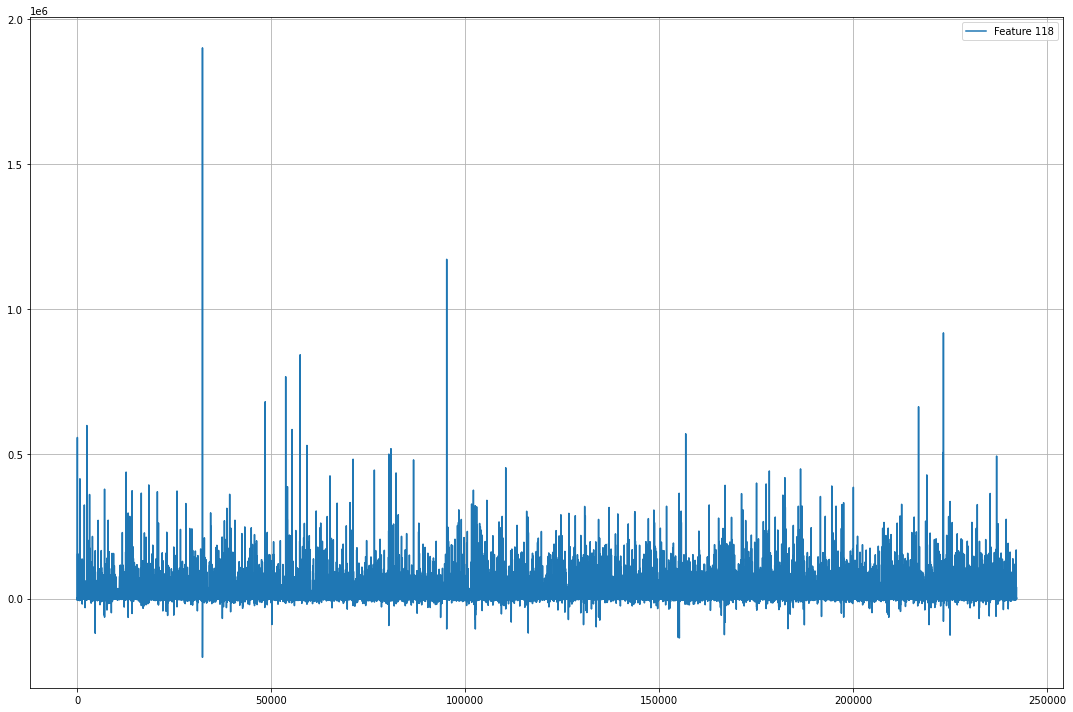

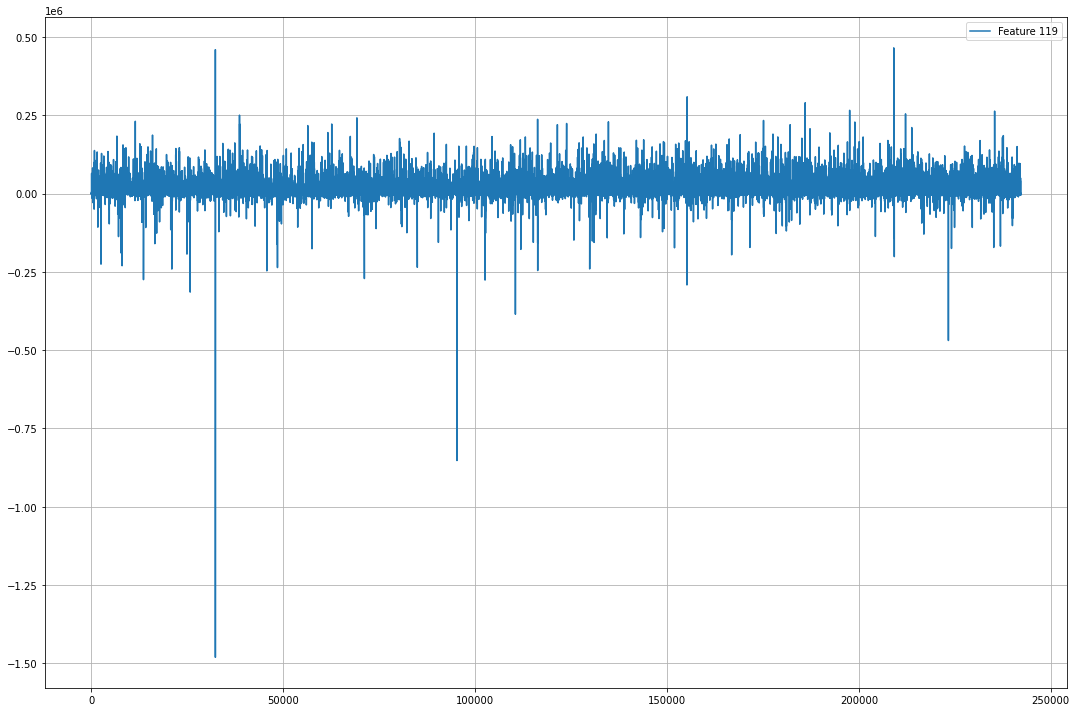

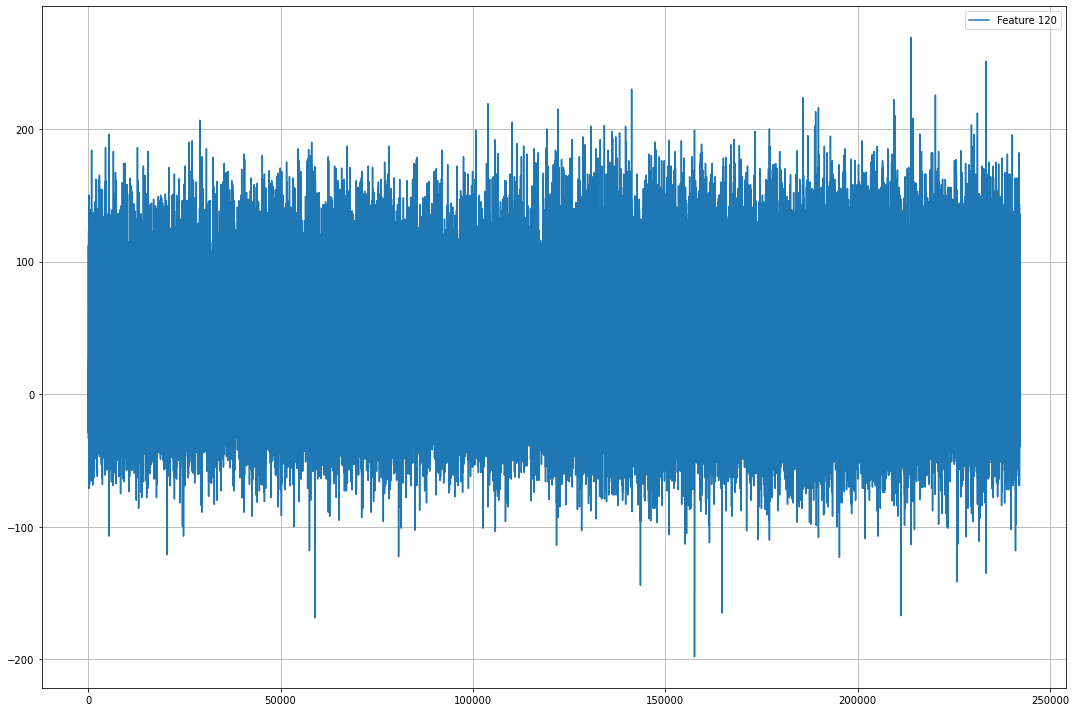

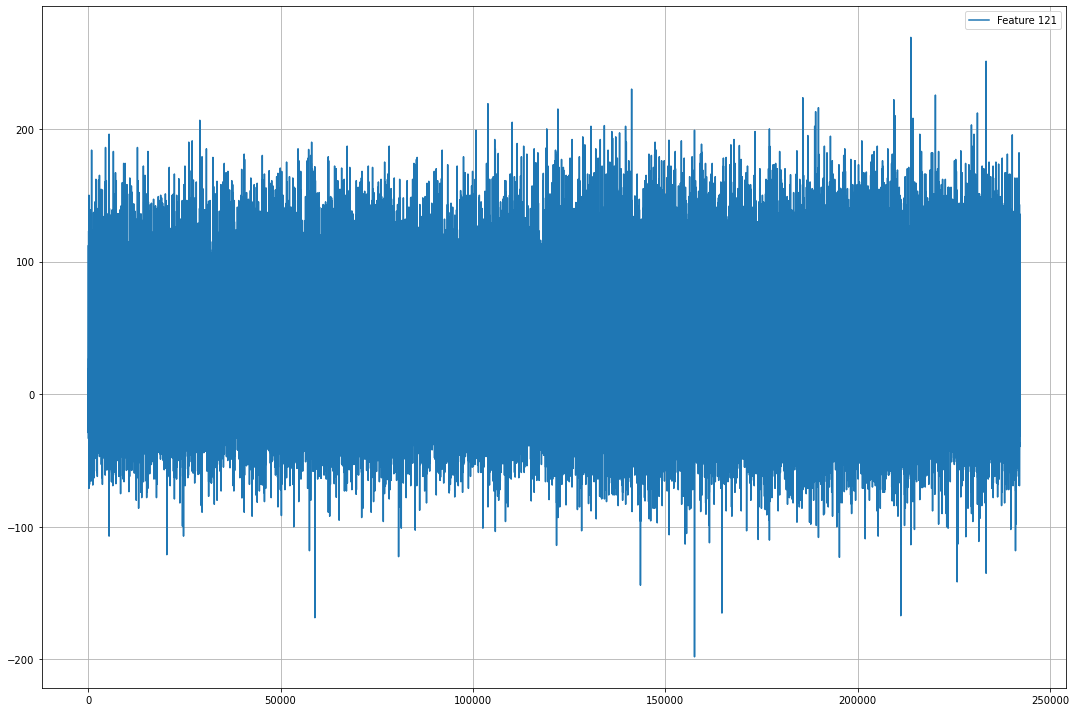

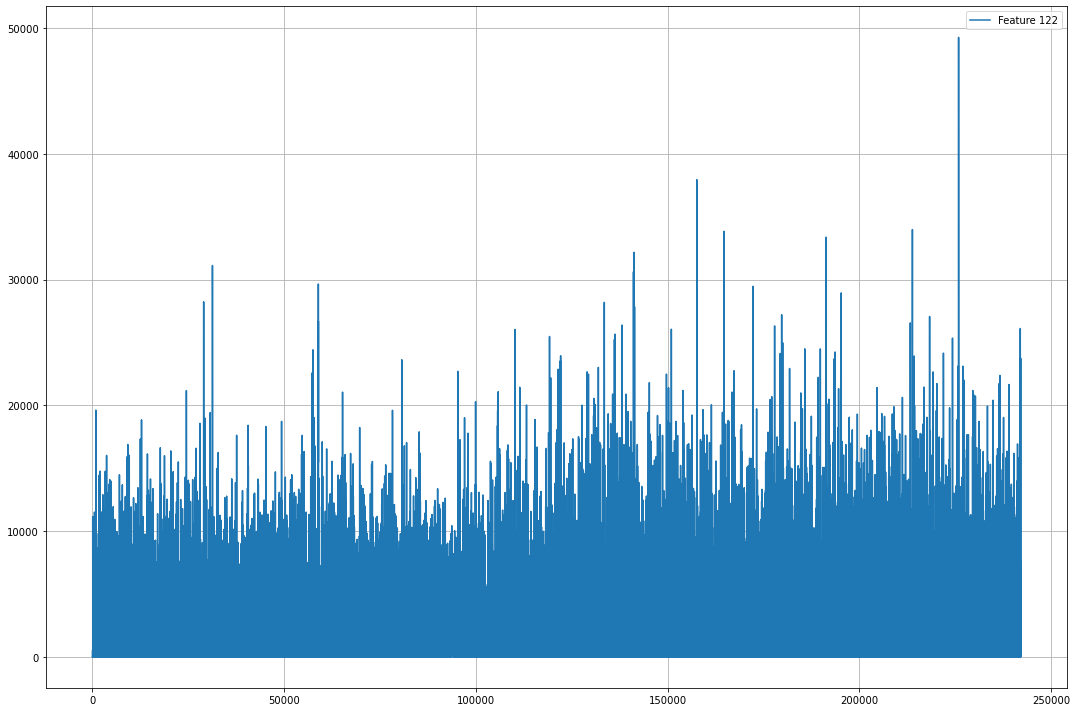

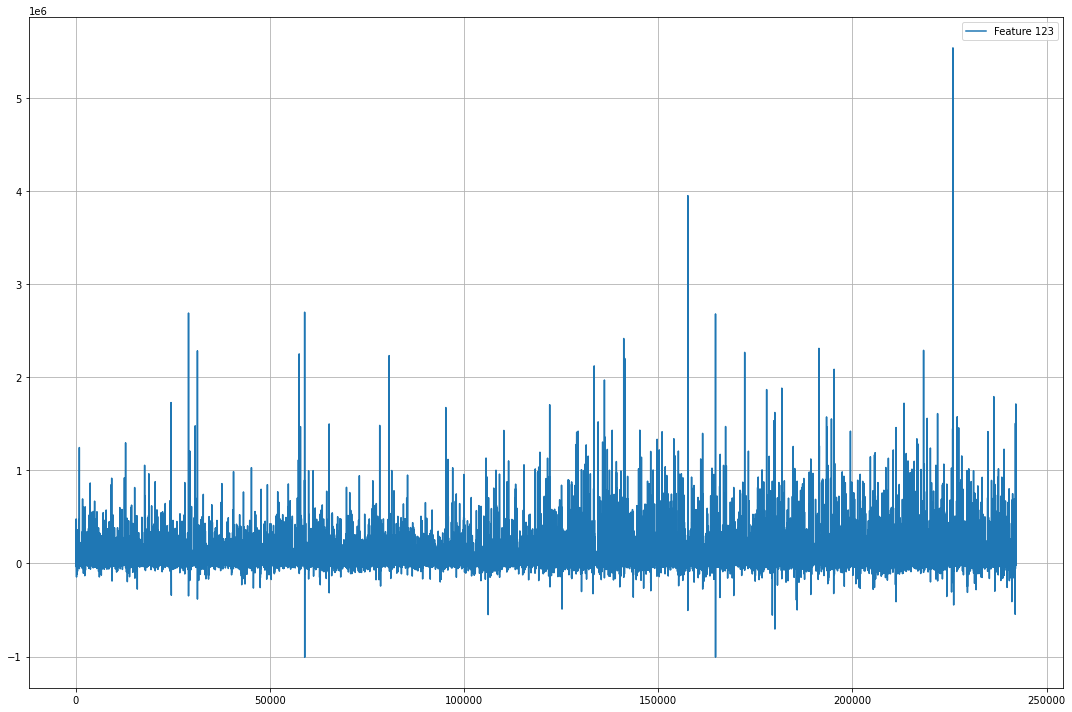

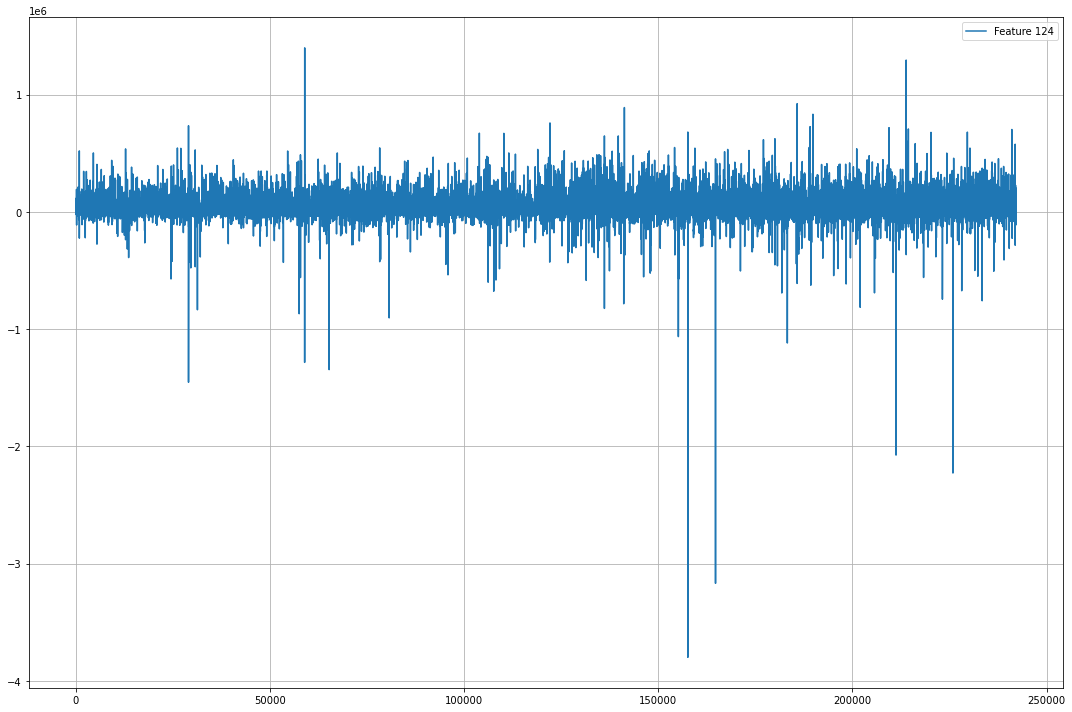

In [38]:
import matplotlib.gridspec as gridspec

for i in range(125):
    fig = plt.figure(figsize=(20,10), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios =[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(data[:, i], label = 'Feature '+str(i))

    plt.legend()
    plt.show()

## Concept/Data Drift 

In [39]:
## K-S Test for features
from scipy.stats import ks_2samp
def KSTest():
    for i in range(125):

        test = ks_2samp(data[120492:][:, i].numpy(), data[:120492][:, i].numpy())
        print(" Kolmogorov-Smirnov (K-S) test for column ", i," is: ", test)

In [40]:
KSTest()

 Kolmogorov-Smirnov (K-S) test for column  0  is:  KstestResult(statistic=0.038055761016742407, pvalue=1.2947038902498166e-76)
 Kolmogorov-Smirnov (K-S) test for column  1  is:  KstestResult(statistic=0.030253107969598653, pvalue=1.4307645620265814e-48)
 Kolmogorov-Smirnov (K-S) test for column  2  is:  KstestResult(statistic=0.12275417411281253, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  3  is:  KstestResult(statistic=0.08767279639564363, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  4  is:  KstestResult(statistic=0.16641199858657735, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  5  is:  KstestResult(statistic=0.3672272602733061, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  6  is:  KstestResult(statistic=0.06463949906302771, pvalue=2.34867738263031e-220)
 Kolmogorov-Smirnov (K-S) test for column  7  is:  KstestResult(statistic=0.19133057722180669, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  8  is:  KstestResult(statistic=0.21438688551

 Kolmogorov-Smirnov (K-S) test for column  73  is:  KstestResult(statistic=0.027478448940783662, pvalue=3.82454000272984e-40)
 Kolmogorov-Smirnov (K-S) test for column  74  is:  KstestResult(statistic=0.08446856469515895, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  75  is:  KstestResult(statistic=0.05337949956278276, pvalue=2.2970829040523941e-150)
 Kolmogorov-Smirnov (K-S) test for column  76  is:  KstestResult(statistic=0.025082361846847895, pvalue=1.613128233494027e-33)
 Kolmogorov-Smirnov (K-S) test for column  77  is:  KstestResult(statistic=0.34075967874849006, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  78  is:  KstestResult(statistic=0.14074825679843445, pvalue=0.0)
 Kolmogorov-Smirnov (K-S) test for column  79  is:  KstestResult(statistic=0.029349869053525435, pvalue=9.723203829374155e-46)
 Kolmogorov-Smirnov (K-S) test for column  80  is:  KstestResult(statistic=0.023940986069420078, pvalue=1.415911272176576e-30)
 Kolmogorov-Smirnov (K-S) test for column

In [55]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [56]:
## Calculate psi for features
def psi():
    psi_list = []
    for i in range(125):
        # Assuming you have a validation and training set
        psi_t = calculate_psi(data[120492:][:, i].numpy(), data[:120492][:, i].numpy())
        psi_list.append(psi_t)      
        print('Stability index for column ',i,'is',psi_t)

In [57]:
psi()

Stability index for column  0 is 0.011646390578697416
Stability index for column  1 is 0.004771356253784404
Stability index for column  2 is 0.03477769388406336
Stability index for column  3 is 0.05017506892586068
Stability index for column  4 is 0.16538655157980953
Stability index for column  5 is 1.0778391084111791
Stability index for column  6 is 0.012573066114247687
Stability index for column  7 is 1.2192874564951364
Stability index for column  8 is 1.2554682614624824
Stability index for column  9 is 4.4150837686905895
Stability index for column  10 is 0.47201454228645723
Stability index for column  11 is 0.4213414441040716
Stability index for column  12 is 0.38144480049257423
Stability index for column  13 is 0.3397149735143874
Stability index for column  14 is 0.0027614358999479478
Stability index for column  15 is 0.007323664603987543
Stability index for column  16 is 0.002402217009229299
Stability index for column  17 is 0.08027448354414594
Stability index for column  18 is 3.0

In [41]:
import pandas as pd

from datetime import datetime
from sklearn import datasets

from evidently.dashboard import Dashboard
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, CatTargetDriftProfileSection

In [42]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [43]:
bcancer_data_drift_dashboard = Dashboard(tabs=[DataDriftTab(verbose_level=1)])

In [44]:
data = pd.DataFrame(data.numpy())

In [45]:
data[:120492]

0      1          2      3      4     5     6    7    8     9    ...  \
0       84.0   97.5  37.279999  140.5   94.5   0.0  17.5  0.0  0.0   0.0  ...   
1       80.0   99.0  37.279999  150.0   99.0   0.0  18.0  0.0  0.0   0.0  ...   
2       74.0   97.0  37.220001  142.0  103.0   0.0  19.0  0.0  0.0   0.0  ...   
3       73.0   98.0  37.220001  144.0   99.0   0.0  17.0  0.0  0.0   0.0  ...   
4       71.0   97.0  37.220001  144.0   99.0   0.0  17.0  0.0  0.0  24.0  ...   
...      ...    ...        ...    ...    ...   ...   ...  ...  ...   ...  ...   
120487  63.0  100.0  36.700001  144.0   70.0  47.0  25.0  0.0 -1.0  23.0  ...   
120488  66.0   94.0  36.599998  102.0   52.0  35.0  25.0  0.0 -1.0  23.0  ...   
120489  65.0   94.0  36.500000  118.0   54.0  36.0  21.0  0.0 -1.0  23.0  ...   
120490  65.0   97.0  36.400002  106.0   52.0  35.0  20.0  0.0 -1.0  23.0  ...   
120491  63.0   96.0  36.400002  105.0   54.0  37.0  21.0  0.0 -1.0  23.0  ...   

         115   116   117        118        119   120   121     122  \
0        0.0   0.0   0.0   0.000000   0.000000   0.0   0.0     0.0   
1        0.0   0.0   0.0   0.000000   0.000000   0.0   0.0     0.0   
2        0.0   0.0   0.0   0.000000   0.000000   0.0   0.0     0.0   
3        0.0   0.0   0.0   0.000000   0.000000   0.0   0.0     0.0   
4        0.0   0.0   0.0   0.000000   0.000000   0.0   0.0     0.0   
...      ...   ...   ...        ...        ...   ...   ...     ...   
120487   1.0   1.0  21.5 -93.916664  86.083336  29.0  29.0   297.5   
120488   7.0   7.0  21.5 -71.416656  72.583344  -4.0  -4.0  1139.0   
120489  10.0  10.0  14.0  14.333359  -2.666641  12.0  12.0  1267.0   
120490   7.0   7.0   9.5  13.583336  -6.416664  -5.0  -5.0  1326.5   
120491   3.0   3.0   9.5  22.250000 -17.750000 -26.0 -26.0  1127.0   

                 123           124  
0           0.000000      0.000000  
1           0.000000      0.000000  
2           0.000000      0.000000  
3           0.000000      0.000000  
4           0.000000      0.000000  
...              ...           ...  
120487  -1736.583008   3075.416992  
120488  16231.166992 -27118.833984  
120489   7204.500000 -17409.500000  
120490  11736.583008 -22250.416016  
120491  -2138.167969  -9709.167969  

[120492 rows x 125 columns]

In [46]:

bcancer_data_drift_dashboard.calculate(data[:120492], data[120492:], column_mapping=None)

In [47]:
bcancer_data_drift_dashboard.show()

In [48]:
data.to_csv('data.csv', index=False)
